# Libraries

In [245]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.base import clone

from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier




import random

# For reproducability.
seed = 2003
random.seed(seed)
np.random.seed(seed)

# Import Datasets

In [16]:
assessments = pd.read_csv(r'..\..\anonymisedData\assessments.csv')
courses = pd.read_csv(r'..\..\anonymisedData\courses.csv')
studentAssessment = pd.read_csv(r'..\..\anonymisedData\studentAssessment.csv')
studentInfo = pd.read_csv(r'..\..\anonymisedData\studentInfo.csv')
studentRegistration = pd.read_csv(r'..\..\anonymisedData\studentRegistration.csv')
studentVle = pd.read_csv(r'..\..\anonymisedData\studentVle.csv')
vle = pd.read_csv(r'..\..\anonymisedData\vle.csv')

# Defined Functions

In [17]:
def compare_df_cols(series1, series2):
    """
    Compare two pandas Series and identify values present in series1 but missing in series2.
    Counts how many times each missing value appears in series1.
    
    Args:
        series1 (pd.Series): The first series to compare (e.g., list of student IDs from registration).
        series2 (pd.Series): The second series to compare against (e.g., list of student IDs from assessment).
    
    Prints:
        Total number of missing rows (values in series1 not found in series2).
        Number of unique missing values.
        The missing values along with their occurrence counts in series1.

    Returns:
        missing_counts (pd.Series): A series containing the missing values from series1 as the index and their counts as the values.
    """
    missing_values = series1[~series1.isin(series2)] # Find values in series1 not in series2.
    missing_counts = missing_values.value_counts() # Count how many times each missing ID appears.

    print(f'Total missing rows: {missing_counts.sum()}') # Total rows missing.
    print(f'Number of unique missing IDs: {len(missing_counts)}')  # Unique missing IDs.
    print('Missing IDs and their counts:')
    print(missing_counts)

    return missing_counts

def plot_bar_with_annotations(categories, counts, xlabel='', ylabel='', title='', rotation=0, color='skyblue', figsize=(8,5)):
    """
    Plots a bar chart with annotations on top of each bar.
    
    Args:
        categories (list): Categories/labels for the x-axis.
        counts (list): Corresponding counts or values for each category.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Plot title.
        rotation (int): Rotation angle for x-axis tick labels.
        color (str or list): Bar color(s).
        figsize (tuple): Figure size (width, height).
    """
    plt.figure(figsize=figsize)
    bars = plt.bar(categories, counts, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=rotation)
    
    # Add annotations on top of each bar.
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset.
                     textcoords="offset points",
                     ha='center', va='bottom')
    plt.show()

def compare_shared_columns(df1, df2, name1='df1', name2='df2', return_missing=False):
    """
    For each shared column between two DataFrames:
    - Show how many values in df1[col] are found in df2[col] using .isin().value_counts().
    - Show what unique values in df1[col] do not appear in df2[col].
    - Optionally return a dictionary of DataFrames with rows from df1 that contain those missing values.
    
    Args:
        df1, df2 (pd.DataFrame): DataFrames to compare.
        name1, name2 (str): Names to use in output for readability.
        return_missing (bool): If True, returns a dict of DataFrames showing rows from df1 with unmatched values.
    
    Returns:
        missing_rows (dict): Optional. Keys are column names, values are DataFrames of missing rows in df1.
    """
    shared_cols = set(df1.columns) & set(df2.columns)
    print(f'Shared columns between {name1} and {name2}: {shared_cols}\n')

    missing_rows = {}

    for col in sorted(shared_cols):
        print(f'=== Column: "{col}" ===')

        # 1. Value presence check
        match_mask = df1[col].isin(df2[col])
        print(f'Presence of {name1} values in {name2}:')
        print(match_mask.value_counts(), '\n')

        # 2. Unique value difference
        df1_unique = set(df1[col].dropna().unique())
        df2_unique = set(df2[col].dropna().unique())
        missing_values = df1_unique - df2_unique

        print(f'Values from {name1} not in {name2}: {missing_values}')
        print(f'Number of missing values: {len(missing_values)}\n')

        # 3. Return missing rows from df1, if requested
        if return_missing and missing_values:
            missing_df = df1[df1[col].isin(missing_values)].copy()
            missing_rows[col] = missing_df

    if return_missing:
        return missing_rows

def get_missing_rows(df1, df2, col):
    """
    Return all rows from df1 where values in 'col' do not appear in df2[col].
    """
    # Get unique values from each dataframe column (excluding NaNs).
    unique_vals_df1 = df1[col].dropna().unique()
    unique_vals_df2 = df2[col].dropna().unique()

    # Identify values in df1[col] missing from df2[col].
    missing_values = [val for val in unique_vals_df1 if val not in unique_vals_df2]

    # Filter df1 rows where column value is in the missing_values list.
    missing_rows = df1[df1[col].isin(missing_values)].copy()

    return missing_rows

# Overview and Brief Analysis

## Courses Table

This table provides a list of all modules and their corresponding presentations. It includes the following columns:

* **code\_module**: the identifier for each module.
* **code\_presentation**: the identifier for each presentation, combining the year with either "B" (for February starts) or "J" (for October starts).
* **length**: the duration of the module presentation in days.

Since the structure of B and J presentations may vary, it is advisable to analyse them separately. However, in some cases, one type of presentation (B or J) may not have a counterpart from the previous cycle. In such instances, specifically for the CCC, EEE, and GGG modules, the available J presentation may need to be used to inform the B presentation, or vice versa.

In [18]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


### Missing, Duplicate, and Distinct Values Overview

In [19]:
print('Total null values: \n', courses.isnull().sum(), '\n')
print('Total duplicated values:', courses[courses.duplicated()], '\n')
print('Total unique values: \n', courses.nunique())

Total null values: 
 code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, module_presentation_length]
Index: [] 

Total unique values: 
 code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64


### Data Types and Schema Overview

In [20]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 660.0+ bytes


## Assessments Table

This table contains details about assessments associated with different module presentations. Each presentation generally includes several assessments and concludes with a final exam. The CSV table includes the following columns:

* **code\_module**: The identifier for the module to which the assessment belongs.
* **code\_presentation**: The identifier for the specific presentation of the module.
* **id\_assessment**: A unique identifier for each assessment.
* **assessment\_type**: The category of the assessment, which can be one of the following: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA), or Final Exam (Exam).
* **date**: The submission deadline for the assessment, expressed as the number of days from the start of the presentation (which begins at day 0).
* **weight**: The contribution of the assessment to the overall module grade, given as a percentage. Exams typically carry a separate weight of 100%, while the combined weight of all other assessments is also 100%. If the exam date is not provided, it is assumed to occur at the end of the final presentation week.

In [21]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


### Missing, Duplicate, and Distinct Values Overview

In [22]:
print('Total null values: \n', assessments.isnull().sum(), '\n')
print('Total duplicated values:', assessments[assessments.duplicated()], '\n')
print('Total unique values: \n', assessments.nunique())

Total null values: 
 code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, id_assessment, assessment_type, date, weight]
Index: [] 

Total unique values: 
 code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
date                  74
weight                24
dtype: int64


There are 11 assessments with missing submission dates. The dataset includes:

* **7 distinct modules**
* **4 different presentations**: 2013J, 2013B, 2014J, and 2014B. The year indicates when the presentation took place, while "B" represents a February start and "J" an October start.
* **A total of 206 assessments** distributed across all modules
* **3 types of assessments**: Tutor Marked Assessments (TMA), Computer Marked Assessments (CMA), and Final Exams (Exam)

### Data Types and Schema Overview

In [23]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


The `id_assessment` values are currently displayed as integers, which is inaccurate. We should convert them to the `object` data type instead.

In [24]:
assessments['id_assessment'] = assessments['id_assessment'].astype(object)

### Investigate Assessment Weights

Project brief states that typically, exams have a weight of 100 and the sum of all other assessments is 100. This would man that a module with one exam only would have a weight of 100 and a module with one exam and some assessments would have a weight of 200. Let’s check if this so in the table provided.


In [25]:
# Group by module presentation and sum the weights of assessments.
assessments.groupby(['code_module','code_presentation']).agg(total_weight = ('weight', 'sum'))

total_weight
code_module code_presentation              
AAA         2013J                     200.0
            2014J                     200.0
BBB         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
CCC         2014B                     300.0
            2014J                     300.0
DDD         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
EEE         2013J                     200.0
            2014B                     200.0
            2014J                     200.0
FFF         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
GGG         2013J                     100.0
            2014B                     100.0
            2014J                     100.0

We observe that most module presentations have a total assessment weight of 200. However, there are exceptions like module CCC has a total weight of 300, while module GGG has only 100. Let us examine these cases more closely.

Let us start with the 'Exam' assessment type

In [26]:
# Examine the weight distribution of 'exams' across different module presentations.
assessments[assessments['assessment_type'] == 'Exam'].groupby(['code_module','code_presentation', 'assessment_type']).agg(total_weight = ('weight', 'sum'))

total_weight
code_module code_presentation assessment_type              
AAA         2013J             Exam                    100.0
            2014J             Exam                    100.0
BBB         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
CCC         2014B             Exam                    200.0
            2014J             Exam                    200.0
DDD         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
EEE         2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
FFF         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
GGG         2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0

All modules have an exam weight of 100, except for module CCC (in both presentations). Let us now count how many exam assessments exist in each module presentation.


In [27]:
# Count how many exams there are in every module and presentation.
assessments[assessments['assessment_type'] == 'Exam'][['code_module', 'code_presentation', 'id_assessment']].groupby(['code_module', 'code_presentation']).count()

id_assessment
code_module code_presentation               
AAA         2013J                          1
            2014J                          1
BBB         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
CCC         2014B                          2
            2014J                          2
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
EEE         2013J                          1
            2014B                          1
            2014J                          1
FFF         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
GGG         2013J                          1
            2014B                          1
            2014J                          1

Module CCC includes two exams, which likely explains the higher total assessment weight for this module. Now, let us examine all the assignments that are not classified as exams to ensure everything appears correct.

In [28]:
# Calculate the total weight of all non-exam assignments for each module and presentation.
assessments[assessments['assessment_type'] != 'Exam'].groupby(['code_module', 'code_presentation']).agg(total_weight = ('weight', 'sum'))

total_weight
code_module code_presentation              
AAA         2013J                     100.0
            2014J                     100.0
BBB         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
CCC         2014B                     100.0
            2014J                     100.0
DDD         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
EEE         2013J                     100.0
            2014B                     100.0
            2014J                     100.0
FFF         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
GGG         2013J                       0.0
            2014B                       0.0
            2014J                       0.0

We observe that module GGG has no assignment weight. Let us investigate further.

In [29]:
assessments[assessments['code_module'] == 'GGG'].groupby(['code_module','code_presentation', 'assessment_type']).agg(weight_by_type = ('weight', 'sum'))

weight_by_type
code_module code_presentation assessment_type                
GGG         2013J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014B             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0

Module GGG has both CMA and TMA, but both have zero weight. Let us check if there are any other modules besides GGG where CMA or TMA have zero weight.

In [30]:
assessments[(assessments['assessment_type'] == 'TMA') & (assessments['weight'] == 0)]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
48,BBB,2014J,15020,TMA,19.0,0.0
182,GGG,2013J,37415,TMA,61.0,0.0
183,GGG,2013J,37416,TMA,124.0,0.0
184,GGG,2013J,37417,TMA,173.0,0.0
192,GGG,2014B,37425,TMA,61.0,0.0
193,GGG,2014B,37426,TMA,117.0,0.0
194,GGG,2014B,37427,TMA,166.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [31]:
assessments[(assessments['assessment_type'] == 'CMA') & (assessments['weight'] == 0)]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
124,FFF,2013B,34865,CMA,222.0,0.0
125,FFF,2013B,34866,CMA,222.0,0.0
126,FFF,2013B,34867,CMA,222.0,0.0
127,FFF,2013B,34868,CMA,222.0,0.0
128,FFF,2013B,34869,CMA,222.0,0.0
129,FFF,2013B,34871,CMA,222.0,0.0
130,FFF,2013B,34870,CMA,222.0,0.0
137,FFF,2013J,34878,CMA,236.0,0.0
138,FFF,2013J,34879,CMA,236.0,0.0
139,FFF,2013J,34880,CMA,236.0,0.0


It appears that the FFF modules have CMAs with zero weight, while for the BBB module, only the 2014b presentation has a TMA assessment with zero weight.

## Student Assessment Table

This table records the results of students' assessments. If a student does not submit an assessment, no result is captured. Similarly, final exam data is missing if the assessment result was not recorded in the system. The table includes the following columns:

* **id\_assessment**: unique identifier for the assessment.
* **id\_student**: unique identifier for each student.
* **date\_submitted**: the number of days since the start of the module presentation when the student submitted the assessment.
* **is\_banked**: a flag indicating whether the result was carried over from a previous presentation.
* **score**: the student’s score for the assessment, ranging from 0 to 100. Scores below 40 are considered a fail.

In [32]:
studentAssessment.head(10)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
5,1752,45462,20,0,70.0
6,1752,45642,18,0,72.0
7,1752,52130,19,0,72.0
8,1752,53025,9,0,71.0
9,1752,57506,18,0,68.0


In [33]:
studentAssessment.describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,173912.000000,1.739120e+05,173912.000000,173912.000000,173739.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977,75.799573
std,8829.784254,5.523952e+05,71.484148,0.104194,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


### Missing, Duplicate, and Distinct Values Overview

In [34]:
print('Total null values: \n', studentAssessment.isnull().sum(), '\n')
print('Total duplicated values:', studentAssessment[studentAssessment.duplicated()], '\n')
print('Total unique values: \n', studentAssessment.nunique())

Total null values: 
 id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [id_assessment, id_student, date_submitted, is_banked, score]
Index: [] 

Total unique values: 
 id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64


There are 173 null scores and no duplicated data

### Data Types and Schema Overview

In [35]:
studentAssessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [36]:
studentAssessment['id_assessment'] = studentAssessment['id_assessment'].astype(object)
studentAssessment['id_student'] = studentAssessment['id_student'].astype(object)

Convert the ID fields as object

### Submission Issue

In [37]:
assessments

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
...,...,...,...,...,...,...
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [38]:
# Find id_assessment values that are in assessments but not in studentAssessment.
missing_assessment_ids = assessments[~assessments['id_assessment'].isin(studentAssessment['id_assessment'])]

# Extract module and presentation for those missing ids.
missing_modules = missing_assessment_ids[['id_assessment', 'code_module', 'code_presentation', 'assessment_type']].drop_duplicates()

print("Assessments missing in studentAssessment:")
print(missing_modules)


Assessments missing in studentAssessment:
    id_assessment code_module code_presentation assessment_type
5            1757         AAA             2013J            Exam
11           1763         AAA             2014J            Exam
23          14990         BBB             2013B            Exam
35          15002         BBB             2013J            Exam
47          15014         BBB             2014B            Exam
53          15025         BBB             2014J            Exam
63          40087         CCC             2014B            Exam
73          40088         CCC             2014J            Exam
113         30713         EEE             2013J            Exam
118         30718         EEE             2014B            Exam
123         30723         EEE             2014J            Exam
136         34872         FFF             2013B            Exam
149         34885         FFF             2013J            Exam
162         34898         FFF             2014B            Exa

There are 18 assessments missing from the `studentAssessment` table, all of which are of the "Exam" type. The only module for which exam data is fully present in the `studentAssessment` table is module DDD.


In [39]:
studentAssessment[studentAssessment['score'].isnull()]

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


We also have 173 rows with null scores. According to the data description, if a student does not submit an assessment, no result is recorded. Similarly, final exam entries are absent when the assessment results are not stored in the system. As such, any missing scores can be interpreted as non-submissions.

**However, it's somewhat strange that some entries with missing scores still have submission dates recorded. Typically, if an assessment hasn't been submitted, the submission date should also be missing. This inconsistency should ideally be clarified with the data providers.**

## Student Registration Table

This table captures the timing of student registrations for module presentations. For students who withdrew, the date of unregistration is also included. It contains five columns:

* **code\_module**: the module's identification code.
* **code\_presentation**: the presentation's identification code.
* **id\_student**: a unique identifier for each student.
* **date\_registration**: the number of days (relative to the start of the module presentation) when the student registered. A negative value (e.g., -30) indicates registration occurred before the presentation began.
* **date\_unregistration**: the number of days (relative to the start of the module presentation) when the student withdrew. This field is empty for students who completed the course. Those who withdrew are marked with "Withdrawal" in the `final_result` column of the `studentInfo.csv` table.


In [40]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [41]:
studentRegistration.describe()

,id_student,date_registration,date_unregistration
count,3.259300e+04,32548.000000,10072.000000
mean,7.066877e+05,-69.411300,49.757645
std,5.491673e+05,49.260522,82.460890
min,3.733000e+03,-322.000000,-365.000000
25%,5.085730e+05,-100.000000,-2.000000
50%,5.903100e+05,-57.000000,27.000000
75%,6.444530e+05,-29.000000,109.000000
max,2.716795e+06,167.000000,444.000000


### Missing, Duplicate, and Distinct Values Overview

In [42]:
print('Total null values: \n', studentRegistration.isnull().sum(), '\n')
print('Total duplicated values:', studentRegistration[studentRegistration.duplicated()], '\n')
print('Total unique values: \n', studentRegistration.nunique())

Total null values: 
 code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, id_student, date_registration, date_unregistration]
Index: [] 

Total unique values: 
 code_module                7
code_presentation          4
id_student             28785
date_registration        332
date_unregistration      416
dtype: int64


There are 28,785 unique students in total, but the dataset contains 32,548 records. This suggests that some students may have registered for a particular module or presentation, later deregistered, and either switched to a different module/presentation or retaken the module in a subsequent session.

### Check Date Unregistration

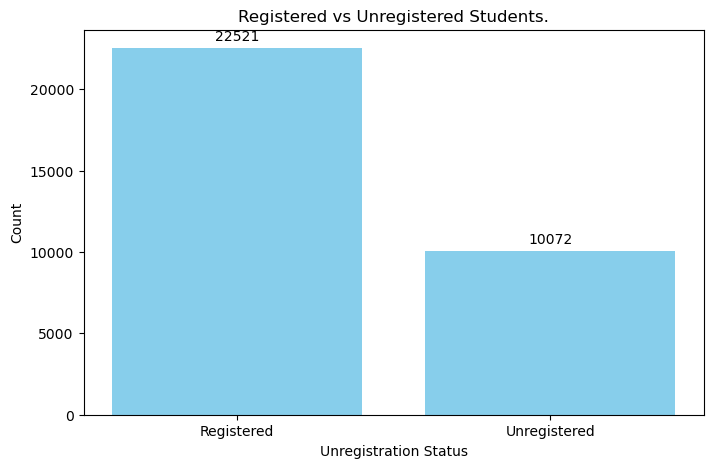

In [43]:
# Calculate missing and non-missing counts for date_unregistration.
missing_date_unreg_count = studentRegistration['date_unregistration'].isna().sum()
non_missing_date_unreg_count = studentRegistration['date_unregistration'].notna().sum()

plot_bar_with_annotations(
    categories=['Registered', 'Unregistered'],
    counts=[missing_date_unreg_count, non_missing_date_unreg_count],
    xlabel='Unregistration Status',
    ylabel='Count',
    title='Registered vs Unregistered Students.',
    rotation=0
)

About 31% (10,072) of the students (non-unique) in this dataset have unregistered.

### Data Types and Schema Overview

In [44]:
studentRegistration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [45]:
studentRegistration['id_student'] = studentRegistration['id_student'].astype(object)

### Missing Student ID Check

Let us see if all student IDs in the `StudentRegistration` tables exist in the `StudentAssessment` table.

In [46]:
# Call the function 'compare_df_cols' with the student IDs series.
compare_df_cols(studentRegistration['id_student'], studentAssessment['id_student'])

Total missing rows: 5847
Number of unique missing IDs: 5416
Missing IDs and their counts:
id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64


id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64

We observe that approximately 5,847 student records are missing from the `StudentAssessment` table, corresponding to 5,416 unique student IDs. Next, let us perform a similar check for the `StudentInfo` table.

In [47]:
compare_df_cols(studentInfo['id_student'], studentAssessment['id_student'])

Total missing rows: 5847
Number of unique missing IDs: 5416
Missing IDs and their counts:
id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64


id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64

Similarly, there are 5,847 student records (5,416 unique students) present in the `StudentInfo` table but missing from the `StudentAssessment` table. Let us continue to investigate this further.

In [48]:
# Get unique id_student.
SR_ID = studentRegistration['id_student'].unique()
SI_ID = studentInfo['id_student'].unique()

# Compare the two lists.
difference = set(SR_ID).difference(set(SI_ID))
difference = len(difference)
difference

0

The missing student IDs across `studentRegistration` and `studentInfo` are the same students

In [49]:
missing_ids = compare_df_cols(studentRegistration['id_student'], studentAssessment['id_student'])

missing_students = studentInfo[studentInfo['id_student'].isin(missing_ids.index)]
missing_students.head(10)

Total missing rows: 5847
Number of unique missing IDs: 5416
Missing IDs and their counts:
id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
44,AAA,2013J,135335,F,East Anglian Region,Lower Than A Level,20-30%,0-35,0,180,N,Withdrawn
118,AAA,2013J,281589,M,North Western Region,HE Qualification,30-40%,0-35,0,60,N,Fail
125,AAA,2013J,292923,F,South East Region,A Level or Equivalent,90-100%,35-55,0,180,N,Withdrawn
136,AAA,2013J,305539,F,Wales,Lower Than A Level,80-90%,0-35,0,120,N,Withdrawn
169,AAA,2013J,346843,F,Scotland,HE Qualification,50-60%,35-55,0,120,N,Fail
171,AAA,2013J,354858,M,South Region,HE Qualification,90-100%,35-55,0,120,N,Withdrawn
198,AAA,2013J,405961,M,Scotland,A Level or Equivalent,90-100%,0-35,0,240,Y,Withdrawn
209,AAA,2013J,494424,F,North Region,A Level or Equivalent,80-90%,0-35,0,60,N,Fail
256,AAA,2013J,1763015,F,Scotland,A Level or Equivalent,10-20,35-55,0,60,N,Withdrawn


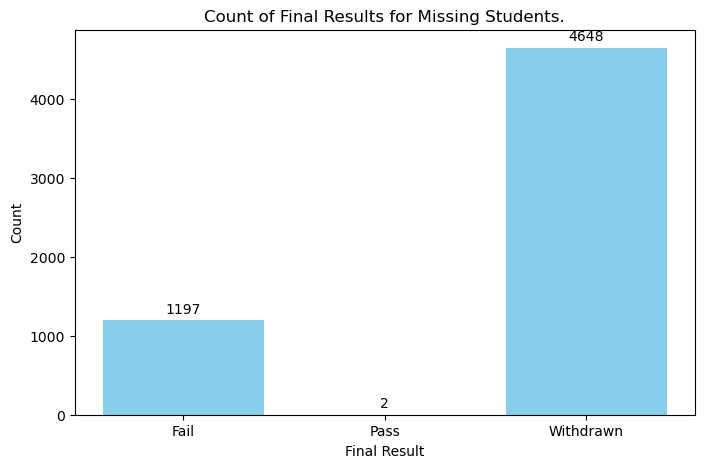

In [50]:
unique, counts = np.unique(missing_students['final_result'], return_counts = True)
dict(zip(unique, counts))

plot_bar_with_annotations(
    categories=unique,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count',
    title='Count of Final Results for Missing Students.',
    rotation=0
)

In [51]:
# Display the missing student with final result as 'Pass'.
missing_students[missing_students['final_result'] == 'Pass']

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
645,AAA,2014J,1336190,M,London Region,HE Qualification,80-90%,55<=,0,60,N,Pass
12893,CCC,2014J,1777834,F,East Anglian Region,A Level or Equivalent,80-90%,35-55,0,60,N,Pass


Most of the missing students have either withdrawn or failed, with only two having passed. This is unusual since there are two students who have no recorded submissions yet are marked as having passed their modules. This likely indicates an error in the dataset.

In [52]:
missing_students_reg = studentRegistration[studentRegistration['id_student'].isin(missing_ids.index)]
missing_students_reg.head(10)

,code_module,code_presentation,id_student,date_registration,date_unregistration
2,AAA,2013J,30268,-92.0,12.0
44,AAA,2013J,135335,-29.0,30.0
118,AAA,2013J,281589,-50.0,NaN
125,AAA,2013J,292923,-162.0,-121.0
136,AAA,2013J,305539,-54.0,-3.0
169,AAA,2013J,346843,-44.0,NaN
171,AAA,2013J,354858,-32.0,5.0
198,AAA,2013J,405961,-170.0,-100.0
209,AAA,2013J,494424,-38.0,NaN
256,AAA,2013J,1763015,-58.0,-2.0


In [53]:
missing_students_reg['date_unregistration'].notnull().sum()

4594

Another issue with this dataset is the discrepancy in the number of withdrawn students. In the `studentInfo` table, there are 4,648 students marked as withdrawn, whereas in the `studentRegistration` table, the count of students with a non-null `date_unregistration` is 4,594, resulting in a difference of 54 students without an assigned unregistered date.

In [54]:
studentRegistration[studentRegistration['id_student'] == 1336190]

,code_module,code_presentation,id_student,date_registration,date_unregistration
645,AAA,2014J,1336190,-23.0,NaN


In [55]:
studentRegistration[studentRegistration['id_student'] == 1777834]

,code_module,code_presentation,id_student,date_registration,date_unregistration
12893,CCC,2014J,1777834,NaN,NaN


The two students from the missing student list do not have a recorded unregistration date, which means they have not withdrawn.

## Student Info Table

This table provides demographic details about the students along with their academic outcomes. It includes the following columns:

* **code\_module**: A unique code representing the module the student is enrolled in.
* **code\_presentation**: The specific presentation (e.g., semester and year) during which the student is taking the module.
* **id\_student**: A unique identifier for each student.
* **gender**: The gender of the student.
* **region**: The geographic area where the student resided while taking the module.
* **highest\_education**: The highest level of education the student had completed upon starting the module.
* **imd\_band**: The Index of Multiple Deprivation band corresponding to the student's place of residence during the module.
* **age\_band**: The age range into which the student falls.
* **num\_of\_prev\_attempts**: The number of times the student has previously taken the module.
* **studied\_credits**: The total number of credits the student was enrolled in at the time.
* **disability**: Indicates whether the student declared any disabilities.
* **final\_result**: The final outcome of the student in that module presentation. This column has four categories: `Distinction`, `Pass`, `Fail` and `Withdrawn`.


In [56]:
studentInfo.head(10)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
5,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass
6,AAA,2013J,45462,M,Scotland,HE Qualification,30-40%,0-35,0,60,N,Pass
7,AAA,2013J,45642,F,North Western Region,A Level or Equivalent,90-100%,0-35,0,120,N,Pass
8,AAA,2013J,52130,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,0,90,N,Pass
9,AAA,2013J,53025,M,North Region,Post Graduate Qualification,NaN,55<=,0,60,N,Pass


In [57]:
studentInfo.describe()

,id_student,num_of_prev_attempts,studied_credits
count,3.259300e+04,32593.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691
std,5.491673e+05,0.479758,41.071900
min,3.733000e+03,0.000000,30.000000
25%,5.085730e+05,0.000000,60.000000
50%,5.903100e+05,0.000000,60.000000
75%,6.444530e+05,0.000000,120.000000
max,2.716795e+06,6.000000,655.000000


### Missing, Duplicate, and Distinct Values Overview

In [58]:
print('Total null values: \n', studentInfo.isnull().sum(), '\n')
print('Total duplicated values:', studentInfo[studentInfo.duplicated()], '\n')
print('Total unique values: \n', studentInfo.nunique())

Total null values: 
 code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, id_student, gender, region, highest_education, imd_band, age_band, num_of_prev_attempts, studied_credits, disability, final_result]
Index: [] 

Total unique values: 
 code_module                 7
code_presentation           4
id_student              28785
gender                      2
region                     13
highest_education           5
imd_band                   10
age_band                    3
num_of_prev_attempts        7
studied_credits            61
disability                  2
final_result                4
dtype:

There are 1,111 entries where the `imd_band` information is missing. Another notable observation is that although there are 32,593 student records in total, only around 28,785 of them represent unique students. This indicates that some student IDs appear multiple times, likely because those students switched to different modules or presentations.

### Data Types and Schema Overview

In [59]:
studentInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [60]:
studentInfo['id_student'] = studentInfo['id_student'].astype(object)

## VLE Table

The table provides details about the materials available in the Virtual Learning Environment (VLE). These materials typically include HTML pages, PDF documents, and similar resources. Students can access these materials online, and their interactions with them are tracked. The table contains the following columns:

* **id\_site**: a unique identifier for each material.
* **code\_module**: the code representing the module.
* **code\_presentation**: the code representing the presentation.
* **activity\_type**: the role or type associated with the module material.
* **week\_from**: the starting week when the material is intended to be used.
* **week\_to**: the ending week until which the material is planned to be available.


In [61]:
vle.head(10)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN
5,546614,AAA,2013J,homepage,NaN,NaN
6,546897,AAA,2013J,url,NaN,NaN
7,546678,AAA,2013J,oucontent,NaN,NaN
8,546933,AAA,2013J,resource,NaN,NaN
9,546708,AAA,2013J,oucontent,NaN,NaN


### Missing, Duplicate, and Distinct Values Overview

In [62]:
print('Total null values: \n', vle.isnull().sum(), '\n')
print('Total duplicated values:', vle[vle.duplicated()], '\n')
print('Total unique values: \n', vle.nunique())

Total null values: 
 id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [id_site, code_module, code_presentation, activity_type, week_from, week_to]
Index: [] 

Total unique values: 
 id_site              6364
code_module             7
code_presentation       4
activity_type          20
week_from              30
week_to                30
dtype: int64


### Data Types and Schema Overview

In [63]:
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [64]:
vle['id_site'] = vle['id_site'].astype(object)

### Check for Missing Week Data.

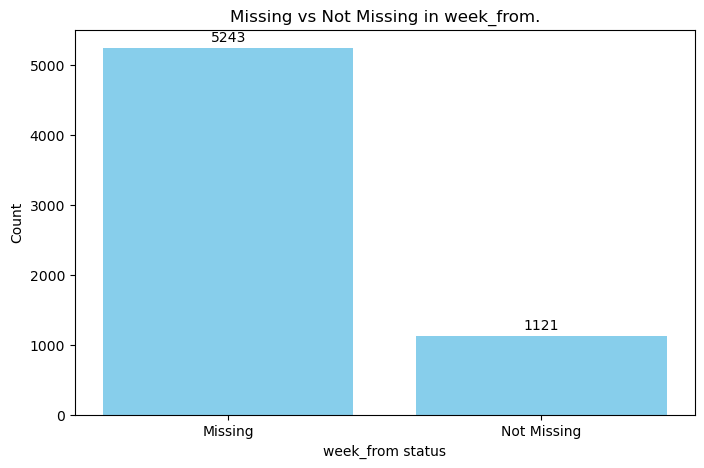

In [65]:
# Calculate missing and non-missing counts for week_from.
missing_count = vle['week_from'].isna().sum()
non_missing_count = vle['week_from'].notna().sum()

plot_bar_with_annotations(
    categories=['Missing', 'Not Missing'],
    counts=[missing_count, non_missing_count],
    xlabel='week_from status',
    ylabel='Count',
    title='Missing vs Not Missing in week_from.',
    rotation=0
)

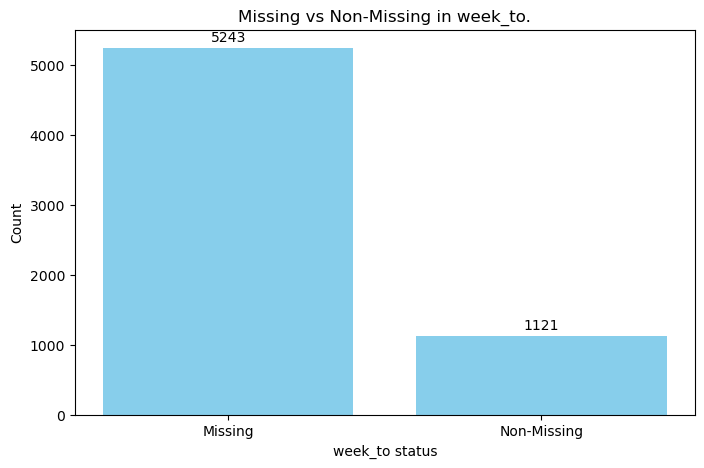

In [66]:
# Calculate missing and non-missing counts for week_to.
missing_count = vle['week_to'].isna().sum()
non_missing_count = vle['week_to'].notna().sum()

plot_bar_with_annotations(
    categories=['Missing', 'Non-Missing'],
    counts=[missing_count, non_missing_count],
    xlabel='week_to status',
    ylabel='Count',
    title='Missing vs Non-Missing in week_to.',
    rotation=0
)

A vast majority of the week data is missing from the `vle` table (about 82% missing).

In [67]:
# Get unique activity_type per code_module.
unique_activities = vle.groupby('code_module')['activity_type'].unique()
for module, activities in unique_activities.items():
    print(f"{module}: {list(activities)}")

AAA: ['resource', 'oucontent', 'url', 'homepage', 'subpage', 'glossary', 'forumng', 'oucollaborate', 'dataplus']
BBB: ['resource', 'forumng', 'subpage', 'url', 'quiz', 'ouelluminate', 'glossary', 'sharedsubpage', 'oucontent', 'homepage', 'oucollaborate', 'questionnaire']
CCC: ['subpage', 'resource', 'forumng', 'oucontent', 'url', 'page', 'quiz', 'homepage', 'oucollaborate']
DDD: ['url', 'resource', 'subpage', 'oucontent', 'externalquiz', 'homepage', 'forumng', 'ouwiki', 'ouelluminate', 'glossary', 'page', 'oucollaborate']
EEE: ['oucontent', 'resource', 'subpage', 'forumng', 'url', 'quiz', 'page', 'ouwiki', 'dualpane', 'homepage', 'oucollaborate']
FFF: ['resource', 'subpage', 'oucontent', 'url', 'quiz', 'page', 'dataplus', 'forumng', 'ouelluminate', 'ouwiki', 'questionnaire', 'dualpane', 'glossary', 'homepage', 'oucollaborate', 'repeatactivity', 'folder', 'htmlactivity']
GGG: ['oucontent', 'resource', 'subpage', 'forumng', 'quiz', 'homepage', 'glossary']


Some modeules have their own unique activity types like module FFF's 'ouwiki'.

## Student VLE Table

The `studentVle` table records how students interact with online learning materials available in the VLE. It includes the following columns:

* **code\_module**: A code identifying the module.
* **code\_presentation**: A code identifying the specific presentation of the module.
* **id\_student**: A unique ID assigned to each student.
* **id\_site**: A unique ID for each VLE resource or material.
* **date**: The day (relative to the module's start date) on which the interaction occurred.
* **sum\_click**: The total number of times the student interacted with the material on that particular day.


In [68]:
studentVle.head(10)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
5,AAA,2013J,28400,546652,-10,8
6,AAA,2013J,28400,546876,-10,2
7,AAA,2013J,28400,546688,-10,15
8,AAA,2013J,28400,546662,-10,17
9,AAA,2013J,28400,546890,-10,1


### Missing, Duplicate, and Distinct Values Overview

In [69]:
print('Total null values: \n', studentVle.isnull().sum(), '\n')
print('Total duplicated values:', studentVle[studentVle.duplicated()], '\n')
print('Total unique values: \n', studentVle.nunique())

Total null values: 
 code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64 

Total duplicated values:          code_module code_presentation  id_student  id_site  date  sum_click
2                AAA             2013J       28400   546652   -10          1
63               AAA             2013J       45462   546652   -10          1
180              AAA             2013J       77367   546652   -10          4
193              AAA             2013J       94961   546652   -10          2
442              AAA             2013J      248270   546652   -10          4
...              ...               ...         ...      ...   ...        ...
10655235         GGG             2014J      686194   897083   267          1
10655250         GGG             2014J      676071   896939   268          1
10655256         GGG             2014J      642905   896939   268          2
10655261         GGG           

This dataset contains duplicate entries, but it's not a significant concern because students may interact with the VLE multiple times in a single day. Each interaction may be recorded separately, so multiple records for the same student on the same day are expected.

### Data Types and Schema Overview

In [70]:
studentVle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [71]:
studentVle['id_student'] = studentVle['id_student'].astype(object)
studentVle['id_site'] = studentVle['id_site'].astype(object)

# Preprocess Data

We will approach this task as a classification problem aimed at predicting student academic failure or withdrawal from module presentations, using data from a selected point in time, ideally by the midpoint of the module or earlier.

To move forward, the dataset needs to be preprocessed and streamlined by extracting relevant features and performing necessary cleaning.

It is important to note that the `StudentAssessment` table has incomplete score data: every module except for DDD is missing final exam scores. Relying on this table for prediction, particularly using scores as the target variable, could reduce accuracy due to this missing information. For instance, a student might perform well in coursework but still fail the final exam, ultimately failing the module. A more consistent and complete indicator is the `final_result` column in the `studentInfo` table, which has no missing values.

Using the `score` feature to predict outcomes like 'final_result' can be somewhat redundant, as both reflect similar aspects of academic performance. A more meaningful challenge lies in identifying students at risk of failing or withdrawing based purely on early indicators, without depending on the overall assessment or exam scores. To support this, we create two versions of the student dataset: the **summarised dataset**, which includes complete information such as full assessment results and overall VLE activity, and the **custom dataset**, which limits student performance and engagement data to the module's midpoint. The custom dataset is intended for training and testing machine learning models aimed at early dropout prediction, while the summarised dataset serves for exploratory data analysis and to uncover broader behavioural and performance trends.

## Merge Tables (Summarised Version)

### `VLE` and `Student VLE` tables

In [72]:
compare_shared_columns(vle, studentVle, 'vle', 'studentVle')

Shared columns between vle and studentVle: {'id_site', 'code_presentation', 'code_module'}

=== Column: "code_module" ===
Presence of vle values in studentVle:
code_module
True    6364
Name: count, dtype: int64 

Values from vle not in studentVle: set()
Number of missing values: 0

=== Column: "code_presentation" ===
Presence of vle values in studentVle:
code_presentation
True    6364
Name: count, dtype: int64 

Values from vle not in studentVle: set()
Number of missing values: 0

=== Column: "id_site" ===
Presence of vle values in studentVle:
id_site
True     6268
False      96
Name: count, dtype: int64 

Values from vle not in studentVle: {674323, 674324, 527386, 527399, 1073191, 527404, 1027118, 924208, 924209, 924210, 924211, 546872, 924222, 924225, 877133, 546897, 547941, 551014, 1072236, 1072237, 1072239, 1072240, 1072252, 1072253, 551036, 547969, 527493, 1077905, 527506, 923834, 923835, 716987, 729799, 729803, 729805, 1032910, 729808, 936658, 936659, 551124, 924383, 729824, 9243

In [73]:
get_missing_rows(vle, studentVle, 'id_site')

,id_site,code_module,code_presentation,activity_type,week_from,week_to
6,546897,AAA,2013J,url,NaN,NaN
24,546872,AAA,2013J,subpage,NaN,NaN
222,1032910,AAA,2014J,url,NaN,NaN
285,1072237,AAA,2014J,url,NaN,NaN
292,1027118,AAA,2014J,url,NaN,NaN
...,...,...,...,...,...,...
5365,779622,FFF,2014B,subpage,NaN,NaN
5442,924222,FFF,2014B,forumng,NaN,NaN
5632,1072239,FFF,2014J,forumng,NaN,NaN
5728,883074,FFF,2014J,subpage,NaN,NaN


There are 96 "id_site" entries in the `VLE` table that do not appear in the `studentVLE` table. This likely indicates that these resources were either not accessed by any students or that no activity was recorded for them. Therefore, an inner merge between the two tables is appropriate, as resources with no recorded student interaction offer no useful information. Additionally, the "week_from" and "week_to" columns can be removed, as they are over 82% missing.

In [74]:
# Merge with an inner join.
vle_df = pd.merge(studentVle, vle, on=['code_module', 'code_presentation', 'id_site'], how='inner')
vle_df.drop(columns=['week_from', 'week_to'], inplace=True) # Drop columns.
vle_df.head(5)

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type
0,AAA,2013J,28400,546652,-10,4,forumng
1,AAA,2013J,28400,546652,-10,1,forumng
2,AAA,2013J,28400,546652,-10,1,forumng
3,AAA,2013J,28400,546614,-10,11,homepage
4,AAA,2013J,28400,546714,-10,1,oucontent


In [75]:
# Get full list of students by module/presentation.
student_keys = studentInfo[['code_module', 'code_presentation', 'id_student']].drop_duplicates()

# Aggregate total clicks and number of active days per student.
vle_agg = vle_df.groupby(['code_module', 'code_presentation', 'id_student']).agg(
    total_clicks=('sum_click', 'sum'),
    num_days_active=('date', 'nunique')
).reset_index()

# Merge with all students to retain those with no activity.
vle_agg_summarised = student_keys.merge(vle_agg, on=['code_module', 'code_presentation', 'id_student'], how='left')

# Fill missing values with 0 for students with no activity.
vle_agg_summarised[['total_clicks']] = vle_agg_summarised[['total_clicks']].fillna(0)
vle_agg_summarised[['num_days_active']] = vle_agg_summarised[['num_days_active']].fillna(0)

# Merge with module presentation length.
vle_agg_summarised = vle_agg_summarised.merge(
    courses[['code_module', 'code_presentation', 'module_presentation_length']],
    on=['code_module', 'code_presentation'],
    how='left'
)

# Normalise active days by presentation length.
vle_agg_summarised['days_active_norm'] = vle_agg_summarised['num_days_active'] / vle_agg_summarised['module_presentation_length']
vle_agg_summarised['days_active_norm'] = round(vle_agg_summarised['days_active_norm'].clip(upper=1), 2)

# Drop helper columns.
vle_agg_summarised = vle_agg_summarised.drop(columns=['num_days_active', 'module_presentation_length'])
vle_agg_summarised.head(5)

,code_module,code_presentation,id_student,total_clicks,days_active_norm
0,AAA,2013J,11391,934.0,0.15
1,AAA,2013J,28400,1435.0,0.30
2,AAA,2013J,30268,281.0,0.04
3,AAA,2013J,31604,2158.0,0.46
4,AAA,2013J,32885,1034.0,0.26


In [76]:
vle_agg_summarised[vle_agg_summarised['id_student'] == 292923]

,code_module,code_presentation,id_student,total_clicks,days_active_norm
125,AAA,2013J,292923,0.0,0.0


We calculate the total number of clicks a student has made throughout the module, along with the proportion of days the student has been active up to that point, represented as a value between 0 and 1.

In [77]:
# Build the activity click matrix.
vle_activity_ohe = pd.pivot_table(
    vle_df,
    index = ['code_module', 'code_presentation', 'id_student'],
    columns = 'activity_type',
    values = 'sum_click',
    aggfunc = 'sum',
    fill_value = 0
).reset_index()

# Merge with full student list to include students with no activity.
vle_activity_ohe_summarised = student_keys.merge(
    vle_activity_ohe, 
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

# Fill missing activity columns with 0
activity_cols = [col for col in vle_activity_ohe_summarised.columns if col not in ['code_module', 'code_presentation', 'id_student']]
vle_activity_ohe_summarised[activity_cols] = vle_activity_ohe_summarised[activity_cols].fillna(0)

vle_activity_ohe_summarised.head(5)

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,2013J,11391,0.0,0.0,0.0,0.0,193.0,0.0,138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0
1,AAA,2013J,28400,10.0,0.0,0.0,0.0,417.0,0.0,324.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0
2,AAA,2013J,30268,0.0,0.0,0.0,0.0,126.0,0.0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0
3,AAA,2013J,31604,2.0,0.0,0.0,0.0,634.0,1.0,432.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0
4,AAA,2013J,32885,0.0,0.0,0.0,0.0,194.0,4.0,204.0,...,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0


We then add the number of clicks ths students have made per activity type for richer dataset. Next, we include the number of clicks the student has made for each activity type to create a more detailed dataset.

In [78]:
# One-hot encode clicks by activity type.
vle_unique_module_activity_summarised = (
    vle_df[['code_module', 'activity_type']]
    .drop_duplicates()
    .assign(is_available=1)
    .pivot_table(index='code_module', columns='activity_type', values='is_available', fill_value=0)
).reset_index()

vle_unique_module_activity_summarised.head(5)

activity_type,code_module,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,BBB,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,CCC,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,DDD,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,EEE,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


We also recognise that some modules have unique activity types not found in others, while some activities are absent in certain modules. This leads to a challenge where modules lacking a specific activity type will show zero clicks for that activity. The issue is that the ML model might interpret this as students in that module not engaging with that activity, which is misleading since the activity simply doesn't exist for that module. To address this, we've added encoded labels for each activity type across all modules, informing the model which activities are actually present in each module.

In [79]:
vle_unique_module_activity_summarised.columns = ['code_module'] + [f"has_{col}" for col in vle_unique_module_activity_summarised.columns[1:]]

# Merge vle_unique_module_activity_summarised with vle_activity_ohe_summarised.
vle_activity_features = pd.merge(
    vle_activity_ohe_summarised,
    vle_unique_module_activity_summarised,
    on='code_module',
    how='left'
)
vle_activity_features.head(5)

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,...,has_ouelluminate,has_ouwiki,has_page,has_questionnaire,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url
0,AAA,2013J,11391,0.0,0.0,0.0,0.0,193.0,0.0,138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,AAA,2013J,28400,10.0,0.0,0.0,0.0,417.0,0.0,324.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,AAA,2013J,30268,0.0,0.0,0.0,0.0,126.0,0.0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,AAA,2013J,31604,2.0,0.0,0.0,0.0,634.0,1.0,432.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,AAA,2013J,32885,0.0,0.0,0.0,0.0,194.0,4.0,204.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [80]:
# Merge with the previously aggregated VLE dfs.
vle_df_summarised = pd.merge(
    vle_agg_summarised,  # total_clicks and num_days_active_norm.
    vle_activity_features,
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)
vle_df_summarised.head(5)

,code_module,code_presentation,id_student,total_clicks,days_active_norm,dataplus,dualpane,externalquiz,folder,forumng,...,has_ouelluminate,has_ouwiki,has_page,has_questionnaire,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url
0,AAA,2013J,11391,934.0,0.15,0.0,0.0,0.0,0.0,193.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,AAA,2013J,28400,1435.0,0.30,10.0,0.0,0.0,0.0,417.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,AAA,2013J,30268,281.0,0.04,0.0,0.0,0.0,0.0,126.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,AAA,2013J,31604,2158.0,0.46,2.0,0.0,0.0,0.0,634.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,AAA,2013J,32885,1034.0,0.26,0.0,0.0,0.0,0.0,194.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


### `Courses`, `Student Registration` and `Student Info` Tables

Next, we proceed with merging the `Courses`, `studentRegistration`, and `studentInfo` tables.

The "date_registration" column could be a valuable feature for predicting future failure or withdrawal. On one hand, early registration might indicate strong interest and a higher chance of success.

In [81]:
# Check that all module presentations in the studentRegistration table exist in the Courses table.
compare_shared_columns(studentRegistration, courses, 'studentRegistration', 'courses')

Shared columns between studentRegistration and courses: {'code_module', 'code_presentation'}

=== Column: "code_module" ===
Presence of studentRegistration values in courses:
code_module
True    32593
Name: count, dtype: int64 

Values from studentRegistration not in courses: set()
Number of missing values: 0

=== Column: "code_presentation" ===
Presence of studentRegistration values in courses:
code_presentation
True    32593
Name: count, dtype: int64 

Values from studentRegistration not in courses: set()
Number of missing values: 0



All module presentations in the `studentRegistration` table are accounted for in the `Courses` table. The length of a course could potentially be a strong predictor of withdrawal, as longer courses provide more opportunity for students to disengage and decide to drop out over time.

Let us now merge `studentRegistration` and `courses` tables. We only need the "module_presentation_length" column from the `courses` table.

In [82]:
student_reg_and_courses_df = pd.merge(studentRegistration, courses, on=['code_module', 'code_presentation'], how='inner')
student_reg_and_courses_df.head(10)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length
0,AAA,2013J,11391,-159.0,NaN,268
1,AAA,2013J,28400,-53.0,NaN,268
2,AAA,2013J,30268,-92.0,12.0,268
3,AAA,2013J,31604,-52.0,NaN,268
4,AAA,2013J,32885,-176.0,NaN,268
5,AAA,2013J,38053,-110.0,NaN,268
6,AAA,2013J,45462,-67.0,NaN,268
7,AAA,2013J,45642,-29.0,NaN,268
8,AAA,2013J,52130,-33.0,NaN,268
9,AAA,2013J,53025,-179.0,NaN,268


Next, we merge the `student_reg_and_courses_df` with the `studentInfo` table. This process integrates students' personal details, such as age, gender, highest qualification, and more, with their registration and module data.

In [83]:
student_details_df = pd.merge(student_reg_and_courses_df, studentInfo, on=['code_module', 'code_presentation', 'id_student'], how='inner')
student_details_df.head(5)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,-92.0,12.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


### `Student Assessments` and `Assessment` Tables

In [84]:
assessments[assessments['date'].isna()]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Some assessments of type 'Exam' have missing dates. According to the data specification, if the exam date is not provided, it should be assumed to occur at the end of the final presentation week. Therefore, we will fill these missing values using the module's presentation length as the exam date.

In [85]:
# Impute the missing exam dates with the module_presentation_length date.
assessments.loc[assessments['date'].isna(), 'date'] = assessments.loc[assessments['date'].isna()].merge(
    courses[['code_module', 'code_presentation', 'module_presentation_length']],
    on=['code_module', 'code_presentation'],
    how='left'
)['module_presentation_length'].values

Similar to how we merged the VLE and student data, we will merge the `assessments` and `studentAssessment` tables. These tables are connected through a one-to-many relationship based on the `id_assessment` field.

In [86]:
assessment_df = pd.merge(assessments, studentAssessment, on=['id_assessment'], how='inner')

# Rearrange column names.
assessment_df = assessment_df[['id_student', 'code_module', 'code_presentation', 'id_assessment', 'assessment_type', 'date', 'date_submitted', 'weight', 'is_banked', 'score']]
assessment_df.head(10)

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0,78.0
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0,70.0
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0,72.0
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0,69.0
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0,79.0
5,45462,AAA,2013J,1752,TMA,19.0,20,10.0,0,70.0
6,45642,AAA,2013J,1752,TMA,19.0,18,10.0,0,72.0
7,52130,AAA,2013J,1752,TMA,19.0,19,10.0,0,72.0
8,53025,AAA,2013J,1752,TMA,19.0,9,10.0,0,71.0
9,57506,AAA,2013J,1752,TMA,19.0,18,10.0,0,68.0


In [87]:
assessment_df.isnull().sum()

id_student             0
code_module            0
code_presentation      0
id_assessment          0
assessment_type        0
date                   0
date_submitted         0
weight                 0
is_banked              0
score                173
dtype: int64

#### Calculate Weighted Score

We will now create a new feature called "weighted_score" that combines the assignment score and its weight into a single weighted score.

Since most final exam results are missing from the `studentAssessment` table, we assume a default total module weight of 100 for most modules. However, for modules CCC and DDD, which have additional exams, we set the total module weight to 200.

To calculate the weighted score, we first divide each assignment's weight by the total module weight (either 100 or 200), then multiply this fraction by the assignment's score. After that, we aggregate the weighted scores by summing them for each student within each module and presentation, accounting for whether the assessment was banked or not. It is also important to note that there are 173 missing scores. Based on the data specifications, if a student does not submit an assessment, no result is recorded. In such cases, we will assume the student failed and assign a score of zero.

The function for calculting weighted_score is defined below:

weighted_score = (weight / module_total_weight) * score

In [88]:
assessment_results_df_summarised = assessment_df.copy() # Make a copy of dataset.

# Count how many exams there are in Results for every module presentation.
assessment_results_df_summarised[assessment_results_df_summarised['assessment_type'] == 'Exam'][['code_module', 'code_presentation', 'id_assessment']].groupby(['code_module', 'code_presentation']).nunique()

id_assessment
code_module code_presentation               
CCC         2014B                          1
            2014J                          1
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1

The CCC module contains results for only one exam, despite having two exams in total. The DDD module includes results for its single final exam, as expected. Based on this, all modules except CCC and DDD will have a total module weight of 100, while CCC and DDD will have a total weight of 200, as they include available exam data.

In [89]:
# Create a column for total module weight (default = 100).
assessment_results_df_summarised['module_total_weight'] = 100

# Set module_total_weight = 200 for modules CCC and DDD.
assessment_results_df_summarised.loc[assessment_results_df_summarised['code_module'].isin(['CCC', 'DDD']), 'module_total_weight'] = 200

# Calculate weighted score and round it to 2 decimal places.
assessment_results_df_summarised['weighted_score'] = round((assessment_results_df_summarised['weight'] / assessment_results_df_summarised['module_total_weight']) * 
                                                           assessment_results_df_summarised['score'], 2)

# Aggregate per student per module presentation.
assessment_results_df_summarised = assessment_results_df_summarised.groupby(['id_student', 'code_module', 'code_presentation']).agg(weighted_score=('weighted_score', 'sum')).reset_index()
assessment_results_df_summarised.head(10)

,id_student,code_module,code_presentation,weighted_score
0,6516,AAA,2014J,63.50
1,8462,DDD,2013J,17.45
2,8462,DDD,2014J,21.51
3,11391,AAA,2013J,82.40
4,23629,BBB,2013B,16.69
5,23698,CCC,2014J,74.99
6,23798,BBB,2013J,89.24
7,24186,GGG,2014B,0.00
8,24213,DDD,2014B,68.20
9,24391,GGG,2013J,0.00


It is important to mention that the columns "date," "date_submitted," and "assessment_type" have been removed for the time being. These will be reintroduced later in the process as part of new aggregated and custom versions of the data, which will make training and testing machine learning models more manageable.

#### Calculate Banked Rate

To determine how many assessments a student has banked, the most effective approach is to calculate a ratio by dividing the number of banked assessments by the total number of assessments. This results in a value between 0 and 1, where 1 indicates that all assessments were banked, and 0 means none were banked.

In [90]:
# Count total assessments per student per module presentation.
total_assessments = assessment_df.groupby(['id_student', 'code_module', 'code_presentation'])['is_banked'].count().reset_index()
total_assessments = total_assessments.rename(columns={'is_banked': 'total_assessments'})

# Count number of banked assessments (is_banked == 1).
banked_assessments = assessment_df[assessment_df['is_banked'] == 1].groupby(
    ['id_student', 'code_module', 'code_presentation'])['is_banked'].count().reset_index()
banked_assessments = banked_assessments.rename(columns={'is_banked': 'banked_assessments'})

# Merge the two.
banked_rate_df_summarised = total_assessments.merge(
    banked_assessments, 
    on=['id_student', 'code_module', 'code_presentation'], 
    how='left'
)

# Fill NaN banked counts with 0 and compute ratio.
banked_rate_df_summarised['banked_assessments'] = banked_rate_df_summarised['banked_assessments'].fillna(0)
banked_rate_df_summarised['banked_rate'] = round(banked_rate_df_summarised['banked_assessments'] / banked_rate_df_summarised['total_assessments'], 2)

# Drop helper columns.
banked_rate_df_summarised = banked_rate_df_summarised.drop(columns=['total_assessments', 'banked_assessments'])
banked_rate_df_summarised.head(5)

,id_student,code_module,code_presentation,banked_rate
0,6516,AAA,2014J,0.0
1,8462,DDD,2013J,0.0
2,8462,DDD,2014J,1.0
3,11391,AAA,2013J,0.0
4,23629,BBB,2013B,0.0


In [91]:
# Merge the banked_rate into assessment_results_df_summarised.
assessment_results_df_summarised = assessment_results_df_summarised.merge(
    banked_rate_df_summarised,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left'
)
assessment_results_df_summarised.head(5)

,id_student,code_module,code_presentation,weighted_score,banked_rate
0,6516,AAA,2014J,63.50,0.0
1,8462,DDD,2013J,17.45,0.0
2,8462,DDD,2014J,21.51,1.0
3,11391,AAA,2013J,82.40,0.0
4,23629,BBB,2013B,16.69,0.0


#### Calculate Late Submission Rate

The next step is to calculate the late submission rate for the assignments that students have submitted. 

This will be done by subtracting the submission date ("date_submitted") from the assessment or exam deadline ("date"). If the result is positive, the submission is considered late. A new feature called "late_rate" will be created to measure the proportion of late submissions for each student within a module. This rate will range from 0 to 1, where 0 means the student submitted all assessments and exams on time, and 1 means every submission was late.

In [92]:
# Rename 'date' to 'date_due'.
assessment_df = assessment_df.rename(columns={'date': 'date_due'})

If a student's exam result is missing, it indicates that their assessment outcome wasn't recorded in the `studentAssessment` table, as outlined in the dataset documentation.

In [93]:
late_submission_df = assessment_df.copy()
late_submission_df[(late_submission_df['assessment_type'] == 'Exam') & (late_submission_df['date_submitted'] > late_submission_df['date_due'])]

,id_student,code_module,code_presentation,id_assessment,assessment_type,date_due,date_submitted,weight,is_banked,score
52975,577245,CCC,2014B,24290,Exam,241.0,243,100.0,0,34.0
53404,169380,CCC,2014B,24290,Exam,241.0,242,100.0,0,78.0
53661,555008,CCC,2014B,24290,Exam,241.0,266,100.0,0,56.0
65108,555498,CCC,2014J,24299,Exam,269.0,285,100.0,0,58.0
74900,81351,DDD,2013B,25340,Exam,240.0,248,100.0,0,0.0
75194,532491,DDD,2013B,25340,Exam,240.0,241,100.0,0,49.0
75221,538611,DDD,2013B,25340,Exam,240.0,241,100.0,0,51.0
75282,548535,DDD,2013B,25340,Exam,240.0,241,100.0,0,60.0
87510,391924,DDD,2014B,25361,Exam,241.0,251,100.0,0,69.0
87861,631388,DDD,2014B,25361,Exam,241.0,242,100.0,0,78.0


There are also a few exams with recorded submission deadlines, including some marked as "late submissions." However, there are only twelve such cases, which are likely either errors or situations where students were granted extensions due to personal reasons like health. Most of these late submissions occurred just one day after the deadline. Despite this, we will still consider these cases as "late submissions." Let us now calculate the late rate.

In [94]:
# Calculate late submission: submission is late if date_submitted > date_due, and date_due is not missing.
late_submission_df['late_submission'] = ((late_submission_df['date_submitted'] > late_submission_df['date_due']) & late_submission_df['date_due'].notna())

# Group to get total late submissions per student/module.
late_counts = late_submission_df.groupby(['id_student', 'code_module', 'code_presentation'])['late_submission'].sum().reset_index(name='late_count')

# Get total assessments submitted per student/module.
total_per_student_submission_counts = late_submission_df.groupby(['id_student', 'code_module', 'code_presentation']).size().reset_index(name='total_submitted')
late_rate_df = pd.merge(late_counts, total_per_student_submission_counts, on=['id_student', 'code_module', 'code_presentation']) # Merge the late counts and total counts dfs.
late_rate_df['late_rate'] = round(late_rate_df['late_count'] / late_rate_df['total_submitted'], 2) # Calculate late submission rate and round it to 2 decimal places.

late_rate_df.drop(columns=['late_count', 'total_submitted'], inplace=True) # Drop helper columns.
late_rate_df.head(10)

,id_student,code_module,code_presentation,late_rate
0,6516,AAA,2014J,0.00
1,8462,DDD,2013J,0.33
2,8462,DDD,2014J,0.00
3,11391,AAA,2013J,0.00
4,23629,BBB,2013B,0.75
5,23698,CCC,2014J,0.44
6,23798,BBB,2013J,0.45
7,24186,GGG,2014B,0.00
8,24213,DDD,2014B,0.71
9,24391,GGG,2013J,0.00


#### Fail rate

The process for calculating the fail rate follows a similar approach. According to the data specifications, a score below 40 is considered a fail. Additionally, any missing scores will also be treated as fails since the student did not submit the assessment. The fail rate is determined by dividing the number of failed assessments or exams by the total number of assessments or exams.

In [95]:
# fail_df = assessment_df.copy()

# # Mark assignments as failed if score is below 40 or NaN.
# fail_df['fail'] = (fail_df['score'] < 40) | (fail_df['score'].isna())

# # Calculate total fails per student/module.
# total_per_student_fail_counts = fail_df.groupby(['id_student', 'code_module', 'code_presentation'])['fail'].sum().reset_index(name='total_fails')

# # Merge total fails with total assessments per student/module.
# fail_rate_df = pd.merge(total_per_student_fail_counts, total_per_student_submission_counts, on=['id_student', 'code_module', 'code_presentation'])

# # Calculate fail rate and clean up.
# fail_rate_df['fail_rate'] = round(fail_rate_df['total_fails'] / fail_rate_df['total_submitted'], 2)
# fail_rate_df = fail_rate_df.drop(columns=['total_fails', 'total_submitted'])
# fail_rate_df.head(10)

In [96]:
students_in_module_summarised = assessment_df[['id_student', 'code_module', 'code_presentation']].drop_duplicates()
all_assessments_summarised = assessment_df[['id_assessment', 'code_module', 'code_presentation']].drop_duplicates()
rows = []

# Iterate over each module/presentation group separately.
for (module, presentation), students_grp in students_in_module_summarised.groupby(['code_module', 'code_presentation']):
    assessments_grp = all_assessments_summarised[
        (all_assessments_summarised['code_module'] == module) & 
        (all_assessments_summarised['code_presentation'] == presentation)
    ]
    
    for student, assessment in itertools.product(students_grp['id_student'], assessments_grp['id_assessment']):
        rows.append({
            'code_module': module,
            'code_presentation': presentation,
            'id_student': student,
            'id_assessment': assessment
        })

cartesian_df_summarised = pd.DataFrame(rows)

# Merge the full student assessment pairs with actual scores (NaN means not submitted).
merged_student_assessment_pairs = cartesian_df_summarised.merge(
    assessment_df[['id_student', 'id_assessment', 'score']],
    on=['id_student', 'id_assessment'],
    how='left'
)

# Mark fail if score < 40 or score is missing (NaN).
merged_student_assessment_pairs['fail'] = merged_student_assessment_pairs['score'].isna() | (merged_student_assessment_pairs['score'] < 40)

# Calculate fail counts and total assessments per student/module.
fail_rate_df = merged_student_assessment_pairs.groupby(['id_student', 'code_module', 'code_presentation']).agg(
    total_assessments=('fail', 'count'),
    total_fails=('fail', 'sum')
).reset_index()

# Calculate fail rate.
fail_rate_df['fail_rate'] = (fail_rate_df['total_fails'] / fail_rate_df['total_assessments']).round(2)
fail_rate_df = fail_rate_df.drop(columns=['total_assessments', 'total_fails'])
fail_rate_df.head(5)

,id_student,code_module,code_presentation,fail_rate
0,6516,AAA,2014J,0.00
1,8462,DDD,2013J,0.57
2,8462,DDD,2014J,0.43
3,11391,AAA,2013J,0.00
4,23629,BBB,2013B,0.64


In [97]:
fail_rate_df[fail_rate_df['id_student'] == 26734]

,id_student,code_module,code_presentation,fail_rate
21,26734,BBB,2014J,0.4


#### Merge Assessment Tables (Summarised)

Now we merge the dataframes `assessment_results_df`, `late_rate_df` and `fail_rate_df` into one dataframe called `student_assessments_df`.

In [98]:
student_assessments_df_summarised = pd.merge(assessment_results_df_summarised, late_rate_df, on=['id_student', 'code_module', 'code_presentation'], how='inner')
student_assessments_df_summarised = pd.merge(student_assessments_df_summarised, fail_rate_df, on=['id_student', 'code_module', 'code_presentation'], how='inner')
student_assessments_df_summarised.head(10)

,id_student,code_module,code_presentation,weighted_score,banked_rate,late_rate,fail_rate
0,6516,AAA,2014J,63.50,0.0,0.00,0.00
1,8462,DDD,2013J,17.45,0.0,0.33,0.57
2,8462,DDD,2014J,21.51,1.0,0.00,0.43
3,11391,AAA,2013J,82.40,0.0,0.00,0.00
4,23629,BBB,2013B,16.69,0.0,0.75,0.64
5,23698,CCC,2014J,74.99,0.0,0.44,0.00
6,23798,BBB,2013J,89.24,0.0,0.45,0.00
7,24186,GGG,2014B,0.00,0.0,0.00,0.11
8,24213,DDD,2014B,68.20,0.0,0.71,0.00
9,24391,GGG,2013J,0.00,0.0,0.00,0.00


### Merge All Tables (Summarised)

The following dataframes have been created previously:

* `studentVle` and `VLE` merged into `student_vle_df`
* `courses`, `studentRegistration`, and `studentInfo` merged into `student_details_df`
* `studentAssessment` and `assessments` merged into `student_assessments_df`

We will now combine `student_vle_df`, `student_details_df`, and `student_assessments_df` into a single dataframe called `student_df_summarised`.

In [99]:
student_df_summarised = pd.merge(student_details_df, vle_df_summarised, on=['id_student', 'code_module', 'code_presentation'], how='left')
student_df_summarised = pd.merge(student_df_summarised, student_assessments_df_summarised, on=['id_student', 'code_module', 'code_presentation'], how='left')
student_df_summarised.head(10)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,weighted_score,banked_rate,late_rate,fail_rate
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,...,0.0,0.0,1.0,0.0,1.0,1.0,82.4,0.0,0.0,0.0
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,...,0.0,0.0,1.0,0.0,1.0,1.0,65.4,0.0,0.4,0.0
2,AAA,2013J,30268,-92.0,12.0,268,F,North Western Region,A Level or Equivalent,30-40%,...,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN
3,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,...,0.0,0.0,1.0,0.0,1.0,1.0,76.3,0.0,0.0,0.0
4,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,...,0.0,0.0,1.0,0.0,1.0,1.0,55.0,0.0,1.0,0.4
5,AAA,2013J,38053,-110.0,NaN,268,M,Wales,A Level or Equivalent,80-90%,...,0.0,0.0,1.0,0.0,1.0,1.0,66.9,0.0,0.2,0.0
6,AAA,2013J,45462,-67.0,NaN,268,M,Scotland,HE Qualification,30-40%,...,0.0,0.0,1.0,0.0,1.0,1.0,67.8,0.0,0.4,0.0
7,AAA,2013J,45642,-29.0,NaN,268,F,North Western Region,A Level or Equivalent,90-100%,...,0.0,0.0,1.0,0.0,1.0,1.0,72.5,0.0,0.4,0.0
8,AAA,2013J,52130,-33.0,NaN,268,F,East Anglian Region,A Level or Equivalent,70-80%,...,0.0,0.0,1.0,0.0,1.0,1.0,71.2,0.0,0.2,0.0
9,AAA,2013J,53025,-179.0,NaN,268,M,North Region,Post Graduate Qualification,NaN,...,0.0,0.0,1.0,0.0,1.0,1.0,79.0,0.0,0.0,0.0


## Merge Tables (Custom Version)

The custom dataset mirrors the structure of the summarised dataset, with the key distinction being that it only includes data available up to the midpoint of each module. This time-constrained version is specifically designed for training and testing machine learning models, aligning with our goal of predicting student dropouts at an early stage. In contrast, the full summarised dataset will be used primarily for exploratory data analysis (EDA) and to observe broader trends and patterns across the student population.

### `VLE` and `Student VLE` tables

This part will record the VLE activity until the midpoint of the module.

In [100]:
# Get module midpoints.
module_midpoints = courses.copy()
module_midpoints['midpoint'] = module_midpoints['module_presentation_length'] // 2
module_midpoints

,code_module,code_presentation,module_presentation_length,midpoint
0,AAA,2013J,268,134
1,AAA,2014J,269,134
2,BBB,2013J,268,134
3,BBB,2014J,262,131
4,BBB,2013B,240,120
5,BBB,2014B,234,117
6,CCC,2014J,269,134
7,CCC,2014B,241,120
8,DDD,2013J,261,130
9,DDD,2014J,262,131


In [101]:
# Filter VLE and assessments.
# Filter rows where date is <= midpoint
vle_df_custom = vle_df.merge(module_midpoints[['code_module', 'code_presentation', 'midpoint']], on=['code_module', 'code_presentation'], how='left')
vle_df_custom = vle_df_custom[vle_df_custom['date'] <= vle_df_custom['midpoint']]
vle_df_custom.head(5)

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,midpoint
0,AAA,2013J,28400,546652,-10,4,forumng,134
1,AAA,2013J,28400,546652,-10,1,forumng,134
2,AAA,2013J,28400,546652,-10,1,forumng,134
3,AAA,2013J,28400,546614,-10,11,homepage,134
4,AAA,2013J,28400,546714,-10,1,oucontent,134


In [102]:
# Aggregate total clicks and active days.
vle_agg_custom = vle_df_custom.groupby(['code_module', 'code_presentation', 'id_student']).agg(
    total_clicks=('sum_click', 'sum'),
    num_days_active=('date', 'nunique'),
).reset_index()

# Add midpoint again.
vle_agg_custom = vle_agg_custom.merge(
    module_midpoints[['code_module', 'code_presentation', 'midpoint']], 
    on=['code_module', 'code_presentation'], 
    how='left'
)

# Normalize active days.
vle_agg_custom['days_active_norm'] = vle_agg_custom['num_days_active'] / vle_agg_custom['midpoint']
vle_agg_custom['days_active_norm'] = round(vle_agg_custom['days_active_norm'].clip(upper=1), 2)
vle_agg_custom = vle_agg_custom.drop(columns=['midpoint', 'num_days_active'])

# Merge with all students to include those with 0 VLE.
vle_agg_custom = student_keys.merge(vle_agg_custom, on=['code_module', 'code_presentation', 'id_student'], how='left')

# Fill NaNs for students with no activity.
vle_agg_custom['total_clicks'] = vle_agg_custom['total_clicks'].fillna(0)
vle_agg_custom['days_active_norm'] = vle_agg_custom['days_active_norm'].fillna(0)
vle_agg_custom.head(5)

,code_module,code_presentation,id_student,total_clicks,days_active_norm
0,AAA,2013J,11391,710.0,0.22
1,AAA,2013J,28400,986.0,0.37
2,AAA,2013J,30268,281.0,0.09
3,AAA,2013J,31604,1382.0,0.56
4,AAA,2013J,32885,799.0,0.35


In [103]:
vle_agg_custom[vle_agg_custom['id_student'] == 292923]

,code_module,code_presentation,id_student,total_clicks,days_active_norm
125,AAA,2013J,292923,0.0,0.0


We calculate the total number of clicks a student has made up to the midpoint or a custom cutoff, along with the proportion of days the student has been active up to that point, represented as a value between 0 and 1.

In [104]:
# Build the activity click matrix.
vle_activity_ohe_custom = pd.pivot_table(
    vle_df_custom,
    index = ['code_module', 'code_presentation', 'id_student'],
    columns = 'activity_type',
    values = 'sum_click',
    aggfunc = 'sum',
    fill_value = 0
).reset_index()

# Make sure students with no activity are included.
vle_activity_ohe_custom = student_keys.merge(
    vle_activity_ohe_custom,
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

# Fill missing click values with 0
activity_cols = [col for col in vle_activity_ohe_custom.columns if col not in ['code_module', 'code_presentation', 'id_student']]
vle_activity_ohe_custom[activity_cols] = vle_activity_ohe_custom[activity_cols].fillna(0)

vle_activity_ohe_custom.head(5)

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,2013J,11391,0.0,0.0,0.0,146.0,0.0,106.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,27.0,2.0
1,AAA,2013J,28400,3.0,0.0,0.0,333.0,0.0,234.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,75.0,43.0
2,AAA,2013J,30268,0.0,0.0,0.0,126.0,0.0,59.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0
3,AAA,2013J,31604,0.0,0.0,0.0,358.0,1.0,297.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,105.0,61.0
4,AAA,2013J,32885,0.0,0.0,0.0,162.0,2.0,152.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,42.0,8.0


We then add the number of clicks ths students have made per activity type for richer dataset. Next, we include the number of clicks the student has made for each activity type to create a more detailed dataset.

In [105]:
# One-hot encode clicks by activity type.
vle_unique_module_activity_custom = (
    vle_df_custom[['code_module', 'activity_type']]
    .drop_duplicates()
    .assign(is_available=1)
    .pivot_table(index='code_module', columns='activity_type', values='is_available', fill_value=0)
).reset_index()

vle_unique_module_activity_custom.head(5)

activity_type,code_module,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,BBB,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,CCC,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,DDD,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,EEE,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


In [106]:
vle_unique_module_activity_custom.columns = ['code_module'] + [f"has_{col}" for col in vle_unique_module_activity_custom.columns[1:]]

# Get full list of activity types from the original (unfiltered) VLE.
all_activity_types = sorted(vle['activity_type'].unique())

# Ensure all activity columns exist in the activity click matrix.
for col in all_activity_types:
    if col not in vle_activity_ohe_custom.columns:
        vle_activity_ohe_custom[col] = 0

# Ensure all has_* columns exist in has_activity matrix.
for col in all_activity_types:
    col_name = f'has_{col}'
    if col_name not in vle_unique_module_activity_custom.columns:
        vle_unique_module_activity_custom[col_name] = 0 

# Merge vle_unique_module_activity_custom with vle_activity_ohe_custom.
vle_activity_features_custom = pd.merge(
    vle_activity_ohe_custom,
    vle_unique_module_activity_custom,
    on='code_module',
    how='left'
)

vle_activity_features_custom.head(5)

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,...,has_ouwiki,has_page,has_questionnaire,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,has_folder
0,AAA,2013J,11391,0.0,0.0,0.0,146.0,0.0,106.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0
1,AAA,2013J,28400,3.0,0.0,0.0,333.0,0.0,234.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0
2,AAA,2013J,30268,0.0,0.0,0.0,126.0,0.0,59.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0
3,AAA,2013J,31604,0.0,0.0,0.0,358.0,1.0,297.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0
4,AAA,2013J,32885,0.0,0.0,0.0,162.0,2.0,152.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0


In [107]:
# Merge with the previously aggregated VLE dfs.
vle_df_custom = pd.merge(
    vle_agg_custom,  # total_clicks and num_days_active_norm
    vle_activity_features_custom,
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

vle_df_custom.head(5)

,code_module,code_presentation,id_student,total_clicks,days_active_norm,dataplus,dualpane,externalquiz,forumng,glossary,...,has_ouwiki,has_page,has_questionnaire,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,has_folder
0,AAA,2013J,11391,710.0,0.22,0.0,0.0,0.0,146.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0
1,AAA,2013J,28400,986.0,0.37,3.0,0.0,0.0,333.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0
2,AAA,2013J,30268,281.0,0.09,0.0,0.0,0.0,126.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0
3,AAA,2013J,31604,1382.0,0.56,0.0,0.0,0.0,358.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0
4,AAA,2013J,32885,799.0,0.35,0.0,0.0,0.0,162.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0


### `Courses`, `Student Registration` and `Student Info` Tables

This dataset has already been processed earlier in the summarised dataset version. As it doesn't include any time-series data, it will remain unchanged for the custom version as well.

In [108]:
student_details_df.head(5)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,-92.0,12.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


### `Student Assessments` and `Assessment` Tables

In [109]:
# Filter rows where date_due is <= midpoint.
assessment_df_custom = assessment_df.merge(module_midpoints[['code_module', 'code_presentation', 'midpoint']], on=['code_module', 'code_presentation'], how='left')
assessment_df_custom = assessment_df_custom[assessment_df_custom['date_due'] <= assessment_df_custom['midpoint']]
assessment_df_custom.head(5)

,id_student,code_module,code_presentation,id_assessment,assessment_type,date_due,date_submitted,weight,is_banked,score,midpoint
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0,78.0,134
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0,70.0,134
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0,72.0,134
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0,69.0,134
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0,79.0,134


#### Calculate Weighted Score

The weighted score is computed by multiplying each assessment’s score by its corresponding weight, but only for assessments submitted before the midpoint. This total is then divided by the sum of the weights for just those completed assessments. This method offers a more realistic and time-sensitive measure of performance, focusing solely on what the student has accomplished so far. It also avoids unfairly penalising students by excluding future assessments they haven’t yet attempted, rather than assuming poor performance on them.

In [110]:
# assessment_results_df_custom = assessment_df_custom.copy() # Make a copy of dataset.
# assessment_results_df_custom.head(5)

# # Total weight of assessments attempted by each student so far.
# assessment_weights_totals_custom = assessment_results_df_custom.groupby(['id_student', 'code_module', 'code_presentation']
# )['weight'].sum().reset_index().rename(columns={'weight': 'total_weight_so_far'})

# # Merge back to get each assessment's contribution to completed weight.
# assessment_results_df_custom = assessment_results_df_custom.merge(
#     assessment_weights_totals_custom,
#     on=['id_student', 'code_module', 'code_presentation'],
#     how='left'
# )

# # Compute weighted score per assessment (normalised over assessments done so far).
# assessment_results_df_custom['weighted_score'] = (
#     (assessment_results_df_custom['weight'] / assessment_results_df_custom['total_weight_so_far']) *
#     assessment_results_df_custom['score']
# )

# # Group again to get total score (normalised out of 100).
# assessment_results_df_custom = assessment_results_df_custom.groupby(['id_student', 'code_module', 'code_presentation'])['weighted_score'].sum().reset_index()

# assessment_results_df_custom['weighted_score'] = assessment_results_df_custom['weighted_score'].round(2)
# assessment_results_df_custom.head(5)

In [111]:
# For each assessment due before timestamp.
assessment_due = assessment_df_custom[['code_module', 'code_presentation', 'id_assessment', 'weight', 'assessment_type', 'date_due']].drop_duplicates()

# Cross join students and assessments by module/presentation.
students_assessments = student_keys.merge(assessment_due, on=['code_module', 'code_presentation'], how='left')

# Merge with actual student submissions.
students_assessments = students_assessments.merge(
    studentAssessment[['id_student', 'id_assessment', 'date_submitted', 'is_banked', 'score']],
    on=['id_student', 'id_assessment'],
    how='left'
)

# Fill missing scores with 0 (for not submitted).
students_assessments['score'] = students_assessments['score'].fillna(0)

# Compute total weight per student/module (based on all assessments that were due)
total_weight_df = students_assessments.groupby(['id_student', 'code_module', 'code_presentation'])['weight'].sum().reset_index(name='total_weight')

# Merge total weight back.
students_assessments = students_assessments.merge(total_weight_df, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Compute weighted score per assessment.
students_assessments['weighted_score_component'] = (
    (students_assessments['weight'] / students_assessments['total_weight']) *
    students_assessments['score']
)

# Final weighted score per student/module.
assessment_results_df_custom = students_assessments.groupby(['id_student', 'code_module', 'code_presentation'])['weighted_score_component'].sum().reset_index(name='weighted_score')
assessment_results_df_custom['weighted_score'] = assessment_results_df_custom['weighted_score'].round(2)
assessment_results_df_custom.head(5)


,id_student,code_module,code_presentation,weighted_score
0,3733,DDD,2013J,0.00
1,6516,AAA,2014J,56.40
2,8462,DDD,2013J,58.17
3,8462,DDD,2014J,86.00
4,11391,AAA,2013J,81.60


#### Calculate Banked Rate

This calcultes the banked Rate of assessments before the midpoint of the module.

In [112]:
# Count total assessments per student per module presentation.
total_assessments_custom = assessment_df_custom.groupby(['id_student', 'code_module', 'code_presentation'])['is_banked'].count().reset_index()
total_assessments_custom = total_assessments_custom.rename(columns={'is_banked': 'total_assessments_custom'})

# Count number of banked assessments (is_banked == 1).
banked_assessments = assessment_df_custom[assessment_df_custom['is_banked'] == 1].groupby(
    ['id_student', 'code_module', 'code_presentation'])['is_banked'].count().reset_index()
banked_assessments = banked_assessments.rename(columns={'is_banked': 'banked_assessments'})

# Merge the two.
banked_rate_df_custom = total_assessments_custom.merge(
    banked_assessments, 
    on=['id_student', 'code_module', 'code_presentation'], 
    how='left'
)

# Fill NaN banked counts with 0 and compute ratio.
banked_rate_df_custom['banked_assessments'] = banked_rate_df_custom['banked_assessments'].fillna(0)
banked_rate_df_custom['banked_rate'] = round(banked_rate_df_custom['banked_assessments'] / banked_rate_df_custom['total_assessments_custom'], 2)

# Drop helper columns.
banked_rate_df_custom = banked_rate_df_custom.drop(columns=['total_assessments_custom', 'banked_assessments'])
banked_rate_df_custom.head(5)

,id_student,code_module,code_presentation,banked_rate
0,6516,AAA,2014J,0.0
1,8462,DDD,2013J,0.0
2,8462,DDD,2014J,1.0
3,11391,AAA,2013J,0.0
4,23629,BBB,2013B,0.0


In [113]:
# Merge the banked_rate into assessment_results_df_custom.
assessment_results_df_custom = assessment_results_df_custom.merge(
    banked_rate_df_custom,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left'
)
assessment_results_df_custom.head(5)

,id_student,code_module,code_presentation,weighted_score,banked_rate
0,3733,DDD,2013J,0.00,NaN
1,6516,AAA,2014J,56.40,0.0
2,8462,DDD,2013J,58.17,0.0
3,8462,DDD,2014J,86.00,1.0
4,11391,AAA,2013J,81.60,0.0


#### Calculate Late Submission Rate

This calcultes the late submission rate of assessments before the midpoint of the module.

In [114]:
late_submission_df_custom = assessment_df_custom.copy()
late_submission_df_custom[(late_submission_df_custom['assessment_type'] == 'Exam') & (late_submission_df_custom['date_submitted'] > late_submission_df_custom['date_due'])]

# Calculate late submission: submission is late if date_submitted > date_due, and date_due is not missing.
late_submission_df_custom['late_submission'] = ((late_submission_df_custom['date_submitted'] > late_submission_df_custom['date_due']) & late_submission_df_custom['date_due'].notna())

# Group to get total late submissions per student/module.
late_counts = late_submission_df_custom.groupby(['id_student', 'code_module', 'code_presentation'])['late_submission'].sum().reset_index(name='late_count')

# Get total assessments submitted per student/module.
total_per_student_submission_counts_custom = late_submission_df_custom.groupby(['id_student', 'code_module', 'code_presentation']).size().reset_index(name='total_submitted')
late_rate_df_custom = pd.merge(late_counts, total_per_student_submission_counts_custom, on=['id_student', 'code_module', 'code_presentation']) # Merge the late counts and total counts dfs.
late_rate_df_custom['late_rate'] = round(late_rate_df_custom['late_count'] / late_rate_df_custom['total_submitted'], 2) # Calculate late submission rate and round it to 2 decimal places.

late_rate_df_custom.drop(columns=['late_count', 'total_submitted'], inplace=True) # Drop helper columns.
late_rate_df_custom.head(10)

,id_student,code_module,code_presentation,late_rate
0,6516,AAA,2014J,0.00
1,8462,DDD,2013J,0.33
2,8462,DDD,2014J,0.00
3,11391,AAA,2013J,0.00
4,23629,BBB,2013B,0.75
5,23698,CCC,2014J,0.50
6,23798,BBB,2013J,0.43
7,24186,GGG,2014B,0.00
8,24213,DDD,2014B,0.75
9,24391,GGG,2013J,0.00


#### Calculate Fail Rate

This calcultes the fail rate of assessments before the midpoint of the module.

In [115]:
# fail_df_custom = assessment_df_custom.copy()

# # Mark assignments as failed if score is below 40 or NaN.
# fail_df_custom['fail'] = (fail_df_custom['score'] < 40) | (fail_df_custom['score'].isna())

# # Calculate total fails per student/module.
# total_per_student_fail_counts_custom = fail_df_custom.groupby(['id_student', 'code_module', 'code_presentation'])['fail'].sum().reset_index(name='total_fails')

# # Merge total fails with total assessments per student/module.
# fail_rate_df_custom = pd.merge(total_per_student_fail_counts_custom, total_per_student_submission_counts, on=['id_student', 'code_module', 'code_presentation'])

# # Calculate fail rate and clean up.
# fail_rate_df_custom['fail_rate'] = round(fail_rate_df_custom['total_fails'] / fail_rate_df_custom['total_submitted'], 2)
# fail_rate_df_custom = fail_rate_df_custom.drop(columns=['total_fails', 'total_submitted'])
# fail_rate_df_custom.head(10)

In [116]:
students_in_module_custom = assessment_df_custom[['id_student', 'code_module', 'code_presentation']].drop_duplicates()
all_assessments_custom = assessment_df_custom[['id_assessment', 'code_module', 'code_presentation']].drop_duplicates()
rows = []

# Iterate over each module/presentation group separately.
for (module, presentation), students_grp in students_in_module_custom.groupby(['code_module', 'code_presentation']):
    assessments_grp = all_assessments_custom[
        (all_assessments_custom['code_module'] == module) & 
        (all_assessments_custom['code_presentation'] == presentation)
    ]
    
    for student, assessment in itertools.product(students_grp['id_student'], assessments_grp['id_assessment']):
        rows.append({
            'code_module': module,
            'code_presentation': presentation,
            'id_student': student,
            'id_assessment': assessment
        })

cartesian_df_custom = pd.DataFrame(rows)

# Merge the full student assessment pairs with actual scores (NaN means not submitted).
merged_student_assessment_pairs = cartesian_df_custom.merge(
    assessment_df_custom[['id_student', 'id_assessment', 'score']],
    on=['id_student', 'id_assessment'],
    how='left'
)

# Mark fail if score < 40 or score is missing (NaN).
merged_student_assessment_pairs['fail'] = merged_student_assessment_pairs['score'].isna() | (merged_student_assessment_pairs['score'] < 40)

# Calculate fail counts and total assessments per student/module.
fail_rate_df_custom = merged_student_assessment_pairs.groupby(['id_student', 'code_module', 'code_presentation']).agg(
    total_assessments=('fail', 'count'),
    total_fails=('fail', 'sum')
).reset_index()

# Calculate fail rate.
fail_rate_df_custom['fail_rate'] = (fail_rate_df_custom['total_fails'] / fail_rate_df_custom['total_assessments']).round(2)
fail_rate_df_custom = fail_rate_df_custom.drop(columns=['total_assessments', 'total_fails'])
fail_rate_df_custom.head(5)

,id_student,code_module,code_presentation,fail_rate
0,6516,AAA,2014J,0.00
1,8462,DDD,2013J,0.25
2,8462,DDD,2014J,0.00
3,11391,AAA,2013J,0.00
4,23629,BBB,2013B,0.20


In [117]:
fail_rate_df_custom[fail_rate_df_custom['id_student'] == 26734]

,id_student,code_module,code_presentation,fail_rate
21,26734,BBB,2014J,0.0


#### Merge Assessment Tables (Custom)

In [118]:
student_assessments_df_custom = pd.merge(assessment_results_df_custom, late_rate_df_custom, on=['id_student', 'code_module', 'code_presentation'], how='inner')
student_assessments_df_custom = pd.merge(student_assessments_df_custom, fail_rate_df_custom, on=['id_student', 'code_module', 'code_presentation'], how='inner')
student_assessments_df_custom.head(10)

,id_student,code_module,code_presentation,weighted_score,banked_rate,late_rate,fail_rate
0,6516,AAA,2014J,56.40,0.0,0.00,0.00
1,8462,DDD,2013J,58.17,0.0,0.33,0.25
2,8462,DDD,2014J,86.00,1.0,0.00,0.00
3,11391,AAA,2013J,81.60,0.0,0.00,0.00
4,23629,BBB,2013B,38.81,0.0,0.75,0.20
5,23698,CCC,2014J,74.32,0.0,0.50,0.00
6,23798,BBB,2013J,89.61,0.0,0.43,0.00
7,24186,GGG,2014B,0.00,0.0,0.00,0.50
8,24213,DDD,2014B,79.67,0.0,0.75,0.00
9,24391,GGG,2013J,0.00,0.0,0.00,0.00


### Merge All Tables (Custom)

In [119]:
student_df_custom = pd.merge(student_details_df, vle_df_custom, on=['id_student', 'code_module', 'code_presentation'], how='left')
student_df_custom = pd.merge(student_df_custom, student_assessments_df_custom, on=['id_student', 'code_module', 'code_presentation'], how='left')
student_df_custom.head(10)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,has_folder,weighted_score,banked_rate,late_rate,fail_rate
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,...,0.0,1.0,0.0,1.0,1.0,0,81.6,0.0,0.00,0.00
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,...,0.0,1.0,0.0,1.0,1.0,0,69.2,0.0,0.67,0.00
2,AAA,2013J,30268,-92.0,12.0,268,F,North Western Region,A Level or Equivalent,30-40%,...,0.0,1.0,0.0,1.0,1.0,0,NaN,NaN,NaN,NaN
3,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,...,0.0,1.0,0.0,1.0,1.0,0,72.4,0.0,0.00,0.00
4,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,...,0.0,1.0,0.0,1.0,1.0,0,51.0,0.0,1.00,0.33
5,AAA,2013J,38053,-110.0,NaN,268,M,Wales,A Level or Equivalent,80-90%,...,0.0,1.0,0.0,1.0,1.0,0,73.0,0.0,0.33,0.00
6,AAA,2013J,45462,-67.0,NaN,268,M,Scotland,HE Qualification,30-40%,...,0.0,1.0,0.0,1.0,1.0,0,64.8,0.0,0.33,0.00
7,AAA,2013J,45642,-29.0,NaN,268,F,North Western Region,A Level or Equivalent,90-100%,...,0.0,1.0,0.0,1.0,1.0,0,72.0,0.0,0.33,0.00
8,AAA,2013J,52130,-33.0,NaN,268,F,East Anglian Region,A Level or Equivalent,70-80%,...,0.0,1.0,0.0,1.0,1.0,0,71.6,0.0,0.00,0.00
9,AAA,2013J,53025,-179.0,NaN,268,M,North Region,Post Graduate Qualification,NaN,...,0.0,1.0,0.0,1.0,1.0,0,77.4,0.0,0.00,0.00


We now have two versions of the dataset: the **summarised version**, which includes the student's complete VLE activity and assessment results, and the **custom version**, which includes only the activity and assessments up to the module's midpoint. The next step is to carry out final cleaning on both datasets.

In [120]:
# student_df_summarised.to_csv('student_df_summarised_unclean.csv', index=False)
# student_df_custom.to_csv('student_df_custom_unclean.csv', index=False)

## Final Cleaning

We will now be cleaning both the summarised and custom student datasets.

In [121]:
student_df_summarised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 61 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  object 
 3   date_registration           32548 non-null  float64
 4   date_unregistration         10072 non-null  float64
 5   module_presentation_length  32593 non-null  int64  
 6   gender                      32593 non-null  object 
 7   region                      32593 non-null  object 
 8   highest_education           32593 non-null  object 
 9   imd_band                    31482 non-null  object 
 10  age_band                    32593 non-null  object 
 11  num_of_prev_attempts        32593 non-null  int64  
 12  studied_credits             32593 non-null  int64  
 13  disability                  325

In [122]:
student_df_custom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 61 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  object 
 3   date_registration           32548 non-null  float64
 4   date_unregistration         10072 non-null  float64
 5   module_presentation_length  32593 non-null  int64  
 6   gender                      32593 non-null  object 
 7   region                      32593 non-null  object 
 8   highest_education           32593 non-null  object 
 9   imd_band                    31482 non-null  object 
 10  age_band                    32593 non-null  object 
 11  num_of_prev_attempts        32593 non-null  int64  
 12  studied_credits             32593 non-null  int64  
 13  disability                  325

In [123]:
student_df_summarised.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
                       ...  
has_url                    0
weighted_score          6750
banked_rate             6750
late_rate               6750
fail_rate               6750
Length: 61, dtype: int64

In [124]:
student_df_custom.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
                       ...  
has_folder                 0
weighted_score          6795
banked_rate             6795
late_rate               6795
fail_rate               6795
Length: 61, dtype: int64

### Date Registration

In [125]:
null_date_reg_df = student_df_summarised[student_df_summarised['date_registration'].isna()] # Filter rows where there are null date_registration rows.
null_date_reg_final_result_counts = null_date_reg_df['final_result'].value_counts().sort_index()
null_date_reg_final_result_counts

final_result
Fail          5
Pass          1
Withdrawn    39
Name: count, dtype: int64

The majority of null values correspond to withdrawn students. To impute these missing values, we can use the median date as a substitute for the absent entries.

In [126]:
median_reg_date = student_df_summarised.date_registration.median() # Get median registration date.
median_reg_date

-57.0

For withdrawn students, we should avoid setting the registration date after the unregistration date. Instead, we will subtract the median duration from the unregistration date to impute the missing registration dates.

In [127]:
## Summarised dataset.
# Replace null values with date unregistration to the median date.
student_df_summarised['date_registration'] = np.where((student_df_summarised['date_registration'].isnull()), 
                                                    student_df_summarised['date_unregistration'] + median_reg_date,
                                                    student_df_summarised['date_registration'])

# Replace remaining null values with -57 (with null date_unregistration).
student_df_summarised['date_registration'] = np.where( (student_df_summarised['date_registration'].isnull()), median_reg_date, student_df_summarised['date_registration'])

## Custom dataset.
# Replace null values with date unregistration to the median date.
student_df_custom['date_registration'] = np.where((student_df_custom['date_registration'].isnull()), 
                                                    student_df_custom['date_unregistration'] + median_reg_date,
                                                    student_df_custom['date_registration'])

# Replace remaining null values with -57 (with null date_unregistration)
student_df_custom['date_registration'] = np.where( (student_df_custom['date_registration'].isnull()), median_reg_date, student_df_custom['date_registration'])

In [128]:
student_df_summarised[student_df_summarised['id_student'] == 2707979]

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,weighted_score,banked_rate,late_rate,fail_rate
14392,DDD,2013B,2707979,-57.0,NaN,240,F,East Midlands Region,Lower Than A Level,60-70%,...,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN


In [129]:
student_df_custom[student_df_custom['id_student'] == 2707979]

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,has_folder,weighted_score,banked_rate,late_rate,fail_rate
14392,DDD,2013B,2707979,-57.0,NaN,240,F,East Midlands Region,Lower Than A Level,60-70%,...,0.0,1.0,0.0,1.0,1.0,0,NaN,NaN,NaN,NaN


### Gender and Disability

Convert the `gender` and `disability` fields to binary values.

In [130]:
## Summarised dataset.
# Convert gender: M = 1, F = 0.
student_df_summarised['gender'] = student_df_summarised['gender'].map({'M': 1, 'F': 0})

# Convert disability: Y = 1, N = 0.
student_df_summarised['disability'] = student_df_summarised['disability'].map({'Y': 1, 'N': 0})

## Custom dataset.
# Convert gender: M = 1, F = 0.
student_df_custom['gender'] = student_df_custom['gender'].map({'M': 1, 'F': 0})

# Convert disability: Y = 1, N = 0.
student_df_custom['disability'] = student_df_custom['disability'].map({'Y': 1, 'N': 0})

### Highest Education

In [131]:
student_df_summarised['highest_education'].value_counts()

highest_education
A Level or Equivalent          14045
Lower Than A Level             13158
HE Qualification                4730
No Formal quals                  347
Post Graduate Qualification      313
Name: count, dtype: int64

The `highest_education` field is ordinal, as it consists of categories that reflect a clear hierarchy of educational attainment. Therefore, it will be encoded using an ordinal encoding approach.

In [132]:
he_encoding = {
    'No Formal quals': 0,
    'Lower Than A Level': 1,
    'A Level or Equivalent': 2,
    'HE Qualification': 3,
    'Post Graduate Qualification': 4
}
student_df_summarised['highest_education'] = student_df_summarised['highest_education'].map(he_encoding).astype(int) # Summarised dataset.
student_df_custom['highest_education'] = student_df_custom['highest_education'].map(he_encoding).astype(int) # Custom dataset.

### Age Band

In [133]:
student_df_summarised['age_band'].value_counts()

age_band
0-35     22944
35-55     9433
55<=       216
Name: count, dtype: int64

`age_band` is also an ordinal field like `highest_education` as it consists of discrete age ranges represented as categories. We will use ordinal encoding for this as well.

In [134]:
age_mapping = {
    '0-35': 0,
    '35-55': 1,
    '55<=': 2
}
student_df_summarised['age_band'] = student_df_summarised['age_band'].map(age_mapping).astype(int) # Summarised dataset.
student_df_custom['age_band'] = student_df_custom['age_band'].map(age_mapping).astype(int) # Custom dataset.

### Final Result

In [135]:
student_df_summarised['final_result'].value_counts()

final_result
Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: count, dtype: int64

Another ordinal field, we will apply ordinal encoding again.

In [136]:
final_result_mapping = {
    'Distinction': 3,
    'Pass': 2,
    'Fail': 1,
    'Withdrawn': 0
}
student_df_summarised['final_result'] = student_df_summarised['final_result'].map(final_result_mapping).astype(int) # Summarised dataset.
student_df_custom['final_result'] = student_df_custom['final_result'].map(final_result_mapping).astype(int) # Custom dataset.

### Total Clicks

In [137]:
students_with_pass_and_no_score = student_df_summarised[(student_df_summarised['final_result'] == 2) & (student_df_summarised['total_clicks'].isna())]
students_with_pass_and_no_score

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,weighted_score,banked_rate,late_rate,fail_rate


Three students have passed the module but have no recorded `total_clicks` data. To address this, we will impute their missing values using the average total clicks of other students who passed. For students who failed or withdrew, the absence of `total_clicks` indicates no interaction with the VLE, as they have no entries in the VLE Interactions table. Hence, their missing values will be replaced with zeros.

In [138]:
# Calculate mean 'total_clicks' for students who passed and have non-null `total_clicks`.
mean_total_clicks_for_pass_summarised = int(student_df_summarised[(student_df_summarised['final_result'] == 2) & (student_df_summarised['total_clicks'].notna())]['total_clicks'].mean())
mean_total_clicks_for_pass_summarised

1921

In [139]:
# Impute missing `total_clicks` for students who have passed.
student_df_summarised.loc[(student_df_summarised['final_result'] == 2) & (student_df_summarised['total_clicks'].isna()), 'total_clicks'] = mean_total_clicks_for_pass_summarised

In [140]:
missing_total_clicks_student_ids = [327940, 674777, 1777834]
student_df_summarised[student_df_summarised['id_student'].isin(missing_total_clicks_student_ids)]

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,weighted_score,banked_rate,late_rate,fail_rate
6530,BBB,2014J,327940,-39.0,NaN,262,0,East Anglian Region,2,90-100%,...,1.0,0.0,1.0,1.0,1.0,1.0,53.40,0.0,0.0,0.0
7756,BBB,2014J,674777,-101.0,NaN,262,0,Scotland,1,10-20,...,1.0,0.0,1.0,1.0,1.0,1.0,65.15,0.0,0.2,0.0
12893,CCC,2014J,1777834,-57.0,NaN,269,0,East Anglian Region,2,80-90%,...,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN


In [141]:
# Fill the rest of the students (Failed/Withdrawn) with 0 total clicks.
student_df_summarised['total_clicks'] = student_df_summarised['total_clicks'].fillna(0)

For custom student dataset

In [142]:
# Calculate mean 'total_clicks' for students who passed and have non-null `total_clicks`.
mean_total_clicks_for_pass_custom = int(student_df_custom[(student_df_custom['final_result'] == 2) & (student_df_custom['total_clicks'].notna())]['total_clicks'].mean())
mean_total_clicks_for_pass_custom

1089

In [143]:
# Impute missing `total_clicks` for students who have passed.
student_df_custom.loc[(student_df_custom['final_result'] == 2) & (student_df_custom['total_clicks'].isna()), 'total_clicks'] = mean_total_clicks_for_pass_custom

In [144]:
missing_total_clicks_student_ids = [327940, 674777, 1777834]
student_df_summarised[student_df_summarised['id_student'].isin(missing_total_clicks_student_ids)]

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,weighted_score,banked_rate,late_rate,fail_rate
6530,BBB,2014J,327940,-39.0,NaN,262,0,East Anglian Region,2,90-100%,...,1.0,0.0,1.0,1.0,1.0,1.0,53.40,0.0,0.0,0.0
7756,BBB,2014J,674777,-101.0,NaN,262,0,Scotland,1,10-20,...,1.0,0.0,1.0,1.0,1.0,1.0,65.15,0.0,0.2,0.0
12893,CCC,2014J,1777834,-57.0,NaN,269,0,East Anglian Region,2,80-90%,...,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN


### Banked Rate

We know that `is_banked` is a status flag indicating that the assessment result has been transferred from a previous presentation. Since we there are 6750 rows null here (about 20% of the dataset).

In [145]:
banked_df_summarised = student_df_summarised[student_df_summarised['banked_rate'].isna()]
banked_df_summarised.head(5)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,weighted_score,banked_rate,late_rate,fail_rate
2,AAA,2013J,30268,-92.0,12.0,268,0,North Western Region,2,30-40%,...,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN
44,AAA,2013J,135335,-29.0,30.0,268,0,East Anglian Region,1,20-30%,...,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN
118,AAA,2013J,281589,-50.0,NaN,268,1,North Western Region,3,30-40%,...,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN
125,AAA,2013J,292923,-162.0,-121.0,268,0,South East Region,2,90-100%,...,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN
136,AAA,2013J,305539,-54.0,-3.0,268,0,Wales,1,80-90%,...,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN


In [146]:
banked_df_custom = student_df_custom[student_df_custom['banked_rate'].isna()]
banked_df_custom.head(5)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,has_folder,weighted_score,banked_rate,late_rate,fail_rate
2,AAA,2013J,30268,-92.0,12.0,268,0,North Western Region,2,30-40%,...,0.0,1.0,0.0,1.0,1.0,0,NaN,NaN,NaN,NaN
44,AAA,2013J,135335,-29.0,30.0,268,0,East Anglian Region,1,20-30%,...,0.0,1.0,0.0,1.0,1.0,0,NaN,NaN,NaN,NaN
118,AAA,2013J,281589,-50.0,NaN,268,1,North Western Region,3,30-40%,...,0.0,1.0,0.0,1.0,1.0,0,NaN,NaN,NaN,NaN
125,AAA,2013J,292923,-162.0,-121.0,268,0,South East Region,2,90-100%,...,0.0,1.0,0.0,1.0,1.0,0,NaN,NaN,NaN,NaN
136,AAA,2013J,305539,-54.0,-3.0,268,0,Wales,1,80-90%,...,0.0,1.0,0.0,1.0,1.0,0,NaN,NaN,NaN,NaN


In [147]:
missing_banked_df = student_df_summarised[student_df_summarised['banked_rate'].isna()] # Filter rows where 'banked_rate' is null.
null_banked_rate_final_result_counts = missing_banked_df['final_result'].value_counts().sort_index() # Count how many belong to each 'final_result' category.

print(null_banked_rate_final_result_counts)

final_result
0    5463
1    1284
2       3
Name: count, dtype: int64


Based on the above code snippets we see that most banked assessments still lead to Withdrawn or Fail results.

Missing values could be either, but given the low proportion of banked rate known data, imputing missing as 0 (not banked) remains a reasonable default assumption. Let us replace the Null values with 0.

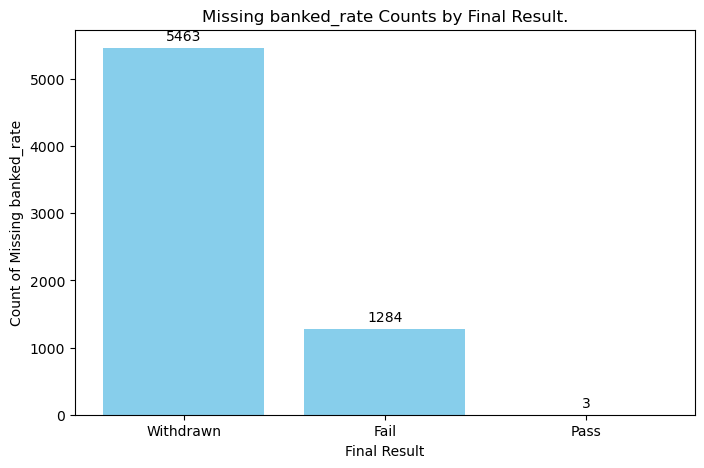

In [148]:
categories = null_banked_rate_final_result_counts.index.tolist()
counts = null_banked_rate_final_result_counts.values.tolist()

reverse_mapping = {v: k for k, v in final_result_mapping.items()}
labelled_categories = [reverse_mapping[val] for val in categories]

plot_bar_with_annotations(
    categories=labelled_categories,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count of Missing banked_rate',
    title='Missing banked_rate Counts by Final Result.',
)

In [149]:
student_df_summarised['banked_rate'] = student_df_summarised['banked_rate'].fillna(0)
student_df_custom['banked_rate'] = student_df_custom['banked_rate'].fillna(0)

### Weighted Score

The students who have null values for `weighted_score` have not submitted any assignments. We can replace the null values with 0s.

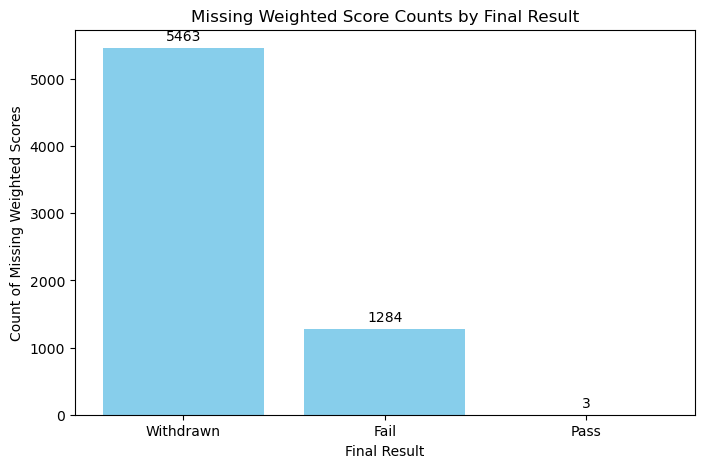

In [150]:
# Get counts of missing weighted_score by 'final_result'.
missing_weighted_score_per_final_result = student_df_summarised[student_df_summarised['weighted_score'].isna()]['final_result'].value_counts().sort_index()
categories = missing_weighted_score_per_final_result.index.tolist()
counts = missing_weighted_score_per_final_result.values.tolist()

plot_bar_with_annotations(
    categories=labelled_categories,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count of Missing Weighted Scores',
    title='Missing Weighted Score Counts by Final Result',
)

A vast majority of the students with null weighted scores have withdrawn (about 81% of null rows) or failed (about 19% of null rows). This leaves three students who have passed but their weighted scores are missing from the dataset. This is most likely a mistake from the dataset or the system was unable to register the scores for these students.

- We will take the mean weighted score for students who have passed and impute it to the missing weighted scores for passed students.
- For Failed/Withdrawen students, we will assign their score to zero as according the the data specs, if the student does not submit the assessment, no result is recorded. The final exam submissions is missing, if the result of the assessments is not stored in the system. 

In [151]:
# Calculate and store the mean pass score.
mean_pass_score_summarised = round(student_df_summarised[(student_df_summarised['final_result'] == 2) & (student_df_summarised['weighted_score'].notna())]['weighted_score'].mean(), 2)

# Impute the mean pass score to the three students who have passed but have null weighted scores.
student_df_summarised.loc[(student_df_summarised['final_result'] == 2) & (student_df_summarised['weighted_score'].isna()),'weighted_score'] = round(mean_pass_score_summarised, 2)

In [152]:
# For the Failed/Withdrawn students, the weighted score will be set to 0.
student_df_summarised['weighted_score'] = student_df_summarised['weighted_score'].fillna(0)

For custom student dataset

In [153]:
# Calculate and store the mean pass score.
mean_pass_score_custom = round(student_df_custom[(student_df_custom['final_result'] == 2) & (student_df_custom['weighted_score'].notna())]['weighted_score'].mean(), 2)

# Impute the mean pass score to the three students who have passed but have null weighted scores.
student_df_custom.loc[(student_df_custom['final_result'] == 2) & (student_df_custom['weighted_score'].isna()),'weighted_score'] = round(mean_pass_score_custom, 2)

In [154]:
# For the Failed/Withdrawn students, the weighted score will be set to 0.
student_df_custom['weighted_score'] = student_df_custom['weighted_score'].fillna(0)

### Late Rate and Fail Rate

Students with missing values for their late submission and fail rates likely did not submit any assignments. Therefore, these NaN values can be replaced with 1.00, indicating a 100% late submission rate.

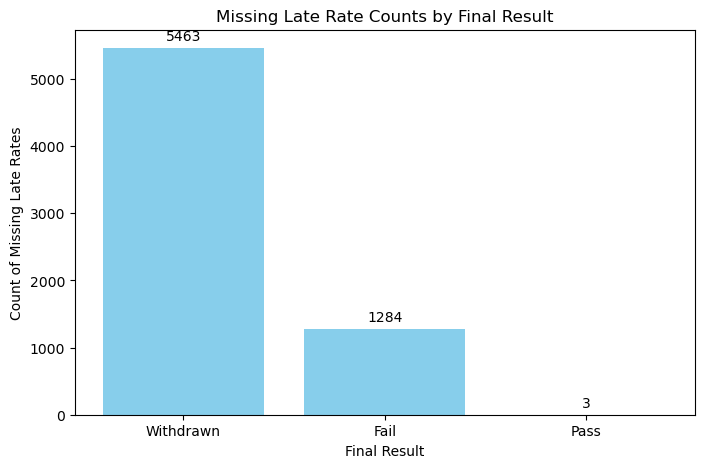

In [155]:
# Get counts of missing late_rate by 'final_result'.
missing_late_rate_per_final_result = student_df_summarised[student_df_summarised['late_rate'].isna()]['final_result'].value_counts().sort_index()
categories = missing_late_rate_per_final_result.index.tolist()
counts = missing_late_rate_per_final_result.values.tolist()

plot_bar_with_annotations(
    categories=labelled_categories,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count of Missing Late Rates',
    title='Missing Late Rate Counts by Final Result',
)

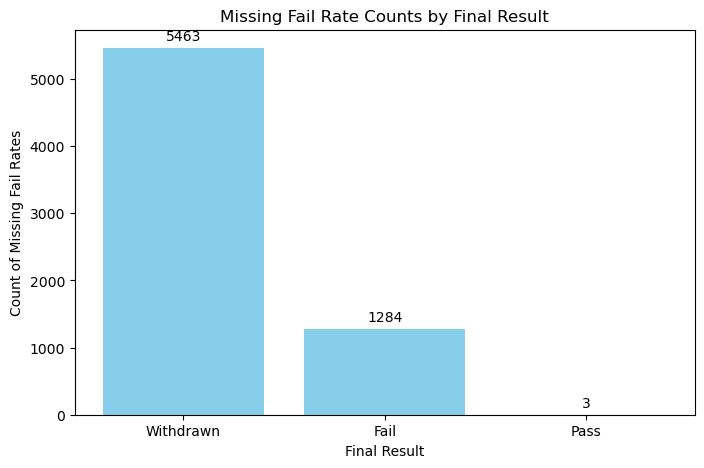

In [156]:
# Get counts of missing fail_rate by 'final_result'.
missing_fail_rate_per_final_result = student_df_summarised[student_df_summarised['fail_rate'].isna()]['final_result'].value_counts().sort_index()
categories = missing_fail_rate_per_final_result.index.tolist()
counts = missing_fail_rate_per_final_result.values.tolist()

plot_bar_with_annotations(
    categories=labelled_categories,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count of Missing Fail Rates',
    title='Missing Fail Rate Counts by Final Result',
)

Both the `late_rate` and `fail_rate` columns have missing values in the same rows. We will handle these missing values using a similar approach as we did for the `weighted_score`.

* For students who passed but have missing `late_rate` and `fail_rate`, we will impute these values with the average rates calculated from all passed students.
* For the remaining students who either failed or withdrew, we will assign a value of 1 for both `late_rate` and `fail_rate`. This is because these students also lack weighted scores, indicating that their late and fail rates could not be calculated. Assigning a value of 1 reflects that these students either did not submit, failed, or submitted all assessments late.

In [157]:
student_df_summarised['highest_education'].unique()

array([3, 2, 1, 4, 0])

In [158]:
# Summarised dataset.
### Late Rate ###
# Impute mean late_rate for passed students missing it.
mean_pass_late_rate_summarised = round(student_df_summarised.loc[(student_df_summarised['final_result'] == 2) & (student_df_summarised['late_rate'].notna()), 'late_rate'].mean(), 2)
student_df_summarised.loc[(student_df_summarised['final_result'] == 2) & (student_df_summarised['late_rate'].isna()), 'late_rate'] = mean_pass_late_rate_summarised

### Fail Rate ###
# Impute mean fail_rate for passed students missing it.
mean_pass_fail_rate_summarised = round(student_df_summarised.loc[(student_df_summarised['final_result'] == 2) & (student_df_summarised['fail_rate'].notna()), 'fail_rate'].mean(), 2)
student_df_summarised.loc[(student_df_summarised['final_result'] == 2) & (student_df_summarised['fail_rate'].isna()), 'fail_rate'] = mean_pass_fail_rate_summarised

## Custom dataset.
### Late Rate ###
# Impute mean late_rate for passed students missing it.
mean_pass_late_rate_custom = round(student_df_custom.loc[(student_df_custom['final_result'] == 2) & (student_df_custom['late_rate'].notna()), 'late_rate'].mean(), 2)
student_df_custom.loc[(student_df_custom['final_result'] == 2) & (student_df_custom['late_rate'].isna()), 'late_rate'] = mean_pass_late_rate_custom

### Fail Rate ###
# Impute mean fail_rate for passed students missing it.
mean_pass_fail_rate_custom = round(student_df_custom.loc[(student_df_custom['final_result'] == 2) & (student_df_custom['fail_rate'].notna()), 'fail_rate'].mean(), 2)
student_df_custom.loc[(student_df_custom['final_result'] == 2) & (student_df_custom['fail_rate'].isna()), 'fail_rate'] = mean_pass_fail_rate_custom

In [159]:
# Fill remaining missing late_rate and fail_rate with 0.

# Summarised dataset.
student_df_summarised['late_rate'] = student_df_summarised['late_rate'].fillna(1)
student_df_summarised['fail_rate'] = student_df_summarised['fail_rate'].fillna(1)

# Custom dataset.
student_df_custom['late_rate'] = student_df_custom['late_rate'].fillna(1)
student_df_custom['fail_rate'] = student_df_custom['fail_rate'].fillna(1)

### IMD Band Imputation (Bayesian Approach)

The IMD band is a key feature in the dataset as it provides an indication of a student's socio-economic background, which may significantly influence their likelihood of dropping out. Based on our hypothesis, certain demographic groups, particularly those defined by age, IMD level, region, and education, may be disproportionately affected by dropout risk. Therefore, ensuring the accuracy of this field is critical for effective modelling. Rather than relying on simpler imputation methods like mean, median, or mode, we will apply a Bayesian Ridge regression model to predict missing IMD values. This approach leverages patterns in related features to generate more reliable and context-aware imputations.

In [160]:
student_df_summarised['imd_band'].value_counts()

imd_band
20-30%     3654
30-40%     3539
10-20      3516
0-10%      3311
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%    2536
Name: count, dtype: int64

In [161]:
imd_mapping = {
    '0-10%': 0,
    '10-20': 1,
    '20-30%': 2,
    '30-40%': 3,
    '40-50%': 4,
    '50-60%': 5,
    '60-70%': 6,
    '70-80%': 7,
    '80-90%': 8,
    '90-100%': 9
}
student_df_summarised['imd_band'] = student_df_summarised['imd_band'].map(imd_mapping) # Summarised dataset.
student_df_custom['imd_band'] = student_df_custom['imd_band'].map(imd_mapping) # Custom dataset.

We first encode `imd_band` to ordinal values.

In [162]:
student_df_summarised[student_df_summarised['imd_band'].isnull()]

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,weighted_score,banked_rate,late_rate,fail_rate
9,AAA,2013J,53025,-179.0,NaN,268,1,North Region,4,NaN,...,0.0,0.0,1.0,0.0,1.0,1.0,79.0,0.0,0.00,0.00
17,AAA,2013J,71361,-130.0,NaN,268,1,Ireland,3,NaN,...,0.0,0.0,1.0,0.0,1.0,1.0,79.7,0.0,0.00,0.00
28,AAA,2013J,104476,-109.0,NaN,268,1,Ireland,4,NaN,...,0.0,0.0,1.0,0.0,1.0,1.0,78.9,0.0,0.40,0.00
34,AAA,2013J,114017,-29.0,NaN,268,0,North Region,4,NaN,...,0.0,0.0,1.0,0.0,1.0,1.0,72.3,0.0,0.00,0.00
65,AAA,2013J,172112,-50.0,NaN,268,1,Ireland,3,NaN,...,0.0,0.0,1.0,0.0,1.0,1.0,71.1,0.0,0.60,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30552,GGG,2013J,589914,-70.0,NaN,261,1,North Region,1,NaN,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.11,0.00
31170,GGG,2014B,575199,-28.0,NaN,241,0,North Western Region,1,NaN,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.25,0.11
31389,GGG,2014B,617889,-89.0,NaN,241,0,South West Region,1,NaN,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.00,0.89
31777,GGG,2014B,634470,-22.0,NaN,241,0,South Region,2,NaN,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.11,0.00


There are null values that needed to be imputed.

In [163]:
imd_counts = student_df_summarised.groupby('region')['imd_band'].value_counts(dropna=False)
for (region, imd_band), count in imd_counts.items():
    print(f"Region: {region}, IMD Band: {imd_band}, Count: {count}")

Region: East Anglian Region, IMD Band: 9.0, Count: 413
Region: East Anglian Region, IMD Band: 4.0, Count: 411
Region: East Anglian Region, IMD Band: 7.0, Count: 411
Region: East Anglian Region, IMD Band: 8.0, Count: 401
Region: East Anglian Region, IMD Band: 6.0, Count: 400
Region: East Anglian Region, IMD Band: 5.0, Count: 368
Region: East Anglian Region, IMD Band: 3.0, Count: 364
Region: East Anglian Region, IMD Band: 2.0, Count: 306
Region: East Anglian Region, IMD Band: 1.0, Count: 163
Region: East Anglian Region, IMD Band: 0.0, Count: 103
Region: East Midlands Region, IMD Band: 1.0, Count: 308
Region: East Midlands Region, IMD Band: 2.0, Count: 276
Region: East Midlands Region, IMD Band: 3.0, Count: 254
Region: East Midlands Region, IMD Band: 8.0, Count: 251
Region: East Midlands Region, IMD Band: 4.0, Count: 240
Region: East Midlands Region, IMD Band: 5.0, Count: 238
Region: East Midlands Region, IMD Band: 6.0, Count: 235
Region: East Midlands Region, IMD Band: 7.0, Count: 208
Re

#### Baysian Imputation of IMD Band

In [164]:
# Prepare the data.
features = ['region', 'age_band', 'highest_education', 'gender', 'disability', 'final_result']
bayesian_imd_df = student_df_summarised[features + ['imd_band']].copy()
bayesian_imd_df = bayesian_imd_df.dropna(subset=features) # Drop rows with missing values in the features

# Separate rows with known and missing imd_band.
train_imd_df = bayesian_imd_df[bayesian_imd_df['imd_band'].notnull()]
predict_imd_df = bayesian_imd_df[bayesian_imd_df['imd_band'].isnull()]

# Define columns to encode.
onehot_imd_cols = ['region', 'gender']
ordinal_imd_cols = ['age_band', 'highest_education', 'disability', 'final_result']

# Set up column transformer.
preprocessor = ColumnTransformer(transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_imd_cols),
        ('ordinal', OrdinalEncoder(), ordinal_imd_cols)
    ])

# Fit on training data and transform both train and predict sets.
X_train = preprocessor.fit_transform(train_imd_df[features])
X_predict = preprocessor.transform(predict_imd_df[features])
y_train = train_imd_df['imd_band'].astype(float)

# Initiate and fit the bayesian model.
bayesian_imd_model = BayesianRidge()
bayesian_imd_model.fit(X_train, y_train)

predicted_imd = bayesian_imd_model.predict(X_predict).round().clip(0, 9).astype(int) # Predict missing imd values.
student_df_summarised.loc[student_df_summarised['imd_band'].isnull(), 'imd_band'] = predicted_imd # Impute the imd predictions into the summarised dataset.
student_df_custom.loc[student_df_custom['imd_band'].isnull(), 'imd_band'] = predicted_imd # Impute the imd predictions into the custom dataset.

In [165]:
student_df_summarised[student_df_summarised['id_student'] == 386924]

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,weighted_score,banked_rate,late_rate,fail_rate
184,AAA,2013J,386924,-192.0,NaN,268,1,Ireland,1,4.0,...,0.0,0.0,1.0,0.0,1.0,1.0,68.9,0.0,0.4,0.0


In [166]:
student_df_custom[student_df_custom['id_student'] == 386924]

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,...,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,has_folder,weighted_score,banked_rate,late_rate,fail_rate
184,AAA,2013J,386924,-192.0,NaN,268,1,Ireland,1,4.0,...,0.0,1.0,0.0,1.0,1.0,0,69.8,0.0,0.33,0.0


### Date Unregistration

In [167]:
early_withdrawals = student_df_summarised[student_df_summarised['date_unregistration'] < 19]
early_withdrawal_count = early_withdrawals.shape[0]
print(f"Number of students who withdrew before the module started: {early_withdrawal_count}")

Number of students who withdrew before the module started: 4609


A total of 4,609 students unregistered either before the module began or within the first 19 days of its start. This cutoff was selected because most modules have their first assessments scheduled from day 19 onwards. These students typically show no engagement with the VLE and have not completed any assessments, meaning they offer no useful insight for analysis. As a result, these records should be excluded from the dataset.

In [168]:
# Remove students who unregistered before day 19 of the module for summarised dataset.
student_df_summarised = student_df_summarised[
    (student_df_summarised['date_unregistration'].isna()) | 
    (student_df_summarised['date_unregistration'] >= 19)
]

# Remove students who unregistered before day 19 of the module for custom dataset.
student_df_custom = student_df_custom[
    (student_df_custom['date_unregistration'].isna()) | 
    (student_df_custom['date_unregistration'] >= 19)
]

In [169]:
early_withdrawals = student_df_summarised[student_df_summarised['date_unregistration'] > 0]
early_withdrawal_count = early_withdrawals.shape[0]
print(f"Number of students who withdrew after the module started: {early_withdrawal_count}")

Number of students who withdrew after the module started: 5463


In [170]:
student_df_summarised.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration          0
date_unregistration    22521
                       ...  
has_url                    0
weighted_score             0
banked_rate                0
late_rate                  0
fail_rate                  0
Length: 61, dtype: int64

This `date_unregistration` feature offers limited insight and lacks sufficient contextual value. Since the final_result feature already captures the student's outcome more effectively, we will remove date_unregistration from the datasets.

In [171]:
student_df_summarised.drop(columns='date_unregistration', inplace=True)
student_df_custom.drop(columns='date_unregistration', inplace=True)

In [172]:
# student_df_summarised.to_csv('student_df_summarised.csv', index=False)
# student_df_custom.to_csv('student_df_custom.csv', index=False)

### Split the dataset

It's important to split the dataset before doing serious exploratory analysis as we do not want to peak at the testing data. Any pre-processing and further feature engineering will also be done to the test set with the same parameters as are set for the training set. We'' stratify by code module to make sure that each module is represented equally in both the test and the training sets.

In [173]:
student_df_early = pd.read_csv(r'student_df_early.csv')
student_df_midpoint = pd.read_csv(r'student_df_midpoint.csv')
student_df_late = pd.read_csv(r'student_df_late.csv')
student_df_full = pd.read_csv(r'student_df_full.csv')

In [174]:
# Create a combined ID column.
student_df_early['combined_id'] = (
    student_df_early['code_module'].astype(str) + '_' +
    student_df_early['code_presentation'].astype(str) + '_' +
    student_df_early['id_student'].astype(str)
)

# Get unique combined IDs and corresponding stratify info.
unique_ids = student_df_early[['combined_id', 'code_module']].drop_duplicates()

# Split on unique combined IDs, stratifying by code_module (or any other column).
train_ids, test_ids = train_test_split(
    unique_ids['combined_id'],
    test_size=0.2,
    random_state=2003,
    stratify=unique_ids['code_module']
)

# Use those combined_ids to filter all dataframes.
def filter_by_ids(df, train_ids, test_ids):
    df['combined_id'] = (
        df['code_module'].astype(str) + '_' +
        df['code_presentation'].astype(str) + '_' +
        df['id_student'].astype(str)
    )
    train_df = df[df['combined_id'].isin(train_ids)].copy()
    test_df = df[df['combined_id'].isin(test_ids)].copy()
    return train_df, test_df

train_early, test_early = filter_by_ids(student_df_early, train_ids, test_ids)
train_midpoint, test_midpoint = filter_by_ids(student_df_midpoint, train_ids, test_ids)
train_late, test_late = filter_by_ids(student_df_late, train_ids, test_ids)
train_full, test_full = filter_by_ids(student_df_full, train_ids, test_ids)

In [175]:
print(len(train_early), len(train_midpoint), len(train_late), len(train_full))

22387 22387 22387 22387


In [176]:
print(len(test_early), len(test_midpoint), len(test_late), len(test_full))

5597 5597 5597 5597


# Exploratory Data Analysis (EDA) 

### Date Registration

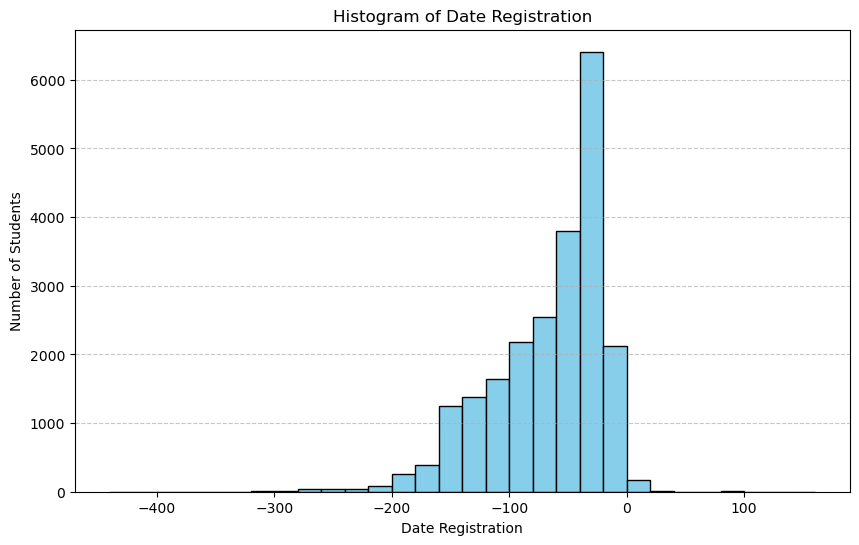

In [177]:
# Plot histogram for `date_registration`.
plt.figure(figsize=(10, 6))
plt.hist(train_early['date_registration'], bins=range(-440, 180, 20), color='skyblue', edgecolor='black')
plt.xlabel('Date Registration')
plt.ylabel('Number of Students')
plt.title('Histogram of Date Registration')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most students registered 25 to 100 days before their module's start date, indicating timely enrolment. Only a small number enrolled after the module had already started, which is relatively uncommon. Let's echeck the outliers using box and whisker plot.

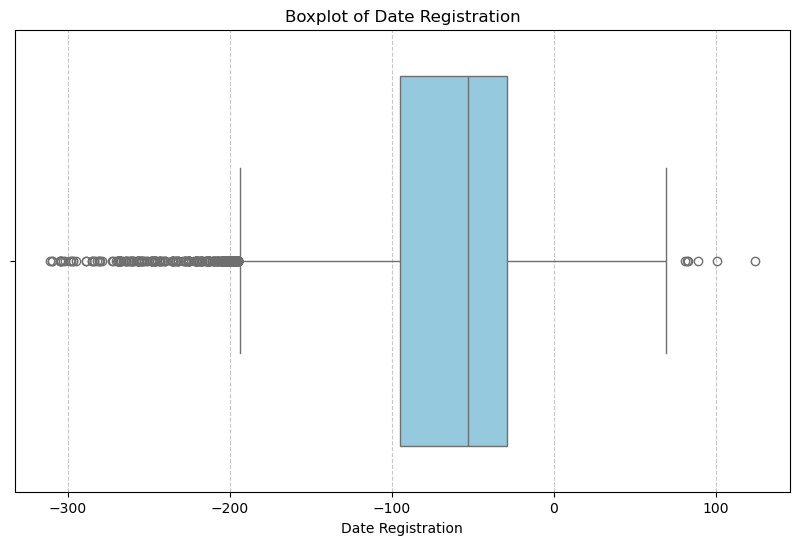

In [178]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_early['date_registration'], color='skyblue')
plt.xlabel('Date Registration')
plt.title('Boxplot of Date Registration')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Some students registered exceptionally early, with several enrolling nearly a year in advance. On the other hand, a few students registered very late, even as far as about 130 days after the module had started, by which point a significant portion of the course would have already been completed.

### Code Module

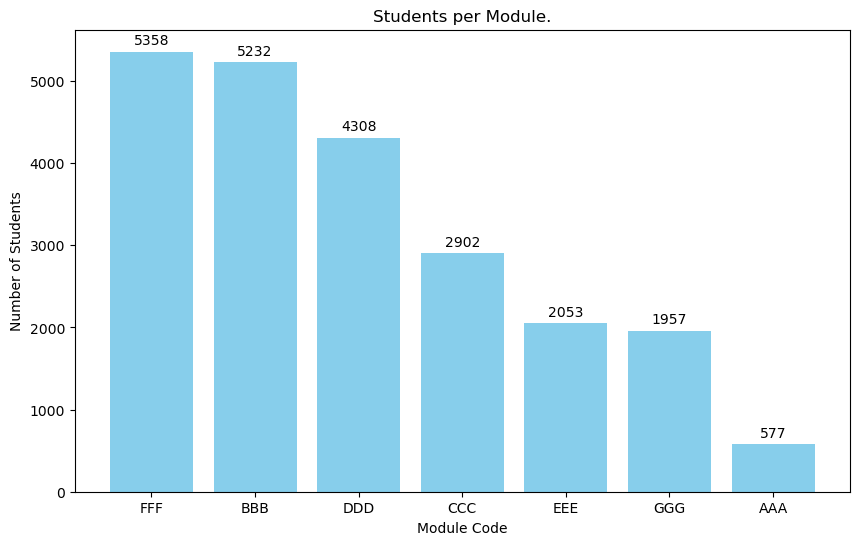

In [179]:
module_counts = train_early['code_module'].value_counts()

plot_bar_with_annotations(
    categories=module_counts.index.tolist(),
    counts=module_counts.values.tolist(),
    xlabel='Module Code',
    ylabel='Number of Students',
    title='Students per Module.',
    figsize=(10,6)
)

The majority of students are enrolled in modules FFF and BBB, each making up roughly 24% of the training set. In contrast, module AAA has the smallest representation, accounting for just around 2.5% of students.

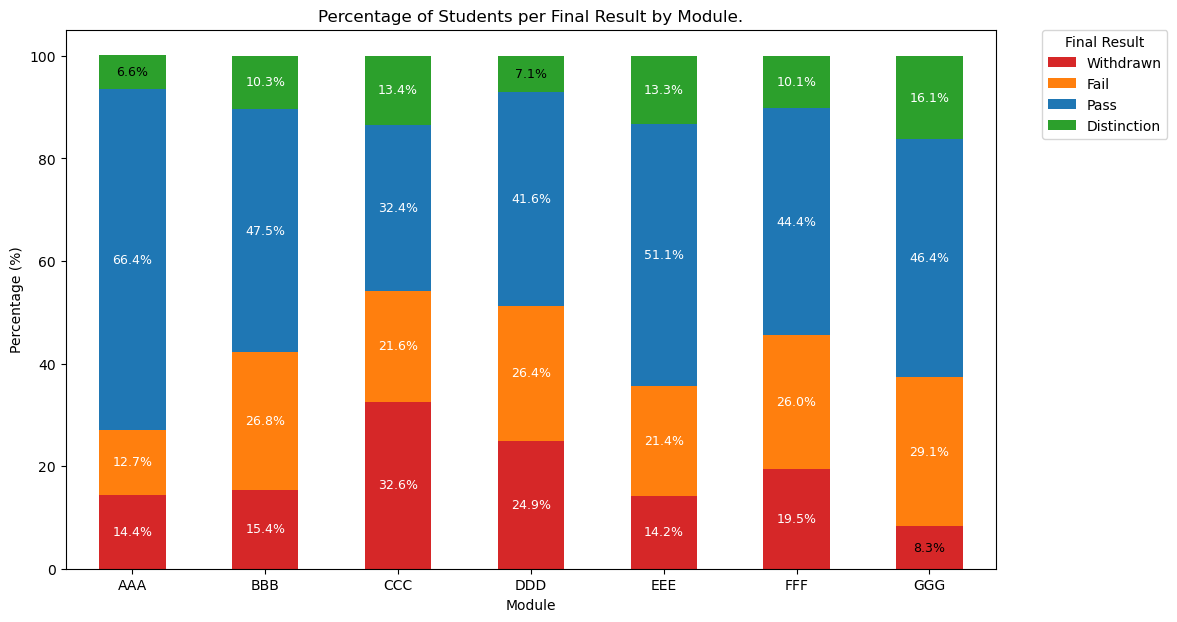

In [180]:
final_result_mapping = {
    0: 'Withdrawn',
    1: 'Fail',
    2: 'Pass',
    3: 'Distinction'
}

final_result_label = train_early.copy()
final_result_label['final_result_label'] = final_result_label['final_result'].map(final_result_mapping)
module_result_counts = pd.crosstab(final_result_label['code_module'], final_result_label['final_result_label']) # Create crosstab: module vs final result.
ordered_columns = ['Withdrawn', 'Fail', 'Pass', 'Distinction'] # Ensure correct stacked order.
module_result_counts = module_result_counts[ordered_columns]

# Convert module counts to percentage.
module_result_pct = round(module_result_counts.div(module_result_counts.sum(axis=1), axis=0) * 100, 1)

# Colour mapping.
custom_colors = {
    'Withdrawn': '#d62728',
    'Fail': '#ff7f0e',
    'Pass': '#1f77b4',
    'Distinction': '#2ca02c'
}

ax = module_result_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=[custom_colors[col] for col in ordered_columns]
)

# Add annotations.
for bar_idx, module in enumerate(module_result_pct.index):
    cumulative_height = 0
    for result in ordered_columns:
        height = module_result_pct.loc[module, result]
        if height > 0:
            ax.text(
                bar_idx,
                cumulative_height + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if height > 10 else 'black')
            cumulative_height += height

plt.title('Percentage of Students per Final Result by Module.')
plt.xlabel('Module')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#### Observations:

* GGG has the highest distinction rate (16.1%), outperforming all other modules in top-grade achievements, though it also has the highest failure rate (29.1%), suggesting a polarising performance pattern. Students either do very well or struggle significantly.

* CCC shows the highest dropout rate (32.6%) and the lowest pass rate (32.4%), indicating major retention issues in this module. AAA appears the most stable, with the highest pass rate (66.4%) and comparatively low dropout (14.4%) and fail (12.7%) rates, indicating that students generally perform well in it. Another thing to keep in mind is that students registered to the AAA module only represent about 2% of the train set. 

* Moreover, CCC and DDD show elevated dropout and fail rates, with over 50% of students either withdrawing or failing, these modules may require attention in terms of structure, support, or assessment design. EEE stands out positively with a balanced final result compositon: the second-highest distinction rate (13.3%) and relatively robust pass rate (51.1%), making it one of the better-performing modules overall. This variation across modules strongly suggests that module design and delivery influence student success, and targeted improvements could be made in modules with high attrition or low achievement.

### Code Presentation

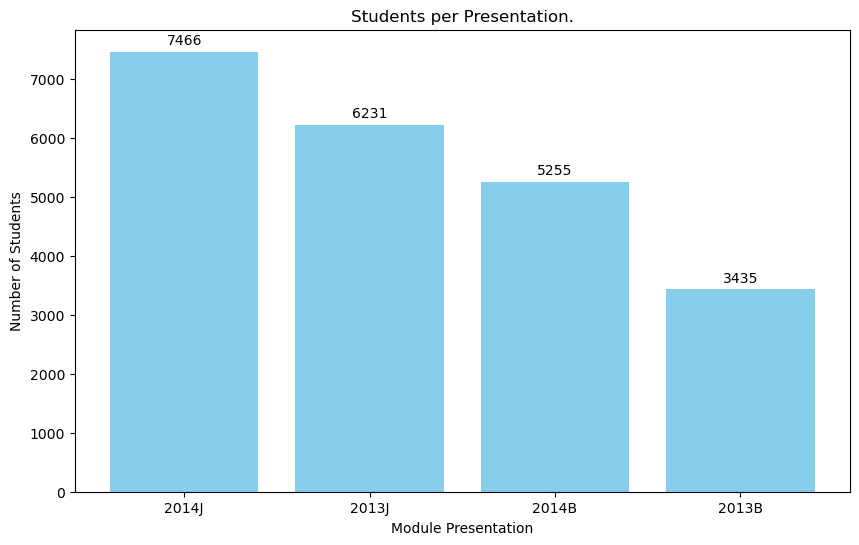

In [181]:
module_presentation = train_early['code_presentation'].value_counts()

plot_bar_with_annotations(
    categories=module_presentation.index.tolist(),
    counts=module_presentation.values.tolist(),
    xlabel='Module Presentation',
    ylabel='Number of Students',
    title='Students per Presentation.',
    figsize=(10,6)
)

The largest proportion of students come from the 2014J presentation, making up about 33% of the total. Just as a reminder, presentations labelled with "B" start in February, while those with "J" begin in October. The smallest group is from 2013B, representing only 15%.

### Gender

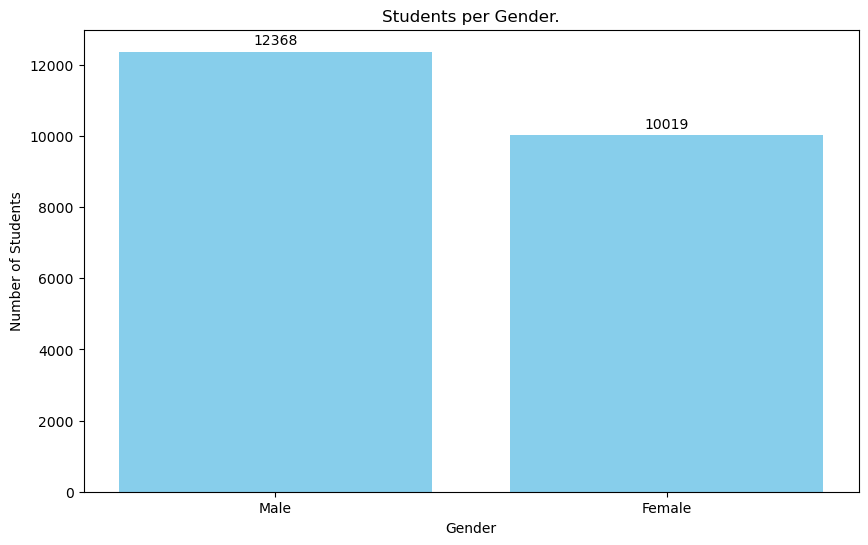

In [182]:
gender_counts = train_early['gender'].value_counts()
gender_counts.index = gender_counts.index.map({1: 'Male', 0: 'Female'})

plot_bar_with_annotations(
    categories=gender_counts.index.tolist(),
    counts=gender_counts.values.tolist(),
    xlabel='Gender',
    ylabel='Number of Students',
    title='Students per Gender.',
    figsize=(10,6)
)

Males make up approximately 55% of the training set, while females account for around 45%. Overall, the dataset is fairly balanced, with a slight male majority.

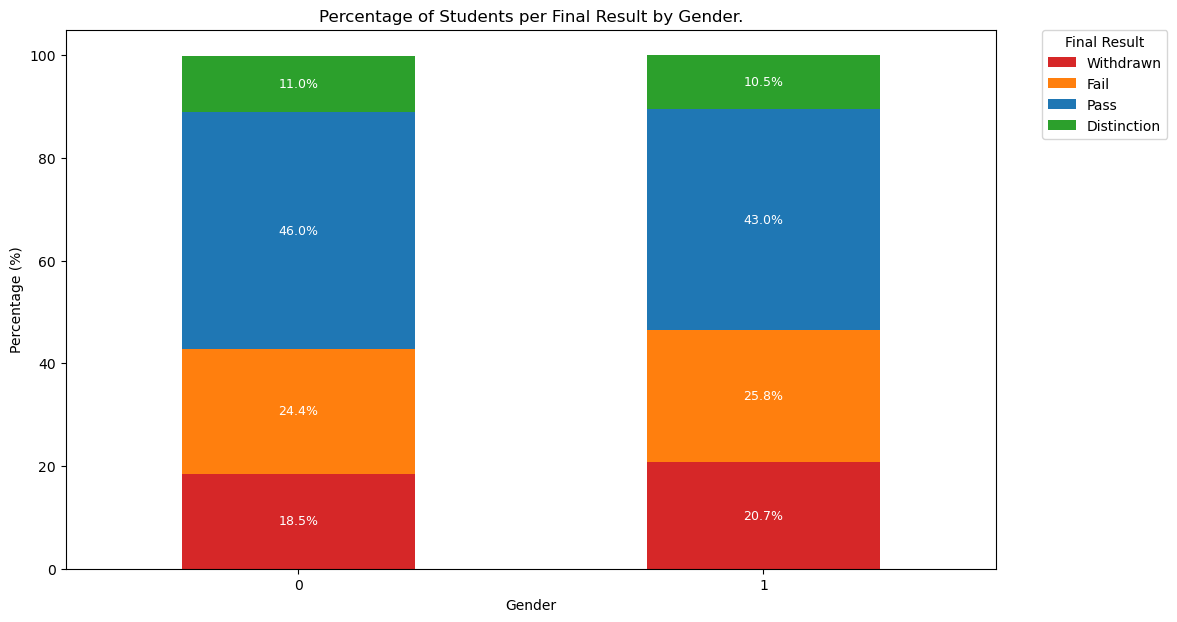

In [183]:
final_result_label = train_early.copy()
final_result_label['final_result_label'] = final_result_label['final_result'].map(final_result_mapping)
gender_result_counts = pd.crosstab(final_result_label['gender'], final_result_label['final_result_label']) # Create crosstab: module vs final result.
ordered_columns = ['Withdrawn', 'Fail', 'Pass', 'Distinction'] # Ensure correct stacked order.
gender_result_counts = gender_result_counts[ordered_columns]

# Convert module counts to percentage.
gender_result_pct = round(gender_result_counts.div(gender_result_counts.sum(axis=1), axis=0) * 100, 1)

ax = gender_result_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=[custom_colors[col] for col in ordered_columns]
)

# Add annotations.
for bar_idx, module in enumerate(gender_result_pct.index):
    cumulative_height = 0
    for result in ordered_columns:
        height = gender_result_pct.loc[module, result]
        if height > 0:
            ax.text(
                bar_idx,
                cumulative_height + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if height > 10 else 'black')
            cumulative_height += height

plt.title('Percentage of Students per Final Result by Gender.')
plt.xlabel('Gender')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Female students have a slightly lower dropout rate (18.5%) compared to males (20.7%), and a marginally higher pass rate (46% vs 43%). Failure and distinction rates are also very similar, with females at 24.4% and 11%, and males at 25.8% and 10.5%, respectively. These differences are minimal and tells us that gender does not significantly influence academic outcomes in this dataset.

### Disability

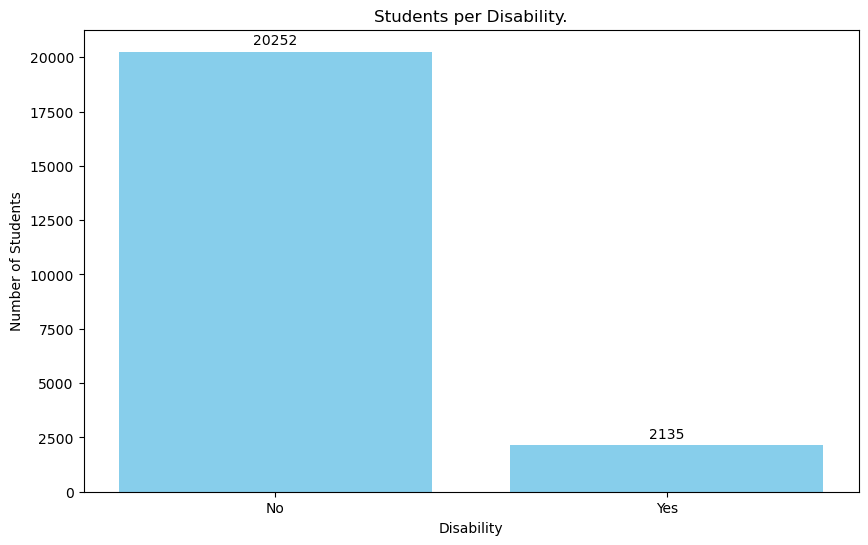

In [184]:
disability_counts = train_early['disability'].value_counts()
disability_counts.index = disability_counts.index.map({1: 'Yes', 0: 'No'})

plot_bar_with_annotations(
    categories=disability_counts.index.tolist(),
    counts=disability_counts.values.tolist(),
    xlabel='Disability',
    ylabel='Number of Students',
    title='Students per Disability.',
    figsize=(10,6)
)

Less than 10% of the students in the train set are disabled.

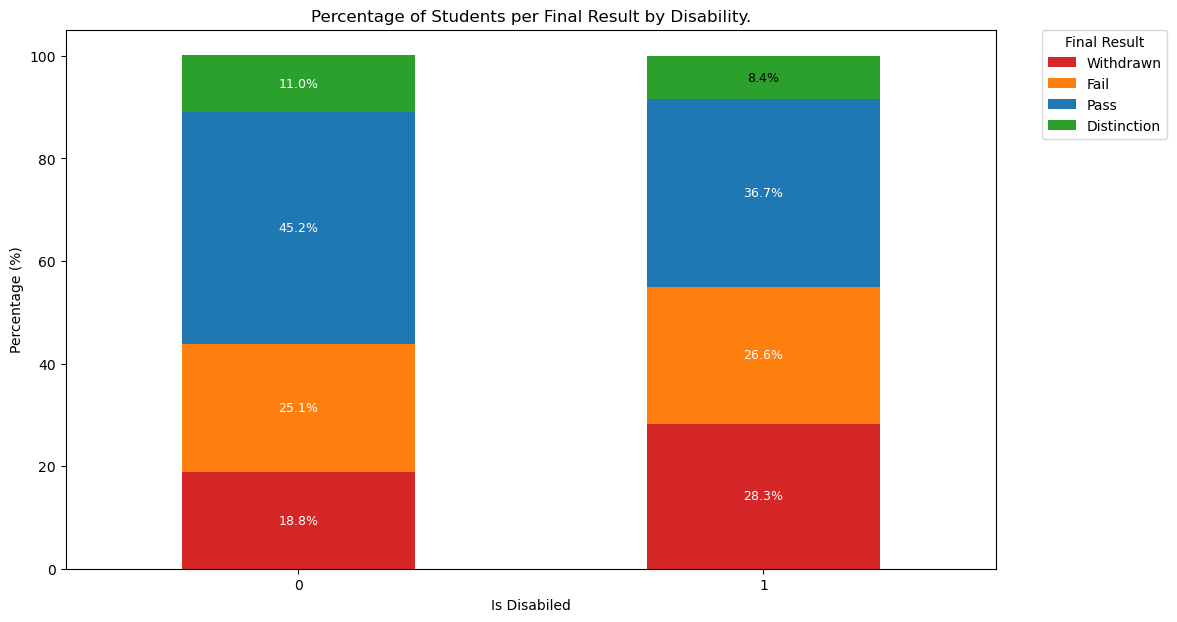

In [185]:
final_result_label = train_early.copy()
final_result_label['final_result_label'] = final_result_label['final_result'].map(final_result_mapping)
disability_result_counts = pd.crosstab(final_result_label['disability'], final_result_label['final_result_label']) # Create crosstab: module vs final result.
ordered_columns = ['Withdrawn', 'Fail', 'Pass', 'Distinction'] # Ensure correct stacked order.
disability_result_counts = disability_result_counts[ordered_columns]

# Convert module counts to percentage.
disability_result_pct = round(disability_result_counts.div(disability_result_counts.sum(axis=1), axis=0) * 100, 1)

ax = disability_result_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=[custom_colors[col] for col in ordered_columns]
)

# Add annotations.
for bar_idx, module in enumerate(disability_result_pct.index):
    cumulative_height = 0
    for result in ordered_columns:
        height = disability_result_pct.loc[module, result]
        if height > 0:
            ax.text(
                bar_idx,
                cumulative_height + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if height > 10 else 'black')
            cumulative_height += height

plt.title('Percentage of Students per Final Result by Disability.')
plt.xlabel('Is Disabiled')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

The results indicate a clear disparity in academic outcomes between students with and without disabilities. Students without disabilities (disability = 0) have a lower dropout rate (18.8%) and a higher pass rate (45.2%) compared to those with disabilities (disability = 1), who show a notably higher dropout rate (28.3%) and a lower pass rate (36.7%). Additionally, the distinction rate is higher for students without disabilities (11%) versus 8.4% for those with disabilities, while failure rates are relatively close (25.1% vs 26.6%). These differences suggest that students with disabilities may face additional challenges impacting their academic performance and retention.

### Region

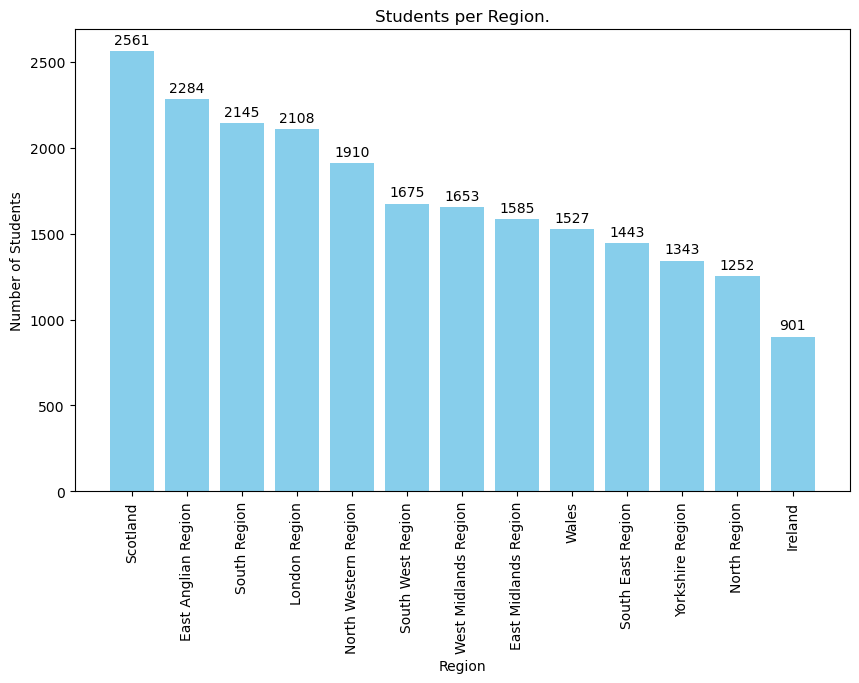

In [186]:
region_counts = train_early['region'].value_counts()

plot_bar_with_annotations(
    categories=region_counts.index.tolist(),
    counts=region_counts.values.tolist(),
    xlabel='Region',
    ylabel='Number of Students',
    title='Students per Region.',
    rotation=90,
    figsize=(10,6)
)

Scotland has the highest proportion of students, making up around 11% of the dataset, while Ireland has the smallest share with just 928 students, representing around 4%. Other regions like London also have notable representation, contributing approximately 10% of the total. Next, let us find out the droput rate per region.

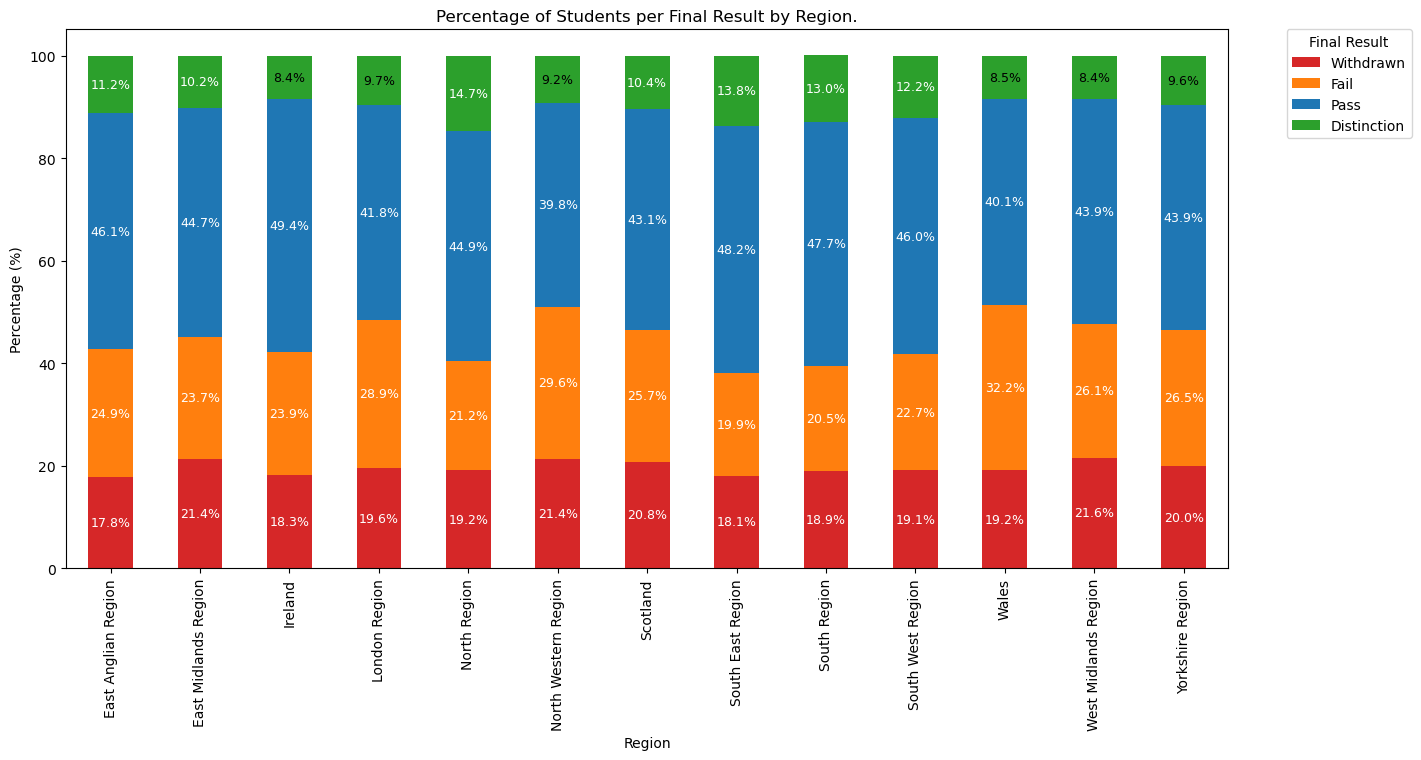

In [187]:
final_result_label = train_early.copy()
final_result_label['final_result_label'] = final_result_label['final_result'].map(final_result_mapping)
region_result_counts = pd.crosstab(final_result_label['region'], final_result_label['final_result_label']) # Create crosstab: module vs final result.
ordered_columns = ['Withdrawn', 'Fail', 'Pass', 'Distinction'] # Ensure correct stacked order.
region_result_counts = region_result_counts[ordered_columns]

# Convert module counts to percentage.
region_result_pct = round(region_result_counts.div(region_result_counts.sum(axis=1), axis=0) * 100, 1)

ax = region_result_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 7),
    color=[custom_colors[col] for col in ordered_columns]
)

# Add annotations.
for bar_idx, module in enumerate(region_result_pct.index):
    cumulative_height = 0
    for result in ordered_columns:
        height = region_result_pct.loc[module, result]
        if height > 0:
            ax.text(
                bar_idx,
                cumulative_height + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if height > 10 else 'black')
            cumulative_height += height

plt.title('Percentage of Students per Final Result by Region.')
plt.xlabel('Region')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=90)
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#### Observations:

* Withdrawal Rates
    * Withdrawal is most common in West Midlands (21.6%), East Midlands (21.4%), and North West (21.4%), indicating these regions experience the most student dropouts.
    * The lowest withdrawal rates are in South East (18.1%), East Anglian (17.8%), and Ireland (18.3%), suggesting better retention.

* Failure Rates
    * Failure is most prevalent in Wales (32.2%), North West (29.6%), and London (28.9%), implying students in these areas tend to remain enrolled but struggle academically.
    * South East (19.9%) and South (20.5%) have the lowest failure rates, indicating stronger academic support or student performance.

* Pass Rates
    * The highest pass rates are seen in Ireland (49.4%), South East (48.2%), and South (47.7%), reflecting better academic outcomes in these regions.
    * North West (39.8%) and London (41.8%) have lower pass rates, which may be linked to the higher failure and withdrawal rates observed.

* Distinction Rates
    * Distinctions are most frequent in North Region (14.7%), South East (13.8%), and South (13.0%), indicating stronger academic performance at the top end.
    * The lowest distinction rates are in Ireland (8.4%), Wales (8.5%), and West Midlands (8.4%).

### Highest Education

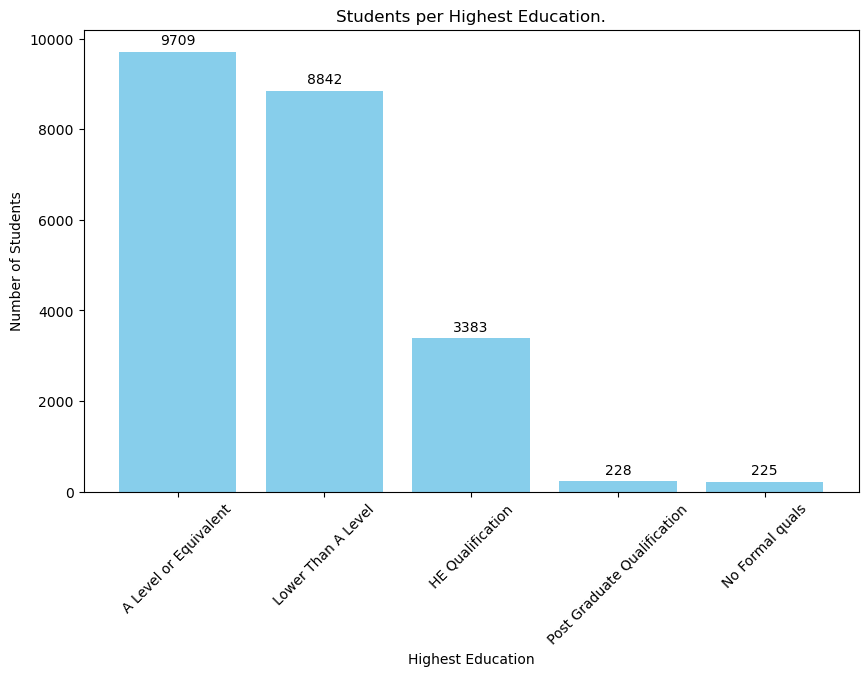

In [188]:
highest_education_counts = train_early['highest_education'].value_counts()
highest_education_counts.index = highest_education_counts.index.map({4: 'Post Graduate Qualification', 3: 'HE Qualification', 
                                                                     2: 'A Level or Equivalent', 1: 'Lower Than A Level', 0: 'No Formal quals'})

plot_bar_with_annotations(
    categories=highest_education_counts.index.tolist(),
    counts=highest_education_counts.values.tolist(),
    xlabel='Highest Education',
    ylabel='Number of Students',
    title='Students per Highest Education.',
    rotation=45,
    figsize=(10,6)
)

The majority of students in the training set hold some form of qualification. The largest group has A Level or equivalent qualifications, accounting for 43%, closely followed by those with qualifications lower than A Level at around 40%. Postgraduates and those with no formal qualifications represent the smallest groups, each making up just 1% of the total.

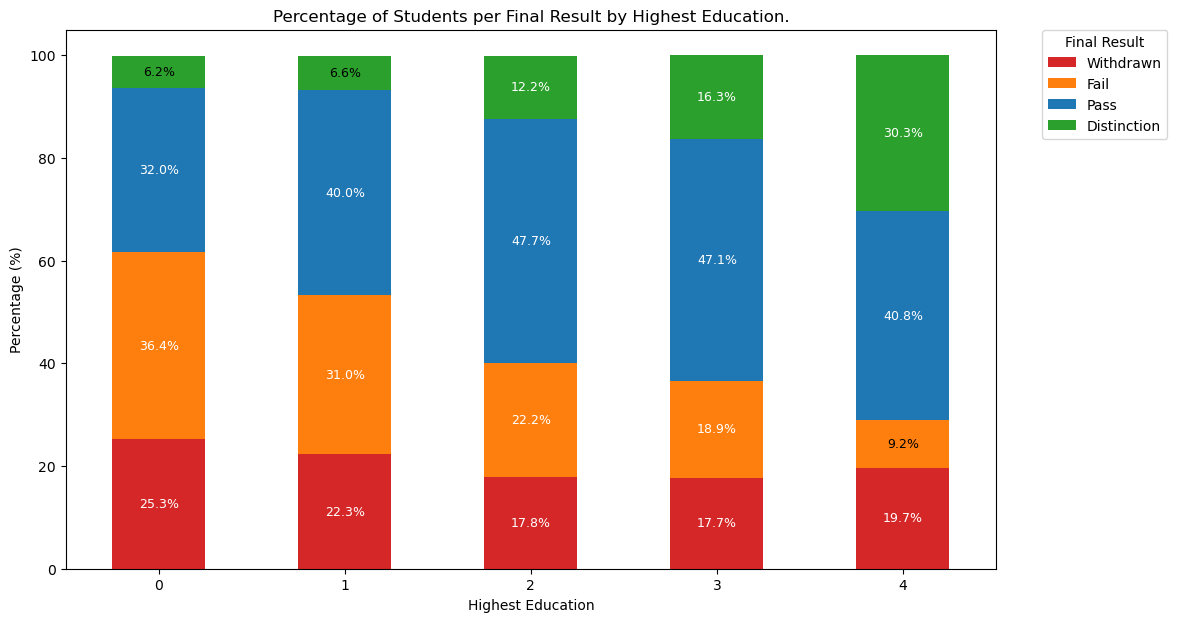

In [189]:
final_result_label = train_early.copy()
final_result_label['final_result_label'] = final_result_label['final_result'].map(final_result_mapping)
highest_education_result_counts = pd.crosstab(final_result_label['highest_education'], final_result_label['final_result_label']) # Create crosstab: module vs final result.
ordered_columns = ['Withdrawn', 'Fail', 'Pass', 'Distinction'] # Ensure correct stacked order.
highest_education_result_counts = highest_education_result_counts[ordered_columns]

# Convert module counts to percentage.
highest_education_result_pct = round(highest_education_result_counts.div(highest_education_result_counts.sum(axis=1), axis=0) * 100, 1)

ax = highest_education_result_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=[custom_colors[col] for col in ordered_columns]
)

# Add annotations.
for bar_idx, module in enumerate(highest_education_result_pct.index):
    cumulative_height = 0
    for result in ordered_columns:
        height = highest_education_result_pct.loc[module, result]
        if height > 0:
            ax.text(
                bar_idx,
                cumulative_height + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if height > 10 else 'black')
            cumulative_height += height

plt.title('Percentage of Students per Final Result by Highest Education.')
plt.xlabel('Highest Education')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#### Observations

* Students without formal qualifications (0) have the highest withdrawal rate at 25.3% and also the highest failure rate at 36.4%. Their pass rate is the lowest at 32%, with only 6.2% achieving a distinction.

* Those with qualifications lower than A level (1) see a decrease in withdrawal (22.3%) and failure (31%), with a pass rate increase to 40% and a slight improvement in distinctions at 6.6%.

* Students holding A level or equivalent qualifications (2) have even lower withdrawal (17.8%) and failure rates (22.2%), while their pass rate rises to 47.7% and distinctions to 12.2%.

* Those with a higher education qualification (3) experience a small reduction in withdrawals (17.7%) and failures (18.9%), with a slighly smaller pass rate around 47.1% and distinctions increasing to 16.3%.

* Finally, postgraduate qualification holders (4) perform slighly worse than level 3 in terms of withdrawal rate (19.7%) and pass rate (40.8%), but have the lowest failure rates (9.2%), and the highest distinction rate at 30.3%.

Overall, higher prior educational attainment is associated with better academic outcomes and lower dropout rates.

### IMD Band

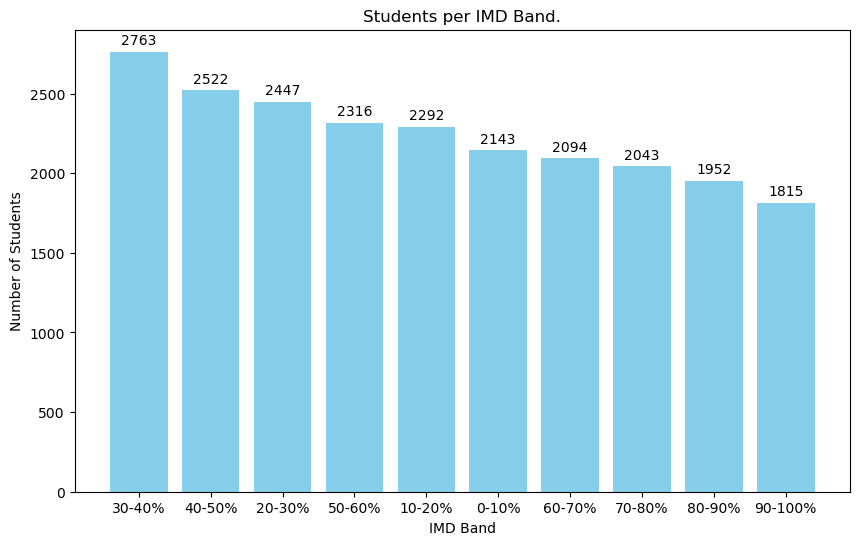

In [190]:
imd_band_counts = train_early['imd_band'].value_counts()
imd_band_counts.index = imd_band_counts.index.map({0: '0-10%', 1: '10-20%', 2: '20-30%', 3: '30-40%', 4: '40-50%', 5: '50-60%', 
                                                   6: '60-70%', 7: '70-80%', 8: '80-90%', 9: '90-100%'})

plot_bar_with_annotations(
    categories=imd_band_counts.index.tolist(),
    counts=imd_band_counts.values.tolist(),
    xlabel='IMD Band',
    ylabel='Number of Students',
    title='Students per IMD Band.',
    figsize=(10,6)
)

The largest proportion of students fall into IMD band 3 (30–40%), making up around 12% of the training set, while band 9 (90–100%) is the least common, accounting for about 8%. Additionally, around 10% of students come from the most deprived areas, classified in the 0–10% IMD band.

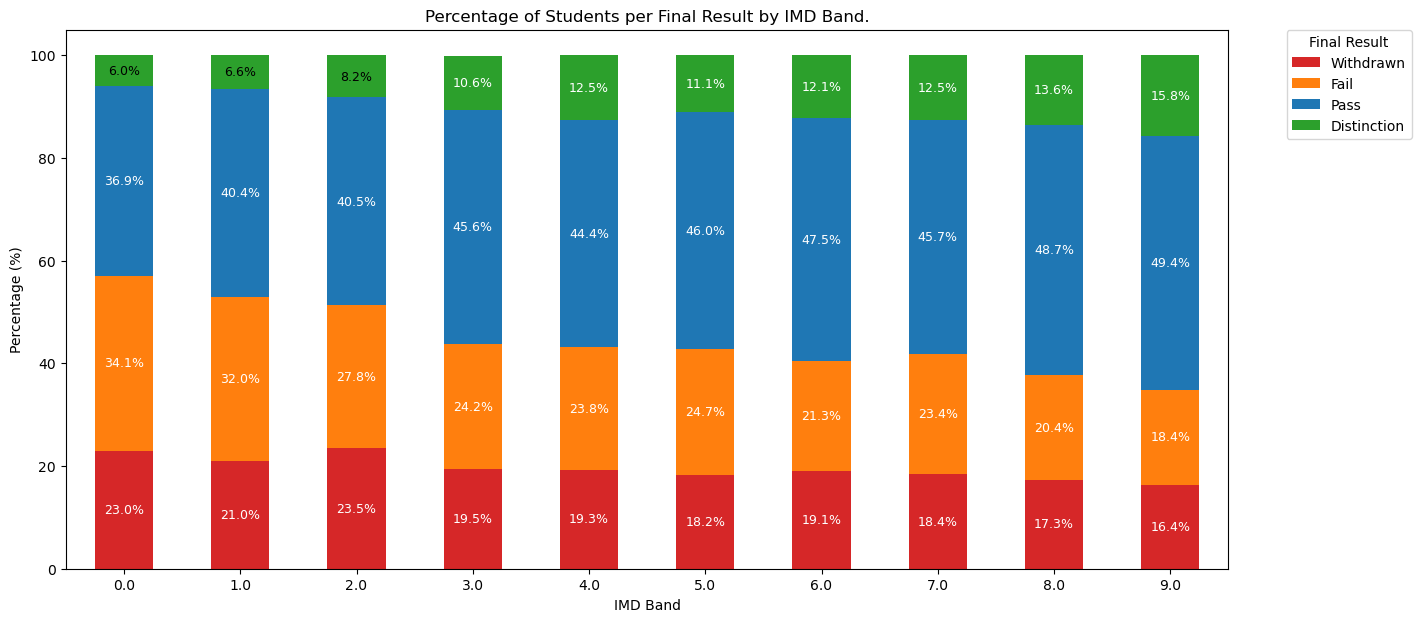

In [191]:
final_result_label = train_early.copy()
final_result_label['final_result_label'] = final_result_label['final_result'].map(final_result_mapping)
imd_band_result_counts = pd.crosstab(final_result_label['imd_band'], final_result_label['final_result_label']) # Create crosstab: module vs final result.
ordered_columns = ['Withdrawn', 'Fail', 'Pass', 'Distinction'] # Ensure correct stacked order.
imd_band_result_counts = imd_band_result_counts[ordered_columns]

# Convert module counts to percentage.
imd_band_result_pct = round(imd_band_result_counts.div(imd_band_result_counts.sum(axis=1), axis=0) * 100, 1)

ax = imd_band_result_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 7),
    color=[custom_colors[col] for col in ordered_columns]
)

# Add annotations.
for bar_idx, module in enumerate(imd_band_result_pct.index):
    cumulative_height = 0
    for result in ordered_columns:
        height = imd_band_result_pct.loc[module, result]
        if height > 0:
            ax.text(
                bar_idx,
                cumulative_height + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if height > 10 else 'black')
            cumulative_height += height

plt.title('Percentage of Students per Final Result by IMD Band.')
plt.xlabel('IMD Band')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#### Observations

* Students in the most deprived areas (IMD 0.0) have the highest withdrawal rate at 23% and the highest failure rate at 34.1%, with the lowest pass (36.9%) and distinction rates (6%).

* As deprivation decreases (higher IMD bands), withdrawal and failure rates gradually decline, while pass and distinction rates increase.

* For example, students in the least deprived areas (IMD 9.0) have the lowest withdrawal rate at 16.4% and failure rate at 18.4%, alongside the highest pass rate (49.4%) and distinction rate (15.8%).

Overall, there is a clear trend showing that students from less deprived areas tend to perform better academically, with fewer dropouts and failures and more passes and distinctions.

### Age Band

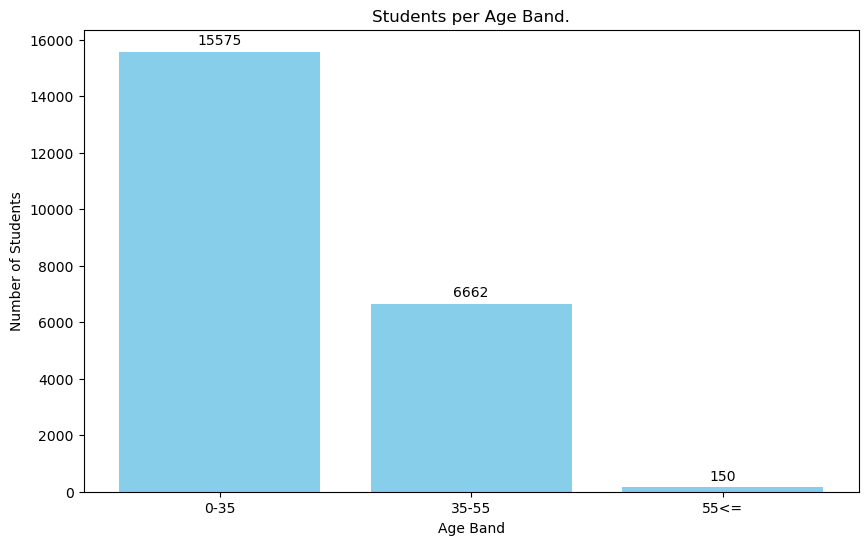

In [192]:
age_band_counts = train_early['age_band'].value_counts()
age_band_counts.index = age_band_counts.index.map({2: '55<=', 1: '35-55', 0: '0-35'})

plot_bar_with_annotations(
    categories=age_band_counts.index.tolist(),
    counts=age_band_counts.values.tolist(),
    xlabel='Age Band',
    ylabel='Number of Students',
    title='Students per Age Band.',
    figsize=(10,6)
)

The majority of students are aged between 0–35, making up about 70% of the dataset. This is followed by the 35–55 age group, which accounts for approximately 30%. The 55 and above age group is the smallest, with fewer than 1% of students, or 150 students.

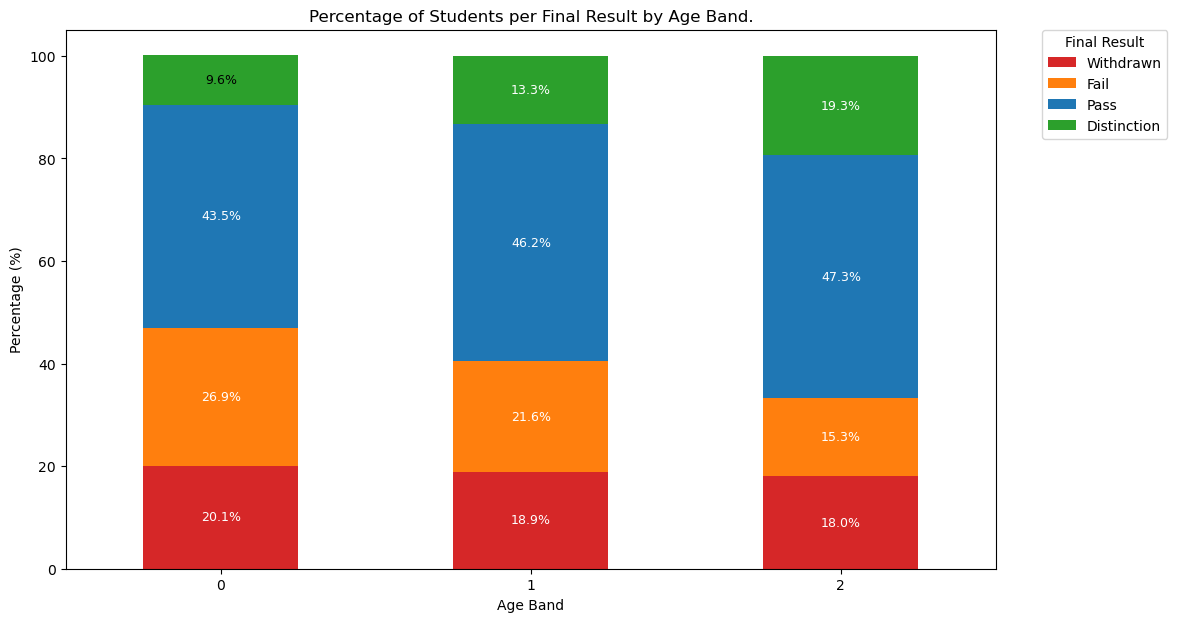

In [193]:
final_result_label = train_early.copy()
final_result_label['final_result_label'] = final_result_label['final_result'].map(final_result_mapping)
age_band_result_counts = pd.crosstab(final_result_label['age_band'], final_result_label['final_result_label']) # Create crosstab: module vs final result.
ordered_columns = ['Withdrawn', 'Fail', 'Pass', 'Distinction'] # Ensure correct stacked order.
age_band_result_counts = age_band_result_counts[ordered_columns]

# Convert module counts to percentage.
age_band_result_pct = round(age_band_result_counts.div(age_band_result_counts.sum(axis=1), axis=0) * 100, 1)

ax = age_band_result_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=[custom_colors[col] for col in ordered_columns]
)

# Add annotations.
for bar_idx, module in enumerate(age_band_result_pct.index):
    cumulative_height = 0
    for result in ordered_columns:
        height = age_band_result_pct.loc[module, result]
        if height > 0:
            ax.text(
                bar_idx,
                cumulative_height + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if height > 10 else 'black')
            cumulative_height += height

plt.title('Percentage of Students per Final Result by Age Band.')
plt.xlabel('Age Band')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#### Observations

* Younger students aged 0-35 (Age Band = 0) have the highest withdrawal rate at 20.1% and fail rate at 26.9%, with lower pass (45.5%) and distinction rates (9.6%).

* Students aged 35-55 (Age Band = 1) show better outcomes with a lower withdrawal rate of 18.9% and fail rate of 21.6%, while pass and distinction rates improve to 46.2% and 13.3%, respectively.

* The oldest group, aged 55 and above (Age Band = 2), performs best overall, having the lowest withdrawal rate (18%) and fail rate (15.3%), slightly higher pass rate than the 35-55 age band at 47.3% and distinction rates (19.3%). But keep in mind that this age group only represent less than 1% of the train set.

This indicates that older students tend to achieve better results and have lower dropout rates compared to younger students.

### Number of Previous Module Attempts

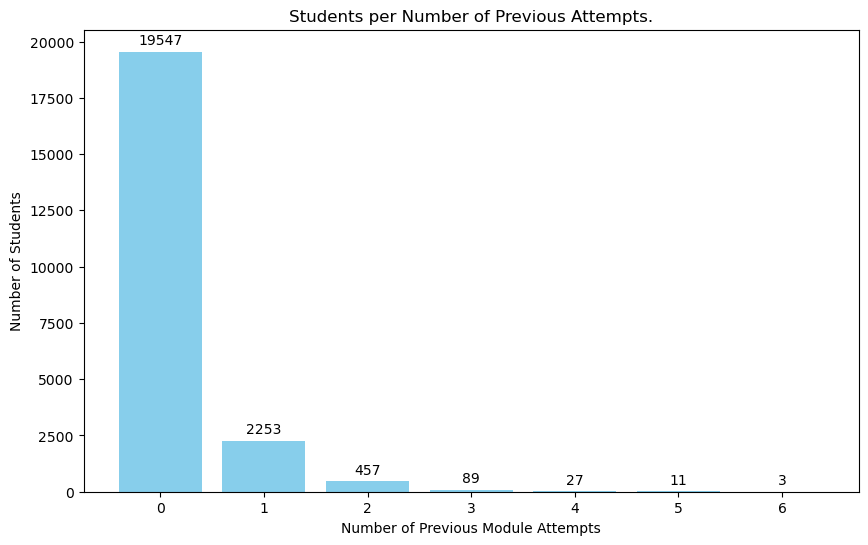

In [194]:
num_prev_attempt_counts = train_early['num_of_prev_attempts'].value_counts()

plot_bar_with_annotations(
    categories=num_prev_attempt_counts.index.tolist(),
    counts=num_prev_attempt_counts.values.tolist(),
    xlabel='Number of Previous Module Attempts',
    ylabel='Number of Students',
    title='Students per Number of Previous Attempts.',
    figsize=(10,6)
)

The vast majority of students (around 87%) are taking their module for the first time. About 10% have attempted it once before, while multiple reattempts are rare. Only 11 students have taken the module five times, and 3 students have attempted a module six times.

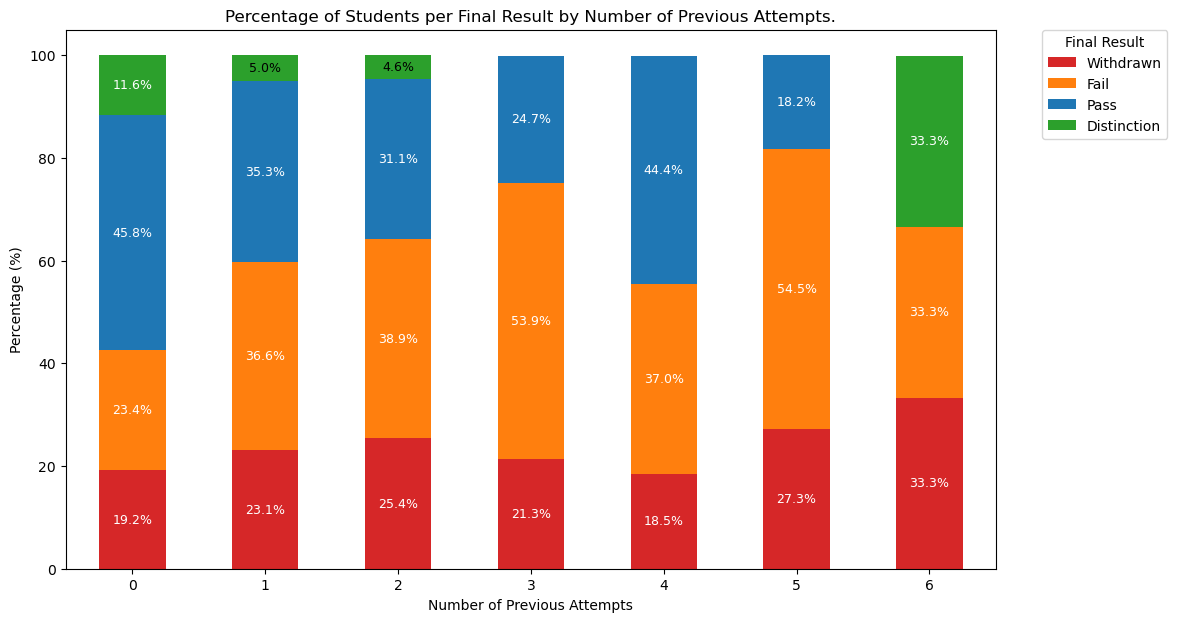

In [195]:
final_result_label = train_early.copy()
final_result_label['final_result_label'] = final_result_label['final_result'].map(final_result_mapping)
num_of_prev_attempts_result_counts = pd.crosstab(final_result_label['num_of_prev_attempts'], final_result_label['final_result_label']) # Create crosstab: module vs final result.
ordered_columns = ['Withdrawn', 'Fail', 'Pass', 'Distinction'] # Ensure correct stacked order.
num_of_prev_attempts_result_counts = num_of_prev_attempts_result_counts[ordered_columns]

# Convert module counts to percentage.
num_of_prev_attempts_result_pct = round(num_of_prev_attempts_result_counts.div(num_of_prev_attempts_result_counts.sum(axis=1), axis=0) * 100, 1)

ax = num_of_prev_attempts_result_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=[custom_colors[col] for col in ordered_columns]
)

# Add annotations.
for bar_idx, module in enumerate(num_of_prev_attempts_result_pct.index):
    cumulative_height = 0
    for result in ordered_columns:
        height = num_of_prev_attempts_result_pct.loc[module, result]
        if height > 0:
            ax.text(
                bar_idx,
                cumulative_height + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if height > 10 else 'black')
            cumulative_height += height

plt.title('Percentage of Students per Final Result by Number of Previous Attempts.')
plt.xlabel('Number of Previous Attempts')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#### Observations

* Students with no previous attempts have the best outcomes, with a withdrawal rate of 19.2%, fail rate of 23.4%, pass rate of 45.8%, and distinction rate of 11.6%.

* As the number of previous attempts increases, withdrawal and fail rates generally rise, while pass and distinction rates decline. For example, students with one or two previous attempts show higher withdrawal (23.1% and 25.5%) and fail rates (36.6% and 38.9), and lower pass rates (35.3% and 31.1%).

* Students with three or more previous attempts face the worst outcomes, with withdrawal rates reaching up to 33%, fail rates up to 54%, and very low or zero distinction rates.

Overall, repeated attempts correlate with poorer final results, indicating challenges for students retaking modules multiple times.

### Studied Credits

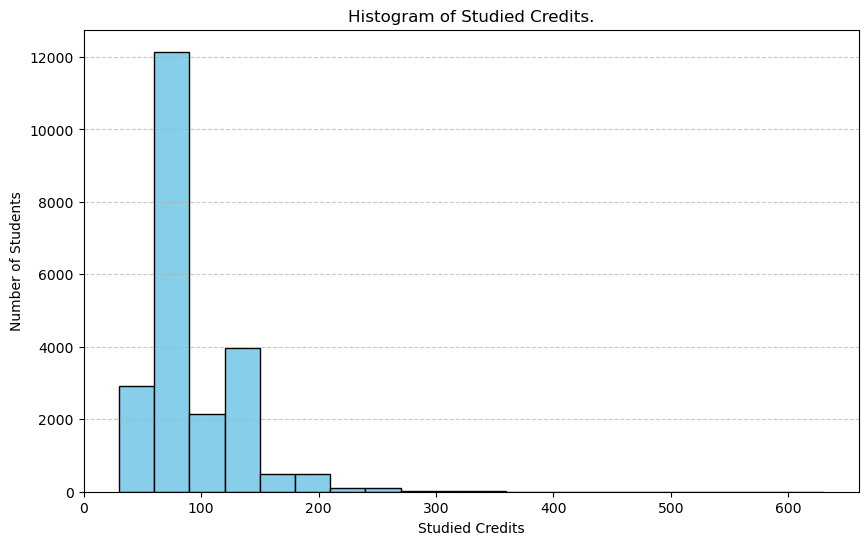

In [196]:
# Plot histogram for `studied_credits`.
plt.figure(figsize=(10, 6))
plt.hist(train_early['studied_credits'], bins=range(30, 660, 30), color='skyblue', edgecolor='black')
plt.xlabel('Studied Credits')
plt.ylabel('Number of Students')
plt.title('Histogram of Studied Credits.')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most students have around 60 credits for their module. While credit values extend up between 200 and 650, such high values are extremely rare. A box and whisker plot will help us visualise the spread and identify any outliers.

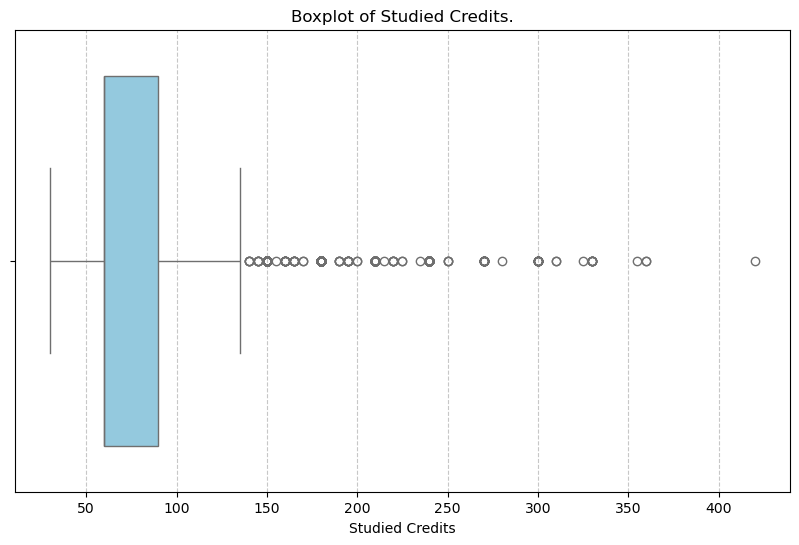

In [197]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_early['studied_credits'], color='skyblue')
plt.xlabel('Studied Credits')
plt.title('Boxplot of Studied Credits.')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The majority of students have studied between 60 and 120 credits. Credit values above 210 are uncommon and mostly considered outliers.

In [198]:
credit_results = train_early[train_early['studied_credits'] > 210]['final_result'].value_counts()
credit_results

final_result
0    67
2    50
1    41
3     7
Name: count, dtype: int64

Most students with over 210 credits have either withdrawn (183) or failed (46), suggesting that having more credits increases the dropout and fail rates.

### Total Clicks

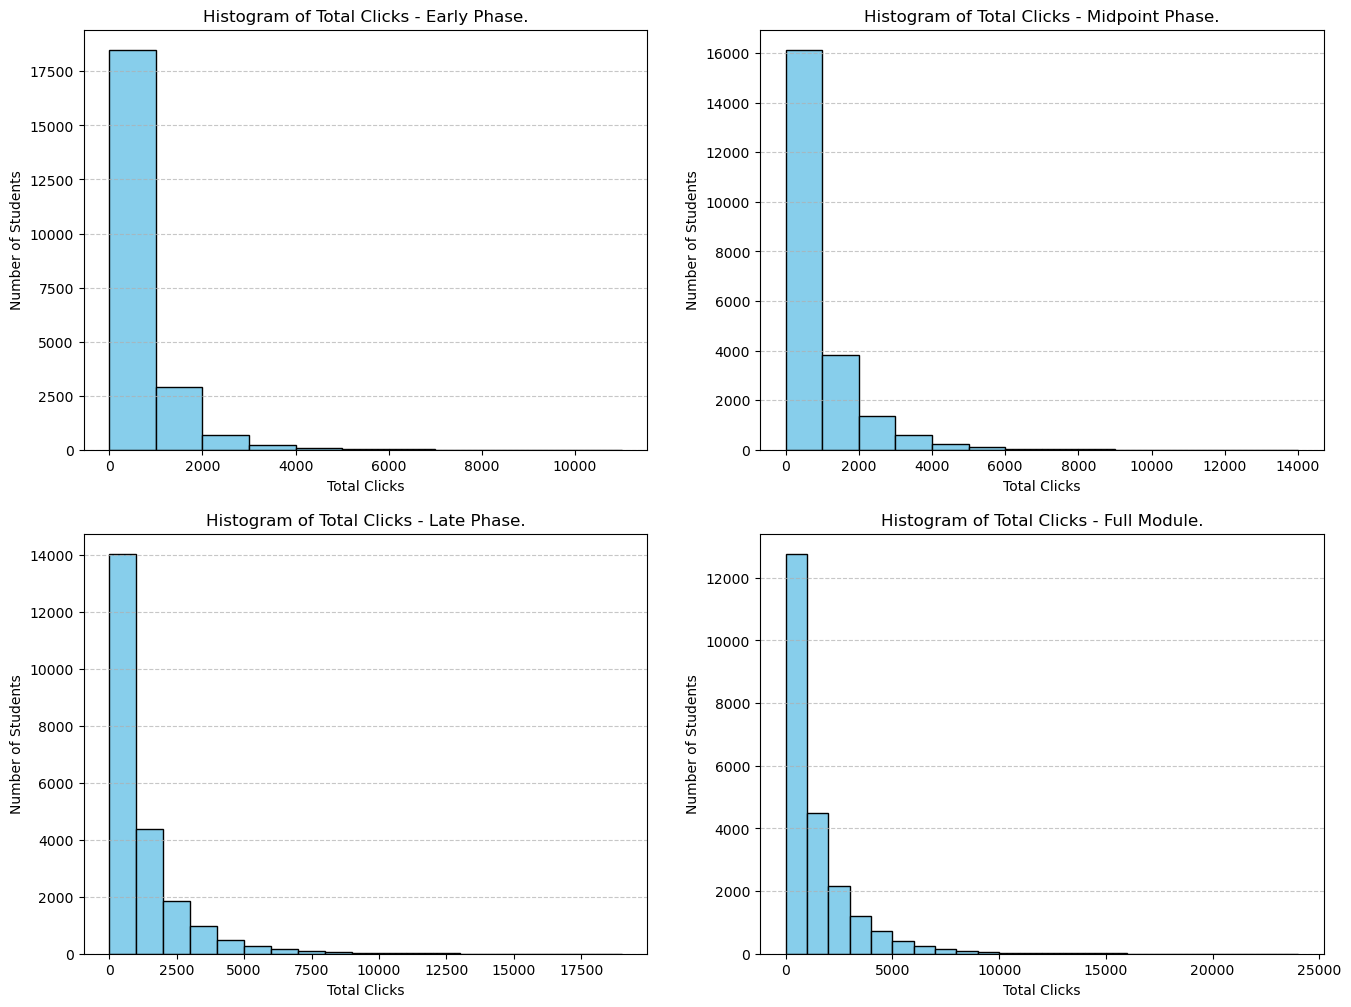

In [199]:
# Define datasets and custom bin ranges.
train_datasets_total_clicks_hist = {
    'Early Phase': (train_early, range(0, 12000, 1000)),
    'Midpoint Phase': (train_midpoint, range(0, 15000, 1000)),
    'Late Phase': (train_late, range(0, 20000, 1000)),
    'Full Module': (train_full, range(0, 25000, 1000))
}

# plot histogram in a 2x2 grid.
plt.figure(figsize=(16, 12))
for i, (title, (df, bin_range)) in enumerate(train_datasets_total_clicks_hist.items(), 1):
    plt.subplot(2, 2, i)
    plt.hist(df['total_clicks'], bins=bin_range, color='skyblue', edgecolor='black')
    plt.xlabel('Total Clicks')
    plt.ylabel('Number of Students')
    plt.title(f'Histogram of Total Clicks - {title}.')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Observations:

* As the module progresses, the number of students with total VLE clicks in the 0–1,000 range steadily declines, from around 19,000 at the early phase, to around 14,000 in the late phase, and approximately 13,000 by the end of the module.

* Despite this decline, the majority of students consistently fall within the 0–1,000 click range throughout the module, while those with over 5,000 clicks remain relatively rare, even during the later stages. Next, we will use a box and whisker plot to highlight any outliers.

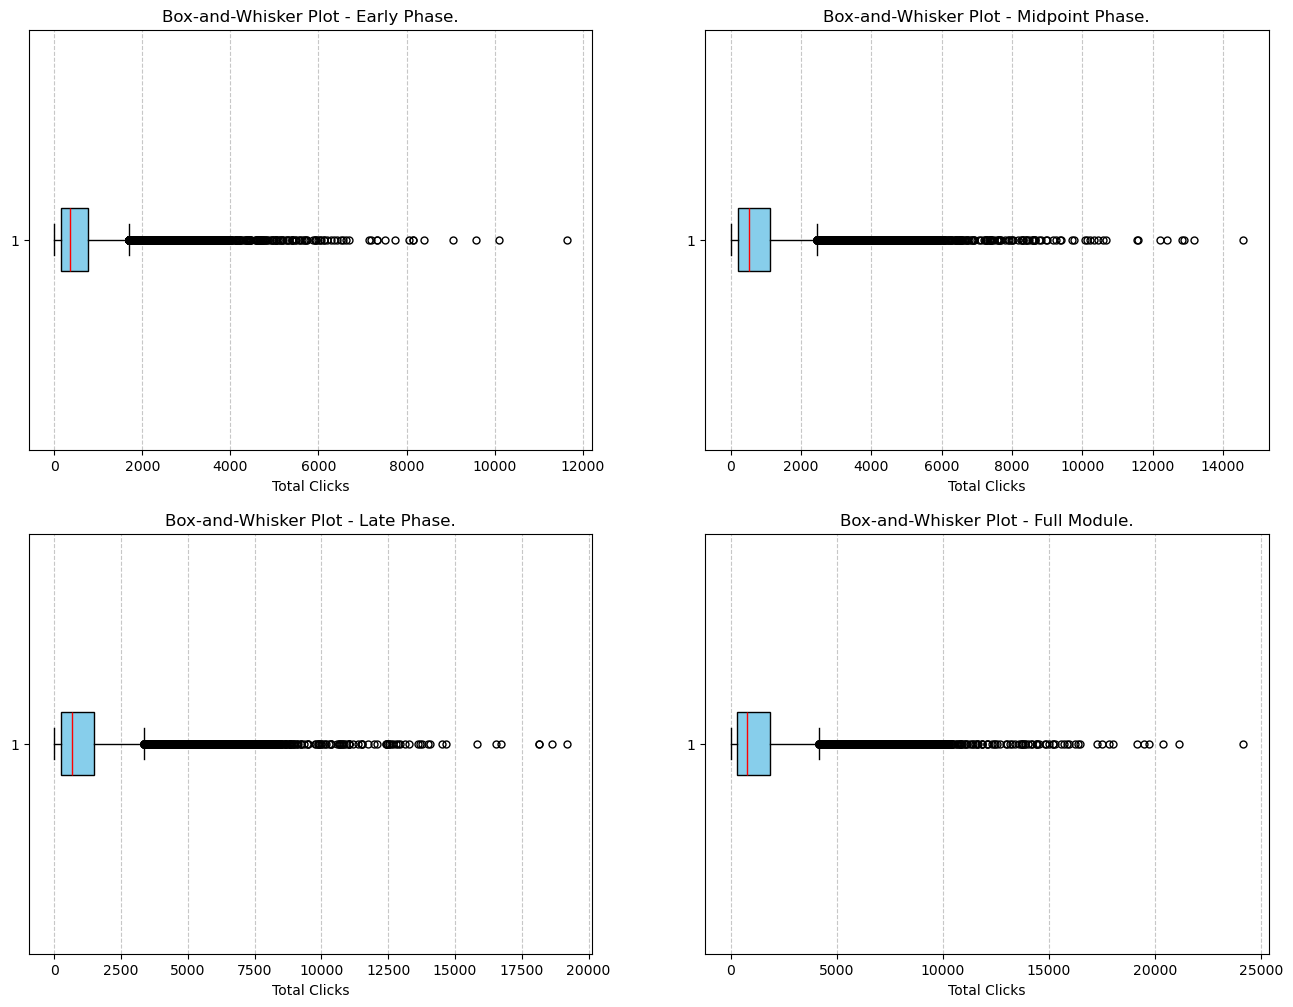

In [200]:
train_datasets_total_clicks_box_whisker = {
    'Early Phase': train_early,
    'Midpoint Phase': train_midpoint,
    'Late Phase': train_late,
    'Full Module': train_full
}

# Plot box-and-whisker plots horizontally in a 2x2 grid.
plt.figure(figsize=(16, 12))
for i, (title, df) in enumerate(train_datasets_total_clicks_box_whisker.items(), 1):
    plt.subplot(2, 2, i)
    plt.boxplot(df['total_clicks'], vert=False, patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='black'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(marker='o', color='black', markersize=5))
    
    plt.xlabel('Total Clicks')
    plt.title(f'Box-and-Whisker Plot - {title}.')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

As the module progresses, the number of outliers increases, and both the box and quartiles gradually shift to the right, reflecting a rise in total clicks as students accumulate more activity on the VLE over time.

### Days Active (Normalised)

This feature is a binary value ranging from 0 to 1 that represents how consistently a student engaged with the VLE relative to the module's timeline. For example, if the midpoint phase spans 150 days, the value reflects the proportion of those days the student was active. A value of 1 indicates daily engagement throughout the period, while 0 means the student did not engage at all.

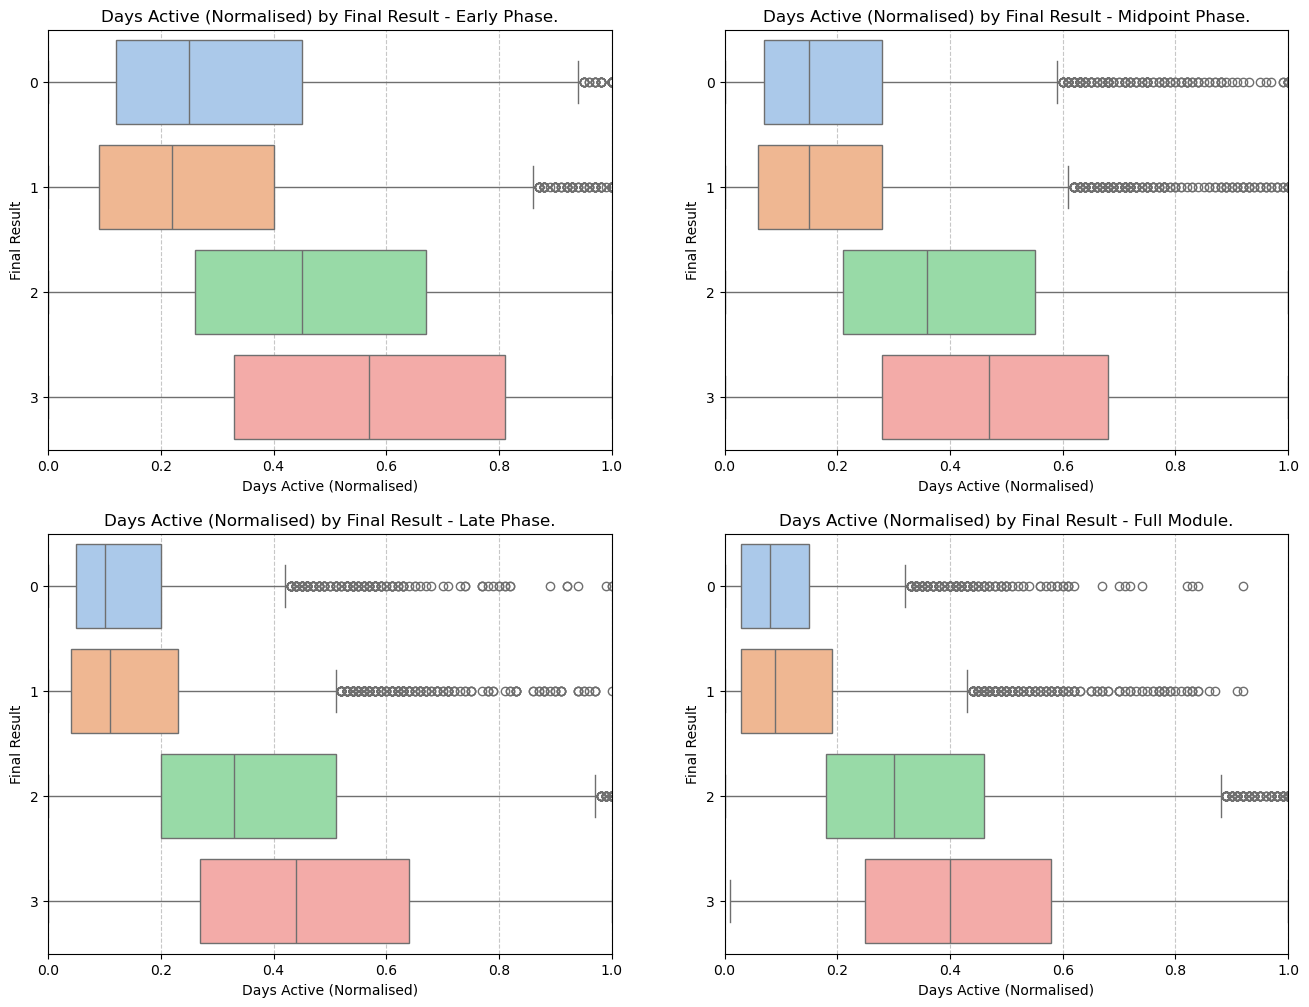

In [201]:
train_datasets_final_result_days_active_box_whisker = {
    'Early Phase': train_early,
    'Midpoint Phase': train_midpoint,
    'Late Phase': train_late,
    'Full Module': train_full
}

# Plot horizontal boxplots in a 2x2 grid.
plt.figure(figsize=(16, 12))
for i, (title, df) in enumerate(train_datasets_final_result_days_active_box_whisker.items(), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y='final_result', x='days_active_norm', orient='h', hue='final_result', palette='pastel', legend=False, showfliers=True)
    plt.title(f'Days Active (Normalised) by Final Result - {title}.')
    plt.xlabel('Days Active (Normalised)')
    plt.ylabel('Final Result')
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Observations:

* Withdrawn (0)
    * Sharp decline in activity over time.
    * Median drops from 0.25 (Early) → 0.15 (Midpoint) → 0.1 (Late) → 0.09 (Full).
    * 75% of withdrawn students remain very inactive, indicating early disengagement and no recovery later.
    * However, there are still many outliers where students are more active than the top 75% of students who have withdrawn.

* Fail (1)
    * Consistently low engagement across phases.
    * Median falls from 0.22 (Early) → 0.15 (Midpoint) → 0.11 (Late) → 0.09 (Full).
    * Activity fades over time, possibly indicating a slow drop-off after initial attempts.
    * Similar to the withdrawed students, there are many outlier students who have more engagement than the top 75% of students who have failed.

* Pass (2)
    * Moderate engagement, but it gradually declines over phases.
    * Median drops from 0.45 (Early) → 0.36 (Midpoint) → 0.33 (Late) → 0.30 (Full).
    * These students remain fairly active, but less so as the module progresses.

* Distinction (3)
    * Most active and consistent group.
    * Median decreases from 0.57 (Early) → 0.47 (Midpoint) → 0.44 (Late) → 0.40 (Full).
    * Still shows strong activity even in late phases, though with a slight downward trend.


Across all outcomes, students show a general decline in activity over time, but the relative order remains clear, those who achieve distinction or pass consistently stay more engaged than those who fail or withdraw. The gaps in median values between the groups widen in later phases, reinforcing how sustained activity relates to success.

### Activity Type

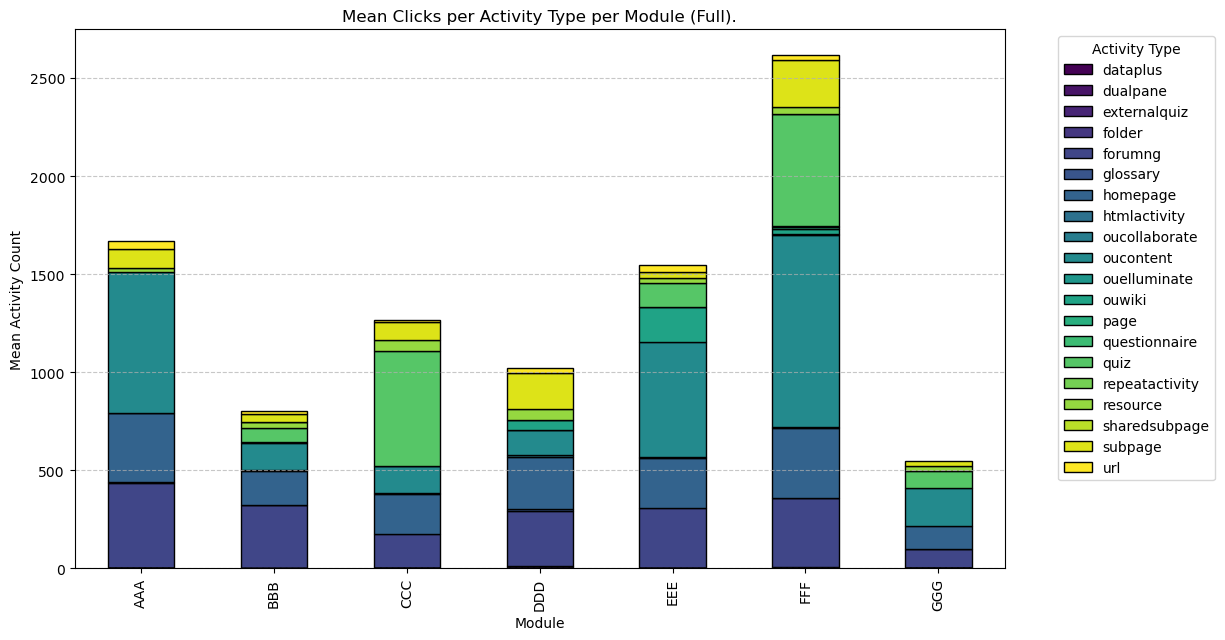

In [202]:
activity_types = ['dataplus', 'dualpane', 'externalquiz', 'folder', 'glossary', 'htmlactivity', 
                  'oucollaborate', 'oucontent', 'ouelluminate', 'ouwiki', 'page', 'questionnaire',
                  'quiz', 'repeatactivity', 'resource', 'sharedsubpage', 'subpage', 'url', 
                  'forumng', 'homepage']

# Melt the activity columns into long format.
melted_mean_clicks_per_activity_type_per_module = train_full.melt(
    id_vars='code_module',
    value_vars=activity_types,
    var_name='activity_type',
    value_name='count'
)

# Calculate mean clicks per module and activity type.
activity_means = (
    melted_mean_clicks_per_activity_type_per_module.groupby(['code_module', 'activity_type'])['count']
    .mean()
    .reset_index()
)

# Pivot to wide format for plotting.
pivot_mean_clicks_per_activity_type_per_module_df = activity_means.pivot(index='code_module', columns='activity_type', values='count').fillna(0)
pivot_mean_clicks_per_activity_type_per_module_df.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis', edgecolor='black') # Plot stacked bar chart.
plt.title('Mean Clicks per Activity Type per Module (Full).')
plt.xlabel('Module')
plt.ylabel('Mean Activity Count')
plt.legend(title='Activity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Observations

* High engagement activities vary by module:
    * For example, in module AAA, oucontent has a very high mean click count (about 710), indicating that students spend a lot of time on core content there.
    * Module FFF shows high clicks for oucontent (around 850), quiz (about 495), and subpage (approximetley 208), indicating active use of those resources.

* Content-related activities dominate:
    * oucontent, resource, and page generally have higher average clicks across modules, reflecting that core learning materials attract most student interactions.

* Quizzes and questionnaires vary widely:
    * Some modules (like CCC and FFF) have high average clicks on quiz, while others show low to almost none.

### Banked Rate

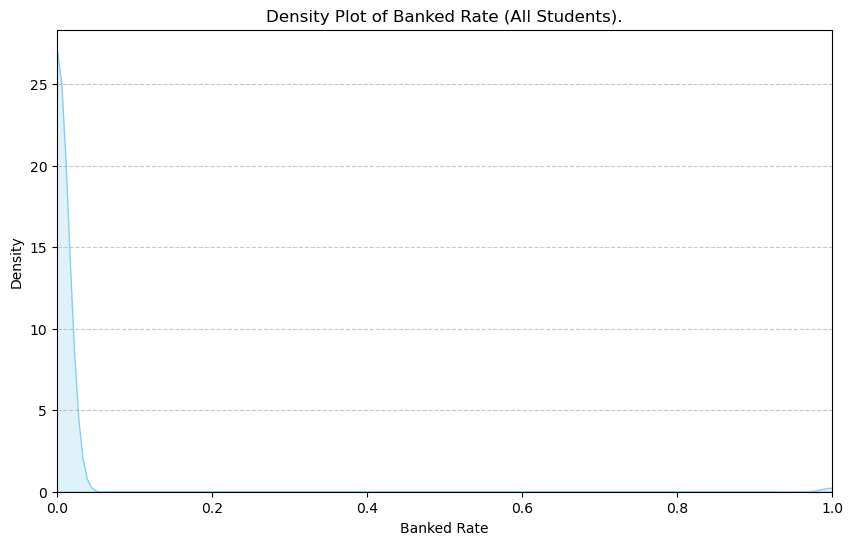

In [203]:
plt.figure(figsize=(10, 6))
sns.kdeplot(train_full['banked_rate'], fill=True, color='skyblue')
plt.title('Density Plot of Banked Rate (All Students).')
plt.xlabel('Banked Rate')
plt.ylabel('Density')
plt.xlim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [204]:
banked_rate_less_than_0_1 = train_full[train_full['banked_rate'] < 0.1]['banked_rate'].value_counts()
print('banked_rate less than 0.1\n', banked_rate_less_than_0_1)

banked_rate less than 0.1
 banked_rate
0.00    21972
0.09        4
Name: count, dtype: int64


In [205]:
banked_rate_greater_than_0_9 = train_full[train_full['banked_rate'] > 0.9]['banked_rate'].value_counts()
print('banked_rate less than 0.1\n', banked_rate_greater_than_0_9)

banked_rate less than 0.1
 banked_rate
1.00    200
0.91      1
Name: count, dtype: int64


The vast majority of students do not have assessment results carried over from a previous presentation.

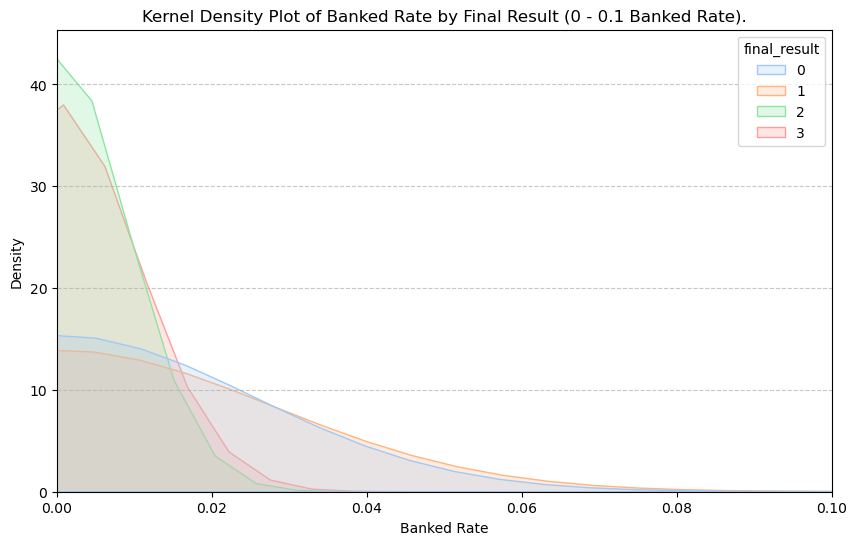

In [206]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_full, x='banked_rate', hue='final_result', fill=True, common_norm=False, palette='pastel')
plt.title('Kernel Density Plot of Banked Rate by Final Result (0 - 0.1 Banked Rate).')
plt.xlabel('Banked Rate')
plt.ylabel('Density')
plt.xlim(0, 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Students who fail or withdraw appear to have a marginally higher banked rate, although the difference is minimal. Let us move on to `final_results`.

### Final Result

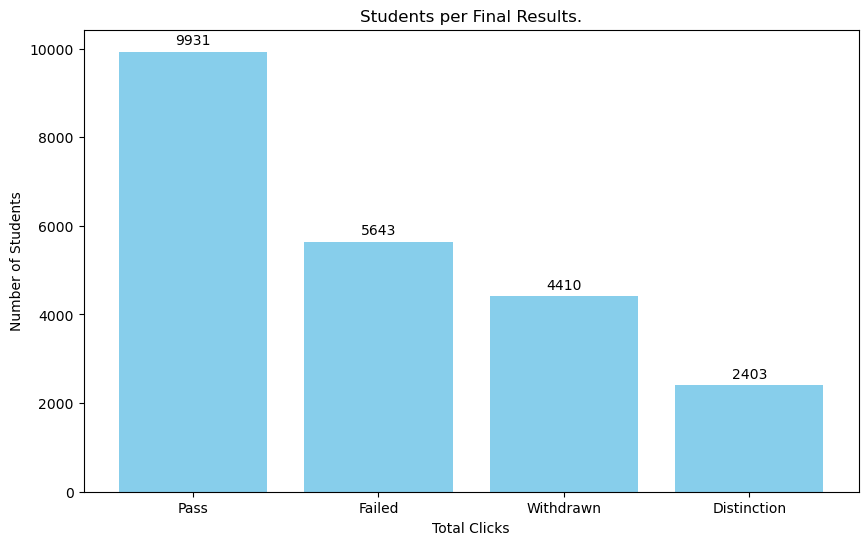

In [207]:
final_result_counts = train_full['final_result'].value_counts()
final_result_counts.index = final_result_counts.index.map({3: 'Distinction', 2: 'Pass', 1: 'Failed', 0: 'Withdrawn'})

plot_bar_with_annotations(
    categories=final_result_counts.index.tolist(),
    counts=final_result_counts.values.tolist(),
    xlabel='Total Clicks',
    ylabel='Number of Students',
    title='Students per Final Results.',
    figsize=(10,6)
)

The `final_result` column is our target variable. In the training set, the majority of students have passed, making up about 44%, followed by failed students at 25%. Withdrawn students represent about 20%, while those who passed with distinction have the smallest share around 11% of the train set.

### Weighted Score

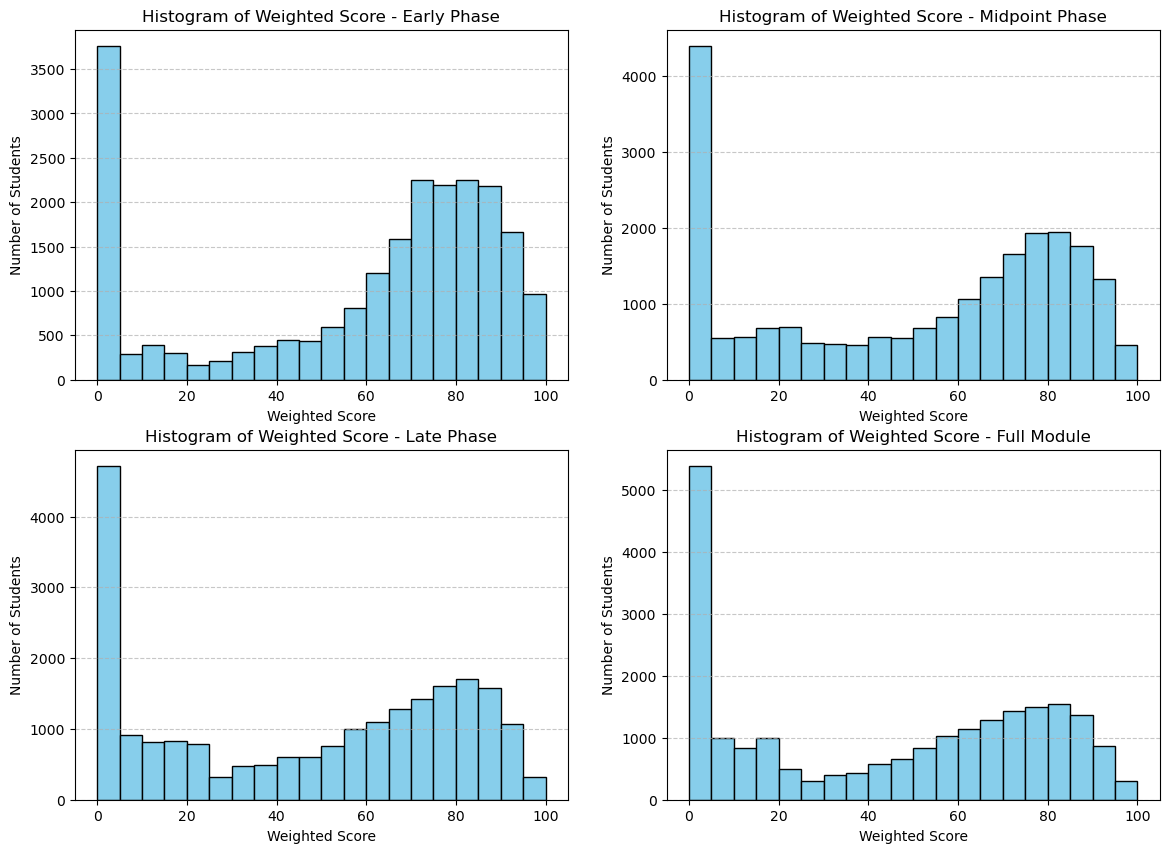

In [208]:
train_datasets_weighted_score_hist = {
    'Early Phase': train_early,
    'Midpoint Phase': train_midpoint,
    'Late Phase': train_late,
    'Full Module': train_full
}

plt.figure(figsize=(14, 10))

for i, (phase, df) in enumerate(train_datasets_weighted_score_hist.items(), 1):
    plt.subplot(2, 2, i)
    plt.hist(df['weighted_score'], bins=range(0, 105, 5), color='skyblue', edgecolor='black')
    plt.xlabel('Weighted Score')
    plt.ylabel('Number of Students')
    plt.title(f'Histogram of Weighted Score - {phase}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Observations:.

* Early Phase:
    * About 3,250 students are in the 0–5 range, indicating very low engagement or progress at this point.
    * Score distribution begins to grow noticeably from 60 onwards, peaking at 70–75 (Around 2,300 students).
    * By this stage, some students already have high scores (e.g. about 1000 students with perfect 95-100).

* Midpoint Phase:
    * Still about 4,700 students in the 0–5 range, though slightly more students are scoring in the 20–60 band.
    * The mode (most common score band) shifts to 80–85 (approximately 1,950 students), showing improvement in score distribution as assessments accumulate.
    * Very few students achieve full marks yet (less than 500 students with 95-100 score).

* Late Phase:
    * The number of students in the 0–5 band increases slightly to about 4,800, which might include withdrawn or inactive students.
    * A stronger concentration appears in the 70–90 range.
    * Peak still lies around 80–85.
    * Small number of high performers remain (roughly 300 students with 95-100).

* Full Module:
    * About 5,600 students still remain in the 0–5 range, most likely those who dropped out or failed to participate fully.
    * The score distribution has now matured, with strong peaks around 75–90, showing the final result of all assessments.
    * Overall, only about 200 students have weighted scores beteen 95-100.

Let us now assess the reliability of the `weighted_score` by comparing it with the `final_result` column, which appears to be the most dependable indicator of student performance, as it is complete and did not require any imputation or contain any missing values.

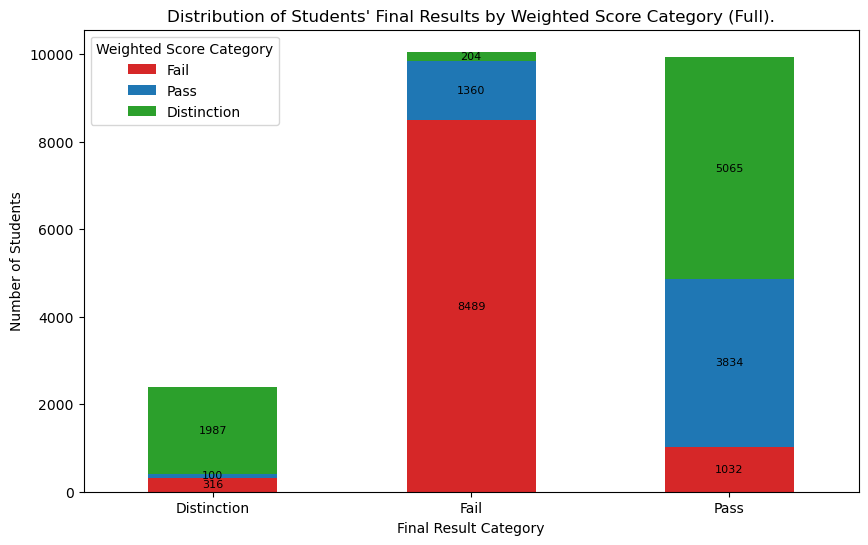

In [209]:
# Create score category. Less than 40 is fail, between 40 and 69 is considered pass and above that is distinction.
def score_category(score):
    if pd.isna(score):
        return 'Unknown'
    elif score < 40:
        return 'Fail'
    elif score <= 69:
        return 'Pass'
    else:
        return 'Distinction'

final_result_and_weighted_score_df = train_full.copy()

# Map numerical codes to strings for clarity in plotting.
final_result_mapping = {
    0: 'Fail', # Withdrawn treated as fail.
    1: 'Fail',
    2: 'Pass',
    3: 'Distinction'
}
final_result_and_weighted_score_df['final_result'] = final_result_and_weighted_score_df['final_result'].map(final_result_mapping)
final_result_and_weighted_score_df['score_category'] = final_result_and_weighted_score_df['weighted_score'].apply(score_category) # Apply score categorisation.
weighted_score_grouped = final_result_and_weighted_score_df.groupby(['final_result', 'score_category']).size().unstack(fill_value=0) # Count values.

ax = weighted_score_grouped[['Fail', 'Pass', 'Distinction']].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#d62728', '#1f77b4', '#2ca02c']
)

plt.title("Distribution of Students' Final Results by Weighted Score Category (Full).")
plt.xlabel('Final Result Category')
plt.ylabel('Number of Students')
plt.legend(title='Weighted Score Category')
plt.xticks(rotation=0)

# Add annotations.
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                    ha='center', va='center',
                    fontsize=8, xytext=(0, 0),
                    textcoords='offset points')
plt.show()

While we already expected that `weighted_score` might not be fully reliable, this plot highlights just how inconsistent it can be. Although the score generally aligns with the `final_result`, there are numerous exceptions. For instance, in the distinction category, 416 students (316 fail + 100 pass) had a weighted score below 70, yet were marked as achieving distinction scores. Similarly, in the fail group (which includes withdrawn students), 1,360 students had a weighted score high enough to pass, and 204 scored high enough for distinction, despite not completing the module successfully.

In the pass category, 1,032 students had scores below 40 (which means failed), and 5,065 scored above 70 but were only awarded a pass. These discrepancies stem from missing exam assessment data, leading to incomplete or skewed weighted scores that do not fully reflect students' true performance. As a result, `weighted_score` should be treated with caution and not used as a standalone indicator of student success.

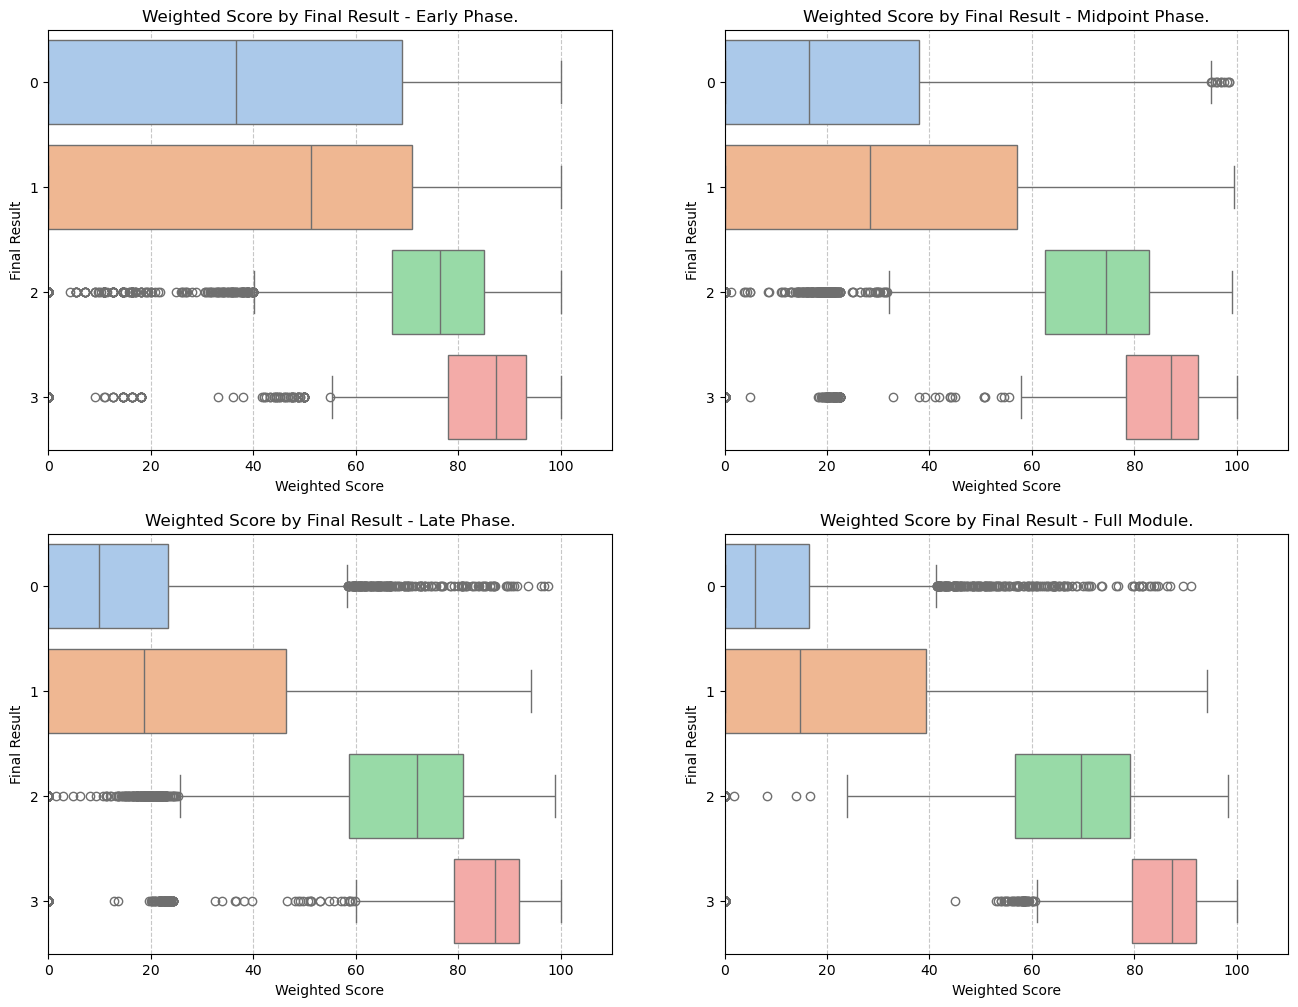

In [210]:
train_datasets_final_result_weighted_score_box_whisker = {
    'Early Phase': train_early,
    'Midpoint Phase': train_midpoint,
    'Late Phase': train_late,
    'Full Module': train_full
}

# Plot horizontal boxplots in a 2x2 grid.
plt.figure(figsize=(16, 12))
for i, (title, df) in enumerate(train_datasets_final_result_weighted_score_box_whisker.items(), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y='final_result', x='weighted_score', orient='h', hue='final_result', palette='pastel', legend=False, showfliers=True)
    plt.title(f'Weighted Score by Final Result - {title}.')
    plt.xlabel('Weighted Score')
    plt.ylabel('Final Result')
    plt.xlim(0, 110)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Late Rate

Similar to the weighted score, both the late rate and, by extension, the fail rate depend on incomplete assessment data, particularly missing exam results, making them less than fully reliable. However, they can still provide some interesting insights.

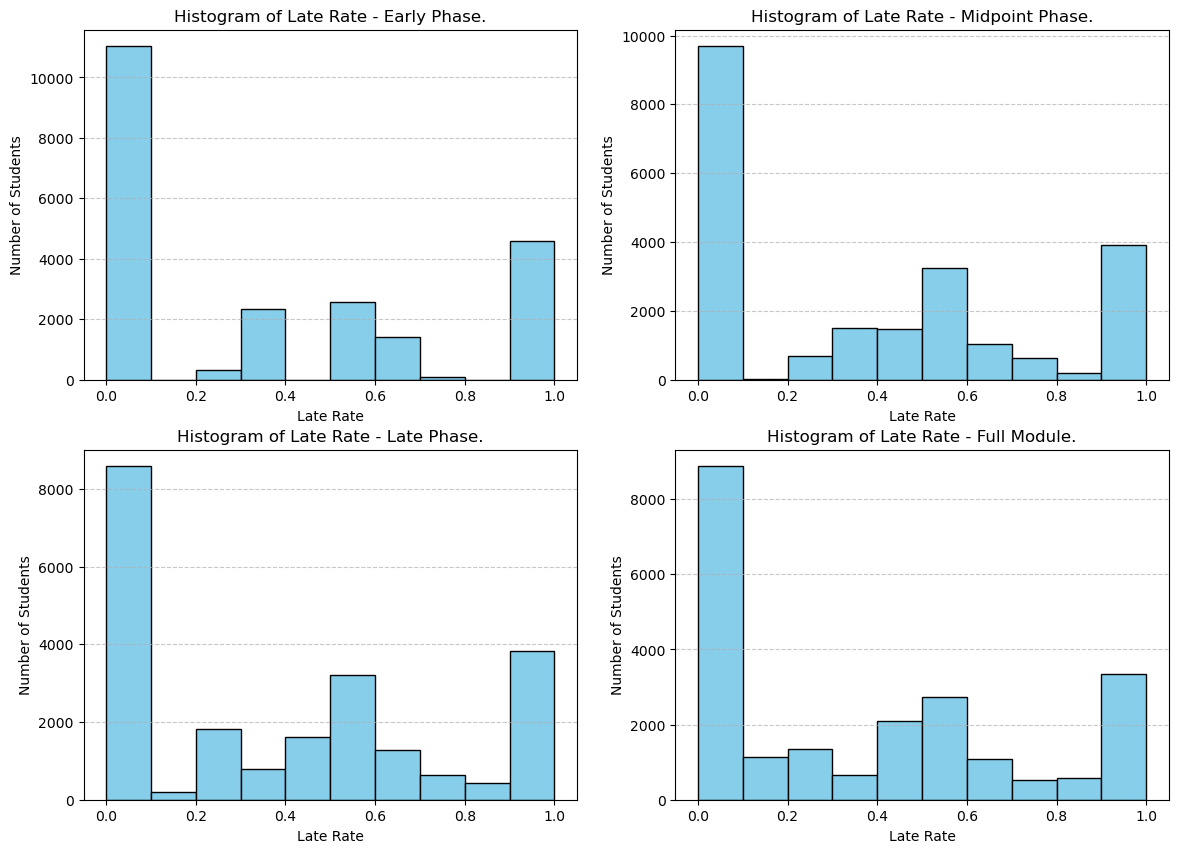

In [211]:
train_datasets_late_rate_hist = {
    'Early Phase': train_early,
    'Midpoint Phase': train_midpoint,
    'Late Phase': train_late,
    'Full Module': train_full
}

plt.figure(figsize=(14, 10))

for i, (phase, df) in enumerate(train_datasets_late_rate_hist.items(), 1):
    plt.subplot(2, 2, i)
    plt.hist(df['late_rate'], color='skyblue', edgecolor='black')
    plt.xlabel('Late Rate')
    plt.ylabel('Number of Students')
    plt.title(f'Histogram of Late Rate - {phase}.')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Observations

* Early Phase
    * Majority (11,200+ students) have a very low late rate (0–0.10), suggesting they submitted most or all assignments on time.
    * A second peak appears at 50–60% late rate, affecting about 2,500 students.
    * Zero activity in some bins (e.g., 10–20%, 40–50%, 80–90%), which might reflect batch submission behaviours or system recording patterns.
    * There about 4,400 students who have submitted all of their assignments late.

* Midpoint Phase
    * Still, the largest group (just under 10,000) is on time with <10% late rate.
    * A more spread-out distribution emerges, with moderate groups across 20–80% late bins.
    * There's a noticeable increase in high `late_rate` groups compared to the early phase, especially in 40–50% and 50–60% bins.

* Late Phase
    * Students start submitting more late assignments, with a peak still at 0–10%, but significant numbers in 20–60% ranges (e.g. about 3,200 students at 50–60%).
    * The distribution is flatter, meaning late submission becomes more common.

* Full Module
    * Pattern continues: on-time submissions dominate (0–10%), but a visible tail across the entire range, especially 40–60% and beyond.
    * There is a decline in the number of students with 90-100% late rate, falling to less than 3,700.
    * Apart from the first and last bins, the next highest are at 50–60% and 40–50%, showing accumulated lateness across the course.

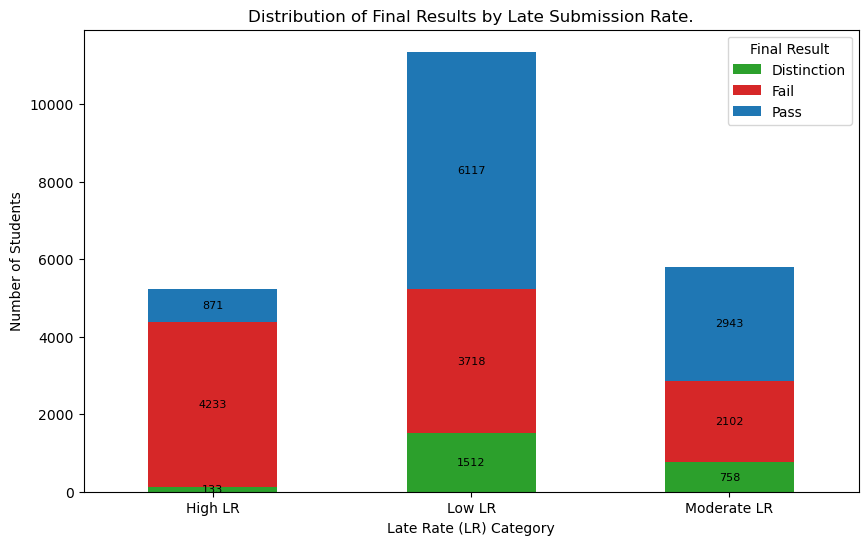

In [212]:
# Create late rate category. Less than 33 is low, between 34 and 66 is considered moderate and above that is high late submission rate.
def late_rate_category(score):
    if pd.isna(score):
        return 'Unknown'
    elif score < 0.33:
        return 'Low LR'
    elif score < 0.66:
        return 'Moderate LR'
    else:
        return 'High LR'

final_result_and_late_rate_df = train_full.copy()
final_result_and_late_rate_df['final_result'] = final_result_and_late_rate_df['final_result'].map(final_result_mapping)
final_result_and_late_rate_df['late_rate_category'] = final_result_and_late_rate_df['late_rate'].apply(late_rate_category) # Apply score categorisation.
late_rate_grouped = final_result_and_late_rate_df.groupby(['final_result', 'late_rate_category']).size().unstack(fill_value=0) # Count values.

ax = late_rate_grouped.T.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#2ca02c', '#d62728', '#1f77b4']  # colors per final_result category.
)

plt.xlabel('Late Rate (LR) Category')
plt.ylabel('Number of Students')
plt.title("Distribution of Final Results by Late Submission Rate.")
plt.legend(title='Final Result')
plt.xticks(rotation=0)

# Add annotations.
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                    ha='center', va='center',
                    fontsize=8, xytext=(0, 0),
                    textcoords='offset points')
plt.show()

#### Observations:

* Most students who failed have a high late rate (4,233), while a smaller number have low (3,718) or moderate (2,102) late rates. This suggests a strong association between frequent late submissions and failing.

* Pass students tend to have mostly low late rates (6,117), followed by moderate (2,943) and relatively few with high late rates (871). This indicates that students who submit on time or with fewer delays are more likely to pass.

* Distinction students primarily have low late rates (1,512), with fewer in moderate (758) and very few with high late rates (133), suggesting timely submissions correlate with higher achievement.

* Overall, the plot shows that students with fewer late submissions tend to perform better, while frequent late submission is common among students who fail. Now let us move on to the fail rate.

### Fail Rate

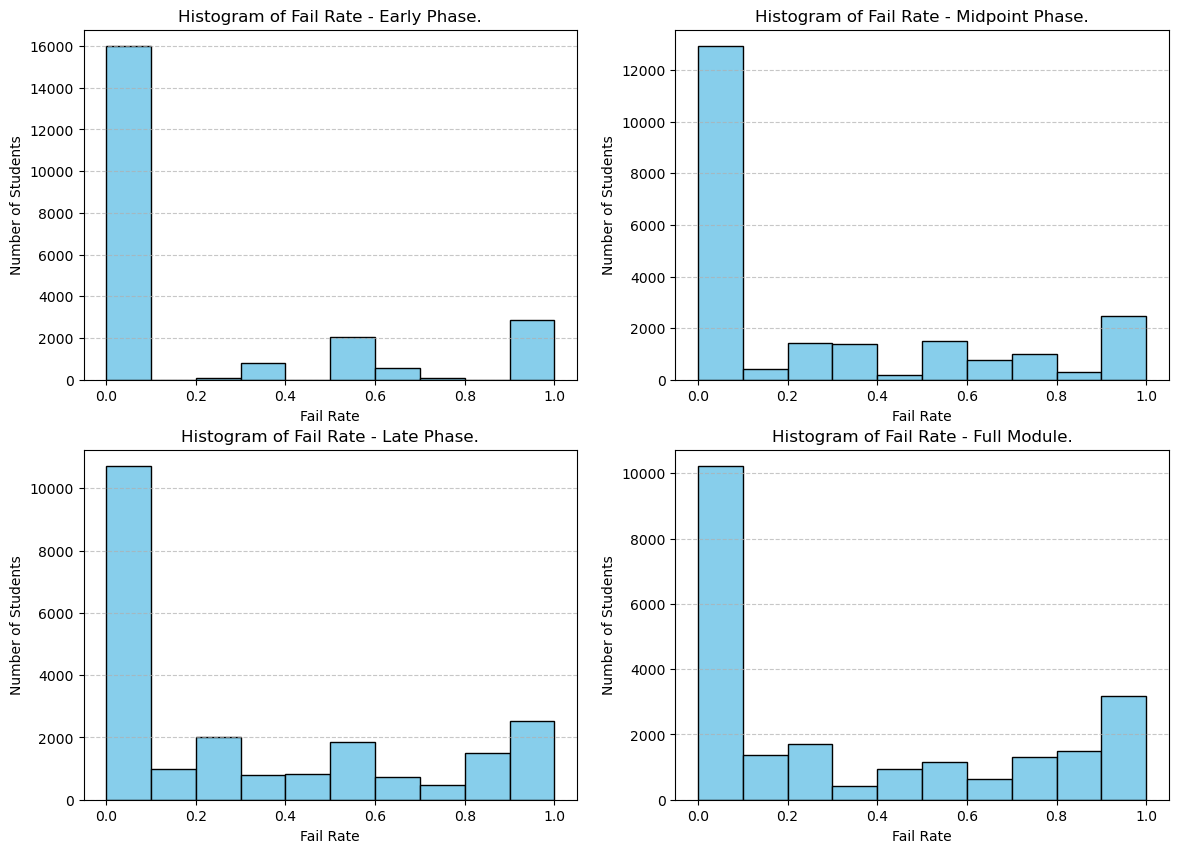

In [213]:
train_datasets_fail_rate_hist = {
    'Early Phase': train_early,
    'Midpoint Phase': train_midpoint,
    'Late Phase': train_late,
    'Full Module': train_full
}

plt.figure(figsize=(14, 10))

for i, (phase, df) in enumerate(train_datasets_fail_rate_hist.items(), 1):
    plt.subplot(2, 2, i)
    plt.hist(df['fail_rate'], color='skyblue', edgecolor='black')
    plt.xlabel('Fail Rate')
    plt.ylabel('Number of Students')
    plt.title(f'Histogram of Fail Rate - {phase}.')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Observations

* Early Phase
    * Majority of students (16,000) have a fail rate below 10%, suggesting most of their assessments were passed.
    * A smaller peak at 50–60% fail rate (about 2,100 students) indicates some early struggling groups.
    * Many bins (10–20%, 40–50%, 80–90%) have zero entries, suggesting concentrated failure patterns.
    * There are more than 2,900 students who have fail rates between 95-100%.

* Midpoint Phase
    * This time the number of students with 0-10% fail rate falls drastically to around 13,000 students.
    * Moreover, failures spread more evenly, with substantial counts in 20–40% fail rate range (1,400+ students each).
    * Students with fail rates between 95-100% decline slightly.

* Late Phase
    * Fewer students (10,700) have a very low fail rate in the 0–10% bin.
    * Higher bins (especially 20–30%, 50–60%, and 80–90%) gain more students.
    * A shift toward higher fail rates becomes clearer, with failures accumulating as the course progresses.

* Full Module
    * The 0–10% fail rate bin falls again but remains highest (approximately 10,100 students), but the tail is heavier as more students fall into high fail rate bins like 70–90%.
    * Students in the 95-100% bin increases to all time high to about 3,100 students.

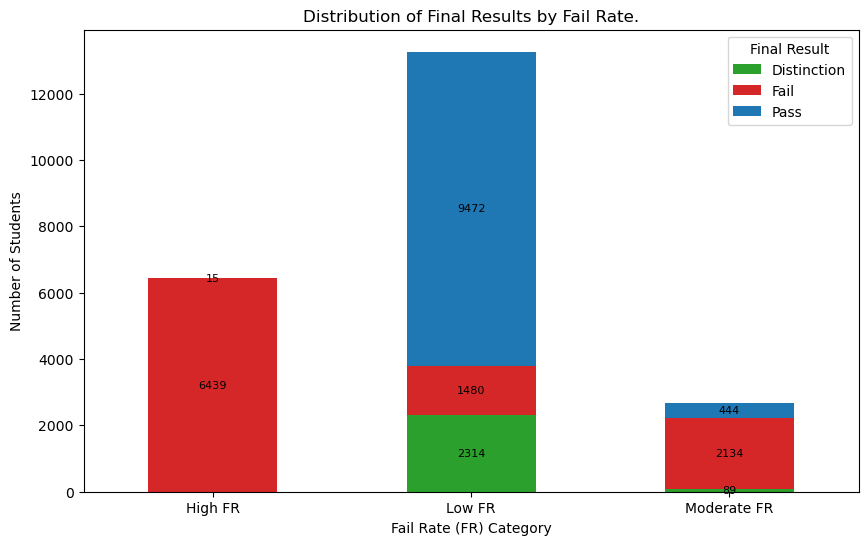

In [214]:
# Create fail rate category. Less than 33 is low, between 34 and 66 is considered moderate and above that is high fail rate.
def fail_rate_category(score):
    if pd.isna(score):
        return 'Unknown'
    elif score < 0.33:
        return 'Low FR'
    elif score < 0.66:
        return 'Moderate FR'
    else:
        return 'High FR'

final_result_and_fail_rate_df = train_full.copy()
final_result_and_fail_rate_df['final_result'] = final_result_and_fail_rate_df['final_result'].map(final_result_mapping)
final_result_and_fail_rate_df['fail_rate_category'] = final_result_and_fail_rate_df['fail_rate'].apply(fail_rate_category) # Apply score categorisation.
fail_rate_grouped = final_result_and_fail_rate_df.groupby(['final_result', 'fail_rate_category']).size().unstack(fill_value=0) # Count values.

ax = fail_rate_grouped.T.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#2ca02c', '#d62728', '#1f77b4']   # colors per final_result category.
)

plt.xlabel('Fail Rate (FR) Category')
plt.ylabel('Number of Students')
plt.title("Distribution of Final Results by Fail Rate.")
plt.legend(title='Final Result')
plt.xticks(rotation=0)

# Add annotations.
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                    ha='center', va='center',
                    fontsize=8, xytext=(0, 0),
                    textcoords='offset points')
plt.show()

#### Observations

* Students who earned distinctions all had low (<33%) to moderate (between 33% to 66%) fail rates.

* Most failing students had either low or high fail rates, suggesting two groups: one that barely attempted assessments (high FR) and one that tried but still failed (low FR).

* Nearly all passing students had low fail rates, with a tiny number in moderate or high FR.

## Correlation Matrix

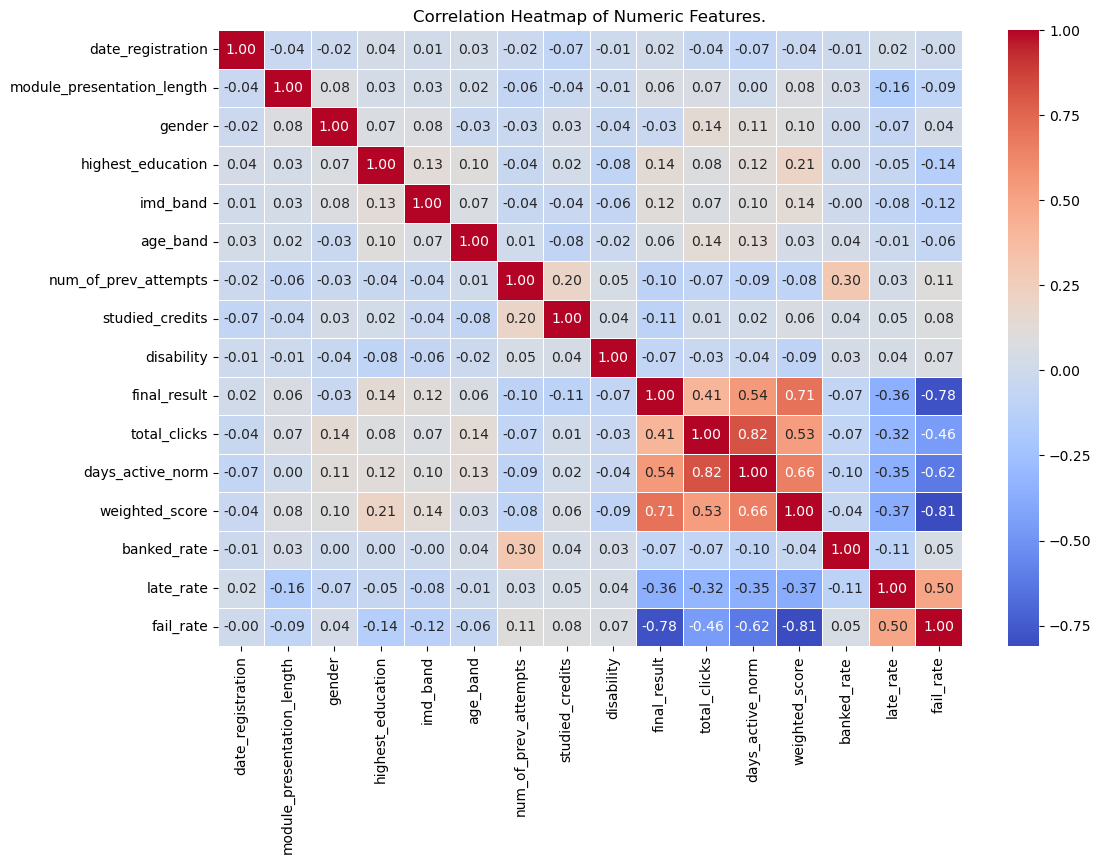

In [215]:
# Identify columns that start with "has_".
has_features = [col for col in train_full.columns if col.startswith('has_')]
exclude_cols = activity_types + has_features + ['id_student'] # Full exclusion list.

# Select numeric columns excluding the unwanted features.
numeric_cols = train_full.select_dtypes(include=['number']).drop(columns=exclude_cols, errors='ignore')

# Compute and plot correlation matrix.
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features.")
plt.show()

### Observations for `final_result` correlation comparison:

* **Weighted Score:** Very strong positive correlation of 0.71. As expected, students with higher weighted scores are much more likely to pass or do well. This is a direct academic performance indicator.

* **days_active_norm** Strong correlation of 0.54, the more the student is active the higher chances of achieving better final results.

* **total_clicks:** Moderate positive correlation at 0.41. More interactions with the VLE tend to be associated with better results.

* **imd_band:** Weak positive correlation of 0.12. Students from less deprived areas (higher IMD band values) tend to perform slightly better.

* **highest_education:** Weak positive correlation of 0.14. Students with higher prior education levels tend to achieve better outcomes.

* **age_band:** Very weak positive correlation of 0.06. Older students may perform slightly better, though it's not significant.

* **date_registration:** Very weak to no correlation of 0.02. Students who register earlier does not have any noticeable effects the `final_results`.

* **fail_rate:** Strong negative correlation of -0.78. As expected, higher fail rates on assessments strongly relate to lower final result outcome.

* **late_rate:** Moderate negative correlation of -0.36. Submitting assessments late is highly associated with poorer outcomes.

* **num_of_previous_attempts:** Shows a slight negative correlation of -0.10 with final_result. This suggests that students who have retaken modules more often may struggle slightly more. While this touches on the re-enrolment hypothesis, that students who previously dropped out are more likely to do so again. The low correlation indicates that this relationship is very weak and not strongly supported by the data.

* **studied_credits:** Weak negative correlation of -0.11, possibly due to students taking on too many credits and being overwhelmed.

* **disability:** Weak negative correlation of -0.07. Students with disabilities may face additional challenges.

* **banked_rate:** Weak negative correlation of -0.07. Whether a result is reused (banked) doesn't strongly affect the final result. This feature will be dropped.

* **gender:** No significant correlation, gender appears neutral in relation to final outcome.

Apart from the main correlations with `final_result`. There are also a few interesting onces:

* Students with prior educational qualifications tend to score better (correlation: 0.21) academic background matters.

* Students with more attempts are more likely to have a higher banked rate (correlation: 0.30) they might be reusing past scores.

## Hypothesis

### Engagement Hypothesis

### Assessment Performance Hypothesis

###  Demographic Disparity Hypothesis:

* `Region` shows strong evidence of disparity, with dropout rates ranging from 22.8% (Ireland) to 35.5% (West Midlands), suggesting location significantly influences withdrawal likelihood.
* `Education level` offers moderate support, as students with higher prior qualifications tend to perform better.
* `Age band` provides weak evidence, with only a slight positive correlation to performance.
* Overall, ehe hypothesis is partially supported. The `region` and `education` have some influence, but `age` has minimal impact.

### Re-Enrollment Hypothesis:

* The `num_of_prev_attempts` feature shows a slight negative correlation of -0.08 with `final_result`. This suggests that students who have retaken modules more often may struggle slightly more. 

* While this touches on the re-enrolment hypothesis, that students who previously dropped out are more likely to do so again. The low correlation indicates that this relationship is very weak and not strongly supported by the data.

# Classfication Models

## Drop Unneeded Features

In [216]:
# Early dataset.
train_class_early = train_early.copy()
test_class_early = test_early.copy()

# Midpoint dataset.
train_class_midpoint = train_midpoint.copy()
test_class_midpoint = test_midpoint.copy()

# Late dataset.
train_class_late = train_late.copy()
test_class_late = test_late.copy()

# Full dataset.
train_class_full = train_full.copy()
test_class_full = test_full.copy()

### Train Dataset

In [217]:
# Early dataset.
# Drop unneeded columns.
train_class_early.drop(columns=['id_student'], inplace=True)
train_class_early.drop(columns=['combined_id'], inplace=True)

# Drop columns on assessments.
# train_class_early.drop(columns=['weighted_score'], inplace=True)
# train_class_early.drop(columns=['late_rate'], inplace=True)
# train_class_early.drop(columns=['fail_rate'], inplace=True)

# Midpoint dataset.
train_class_midpoint.drop(columns=['id_student'], inplace=True)
train_class_midpoint.drop(columns=['combined_id'], inplace=True)
# train_class_midpoint.drop(columns=['weighted_score'], inplace=True)
# train_class_midpoint.drop(columns=['late_rate'], inplace=True)
# train_class_midpoint.drop(columns=['fail_rate'], inplace=True)

# Late dataset.
train_class_late.drop(columns=['id_student'], inplace=True)
train_class_late.drop(columns=['combined_id'], inplace=True)
# train_class_late.drop(columns=['weighted_score'], inplace=True)
# train_class_late.drop(columns=['late_rate'], inplace=True)
# train_class_late.drop(columns=['fail_rate'], inplace=True)

# Full dataset.
train_class_full.drop(columns=['id_student'], inplace=True)
train_class_full.drop(columns=['combined_id'], inplace=True)
# train_class_full.drop(columns=['weighted_score'], inplace=True)
# train_class_full.drop(columns=['late_rate'], inplace=True)
# train_class_full.drop(columns=['fail_rate'], inplace=True)
train_class_full.head(5)

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,weighted_score,banked_rate,late_rate,fail_rate
0,AAA,2013J,-159.0,268,1,East Anglian Region,3,9.0,2,0,...,0.0,0.0,1.0,0.0,1.0,1.0,82.4,0.0,0.0,0.0
1,AAA,2013J,-53.0,268,0,Scotland,3,2.0,1,0,...,0.0,0.0,1.0,0.0,1.0,1.0,65.4,0.0,0.4,0.0
2,AAA,2013J,-52.0,268,0,South East Region,2,5.0,1,0,...,0.0,0.0,1.0,0.0,1.0,1.0,76.3,0.0,0.0,0.0
3,AAA,2013J,-176.0,268,0,West Midlands Region,1,5.0,0,0,...,0.0,0.0,1.0,0.0,1.0,1.0,55.0,0.0,1.0,0.4
4,AAA,2013J,-110.0,268,1,Wales,2,8.0,1,0,...,0.0,0.0,1.0,0.0,1.0,1.0,66.9,0.0,0.2,0.0


### Test Dataset

In [218]:
# Early dataset.
# Drop unneeded columns.
test_class_early.drop(columns=['id_student'], inplace=True)
test_class_early.drop(columns=['combined_id'], inplace=True)

# Drop columns on assessments.
# test_class_early.drop(columns=['weighted_score'], inplace=True)
# test_class_early.drop(columns=['late_rate'], inplace=True)
# test_class_early.drop(columns=['fail_rate'], inplace=True)

# Midpoint dataset.
test_class_midpoint.drop(columns=['id_student'], inplace=True)
test_class_midpoint.drop(columns=['combined_id'], inplace=True)
# test_class_midpoint.drop(columns=['weighted_score'], inplace=True)
# test_class_midpoint.drop(columns=['late_rate'], inplace=True)
# test_class_midpoint.drop(columns=['fail_rate'], inplace=True)

# Late dataset.
test_class_late.drop(columns=['id_student'], inplace=True)
test_class_late.drop(columns=['combined_id'], inplace=True)
# test_class_late.drop(columns=['weighted_score'], inplace=True)
# test_class_late.drop(columns=['late_rate'], inplace=True)
# test_class_late.drop(columns=['fail_rate'], inplace=True)

# Full dataset.
test_class_full.drop(columns=['id_student'], inplace=True)
test_class_full.drop(columns=['combined_id'], inplace=True)
# test_class_full.drop(columns=['weighted_score'], inplace=True)
# test_class_full.drop(columns=['late_rate'], inplace=True)
# test_class_full.drop(columns=['fail_rate'], inplace=True)
test_class_full.head(5)

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,has_quiz,has_repeatactivity,has_resource,has_sharedsubpage,has_subpage,has_url,weighted_score,banked_rate,late_rate,fail_rate
6,AAA,2013J,-29.0,268,0,North Western Region,2,9.0,0,0,...,0.0,0.0,1.0,0.0,1.0,1.0,72.5,0.0,0.4,0.0
7,AAA,2013J,-33.0,268,0,East Anglian Region,2,7.0,0,0,...,0.0,0.0,1.0,0.0,1.0,1.0,71.2,0.0,0.2,0.0
10,AAA,2013J,-47.0,268,0,East Anglian Region,2,2.0,0,0,...,0.0,0.0,1.0,0.0,1.0,1.0,73.7,0.0,0.2,0.0
12,AAA,2013J,-68.0,268,0,North Western Region,3,5.0,0,0,...,0.0,0.0,1.0,0.0,1.0,1.0,76.4,0.0,0.0,0.0
15,AAA,2013J,-95.0,268,0,West Midlands Region,2,6.0,1,0,...,0.0,0.0,1.0,0.0,1.0,1.0,53.5,0.0,0.0,0.2


### Set Target Feature Binary classification

In [219]:
# Binary classification: 1 = not withdrawn (fail, pass, distinction), 0 = withdrawn.

# Early dataset.
train_class_early['final_result'] = train_class_early['final_result'].apply(lambda x: 0 if x == 0 else 1)
test_class_early['final_result'] = test_class_early['final_result'].apply(lambda x: 0 if x == 0 else 1)

# Midpoint dataset.
train_class_midpoint['final_result'] = train_class_midpoint['final_result'].apply(lambda x: 0 if x == 0 else 1)
test_class_midpoint['final_result'] = test_class_midpoint['final_result'].apply(lambda x: 0 if x == 0 else 1)

# Late dataset. 
train_class_late['final_result'] = train_class_late['final_result'].apply(lambda x: 0 if x == 0 else 1)
test_class_late['final_result'] = test_class_late['final_result'].apply(lambda x: 0 if x == 0 else 1)

# Full dataset.
train_class_full['final_result'] = train_class_full['final_result'].apply(lambda x: 0 if x == 0 else 1)
test_class_full['final_result'] = test_class_full['final_result'].apply(lambda x: 0 if x == 0 else 1)

# Columns to exclude from the models.
cols_to_drop = [col for col in train_class_full.columns if col.startswith('has_') or col in ['id_student'] + activity_types]
train_class_early = train_class_early.drop(columns=cols_to_drop) # Drop them from the dataset.
train_class_early.head(5)

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_clicks,days_active_norm,weighted_score,banked_rate,late_rate,fail_rate
0,AAA,2013J,-159.0,268,1,East Anglian Region,3,9.0,2,0,240,0,1,545.0,0.28,82.67,0.0,0.0,0.0
1,AAA,2013J,-53.0,268,0,Scotland,3,2.0,1,0,60,0,1,723.0,0.43,68.67,0.0,0.5,0.0
2,AAA,2013J,-52.0,268,0,South East Region,2,5.0,1,0,60,0,1,879.0,0.64,71.33,0.0,0.0,0.0
3,AAA,2013J,-176.0,268,0,West Midlands Region,1,5.0,0,0,60,0,1,608.0,0.43,43.00,0.0,1.0,0.5
4,AAA,2013J,-110.0,268,1,Wales,2,8.0,1,0,60,0,1,1016.0,0.81,72.33,0.0,0.5,0.0


### Scaling and Encoding Dataset

In [220]:
categorical_cols = ['code_module', 'code_presentation', 'region']
numeric_cols = ['date_registration', 'module_presentation_length', 'highest_education', 'imd_band', 
                'age_band', 'num_of_prev_attempts', 'studied_credits', 'days_active_norm',
                'weighted_score', 'banked_rate', 'late_rate', 'fail_rate']
binary_cols = ['gender', 'disability'] + [col for col in train_class_early.columns if col.startswith('has_')]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('bin', 'passthrough', binary_cols)
    ]
)

# Prepare train/test splits for each phase.
phase_sets = {
    'Early': (
        train_class_early.drop(columns=['final_result']),
        train_class_early['final_result'],
        test_class_early.drop(columns=['final_result']),
        test_class_early['final_result']
    ),
    'Midpoint': (
        train_class_midpoint.drop(columns=['final_result']),
        train_class_midpoint['final_result'],
        test_class_midpoint.drop(columns=['final_result']),
        test_class_midpoint['final_result']
    ),
    'Late': (
        train_class_late.drop(columns=['final_result']),
        train_class_late['final_result'],
        test_class_late.drop(columns=['final_result']),
        test_class_late['final_result']
    ),
    'Full': (
        train_class_full.drop(columns=['final_result']),
        train_class_full['final_result'],
        test_class_full.drop(columns=['final_result']),
        test_class_full['final_result']
    ),
}

## Logistic Regression (LR)

### Initialise Logistic Regression with Grid Search and Cross-Validation


In [221]:
# Untuned pipeline template.
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=seed))
])

# Parameter grid.
lr_param_grid = {
    'classifier__C':        [0.01, 0.1, 1, 5, 10],
    'classifier__max_iter': [20, 30, 50, 100, 200],
    'classifier__class_weight': ['balanced']
}

lr_best_models   = {}
lr_best_params   = {}
lr_best_scores   = {}

for phase, (Xtr, ytr, Xte, yte) in phase_sets.items():
    
    # Fresh grid‑search object each time.
    lr_gs_model = GridSearchCV(
        estimator = clone(lr_pipeline),
        param_grid = lr_param_grid,
        scoring = 'f1_macro',
        cv = 5,
        n_jobs = -1,
        verbose = 0
    )
    
    lr_gs_model.fit(Xtr, ytr)
    lr_best_models[phase] = lr_gs_model.best_estimator_
    lr_best_params[phase] = lr_gs_model.best_params_
    lr_best_scores[phase] = lr_gs_model.best_score_
# ------------------------------------------------------------------

print("Best parameters and macro F1 for each phase\n")
for phase in phase_sets.keys():
    print(f"{phase}:")
    print(lr_best_params[phase])
    print(f"cross validated F1_macro = {lr_best_scores[phase]:.3f}\n")

c:\Users\alisu\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\alisu\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best parameters and macro F1 for each phase

Early:
{'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 20}
cross validated F1_macro = 0.557

Midpoint:
{'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 20}
cross validated F1_macro = 0.643

Late:
{'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 30}
cross validated F1_macro = 0.671

Full:
{'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 30}
cross validated F1_macro = 0.694



### Evaluate Logistic Regression Models

#### LR Classification Report

In [222]:
# Generate classification reports using the best LR models.
lr_classification_reports = {
    phase: classification_report(yte, lr_best_models[phase].predict(Xte))
    for phase, (_, _, Xte, yte) in phase_sets.items()
}

for phase, report in lr_classification_reports.items():
    print(f"{phase} Phase\n")
    print(report)
    print("-" * 60)

Early Phase

              precision    recall  f1-score   support

           0       0.43      0.62      0.51      1145
           1       0.89      0.79      0.84      4452

    accuracy                           0.75      5597
   macro avg       0.66      0.70      0.67      5597
weighted avg       0.80      0.75      0.77      5597

------------------------------------------------------------
Midpoint Phase

              precision    recall  f1-score   support

           0       0.49      0.76      0.60      1145
           1       0.93      0.80      0.86      4452

    accuracy                           0.79      5597
   macro avg       0.71      0.78      0.73      5597
weighted avg       0.84      0.79      0.81      5597

------------------------------------------------------------
Late Phase

              precision    recall  f1-score   support

           0       0.51      0.83      0.63      1145
           1       0.95      0.79      0.86      4452

    accuracy       

#### LR Accuracy

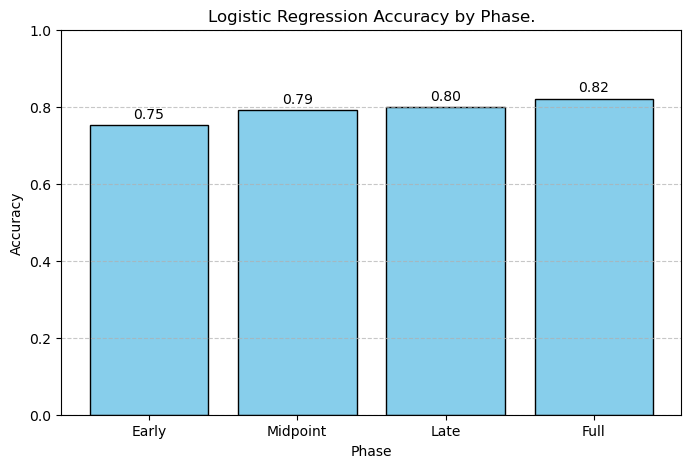

In [223]:
lr_accuracies = {
    phase: accuracy_score(yte, lr_best_models[phase].predict(Xte))
    for phase, (_, _, Xte, yte) in phase_sets.items()
}

plt.figure(figsize=(8, 5))
bars = plt.bar(lr_accuracies.keys(), lr_accuracies.values(), color="skyblue", edgecolor="black")
plt.title("Logistic Regression Accuracy by Phase.")
plt.xlabel("Phase")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add annotations.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)
plt.show()

#### LR F1 Score (Dropout)

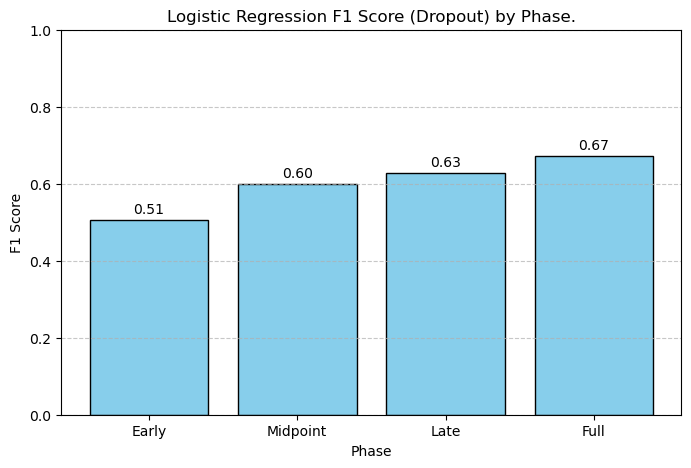

In [224]:
lr_f1_scores = {
    phase: f1_score(yte, lr_best_models[phase].predict(Xte), pos_label=0)
    for phase, (_, _, Xte, yte) in phase_sets.items()
}

plt.figure(figsize=(8, 5))
bars = plt.bar(lr_f1_scores.keys(), lr_f1_scores.values(), color="skyblue", edgecolor="black")
plt.title("Logistic Regression F1 Score (Dropout) by Phase.")
plt.xlabel("Phase")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add annotations.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)
plt.show()

#### LR Precision and Recall (Dropout)

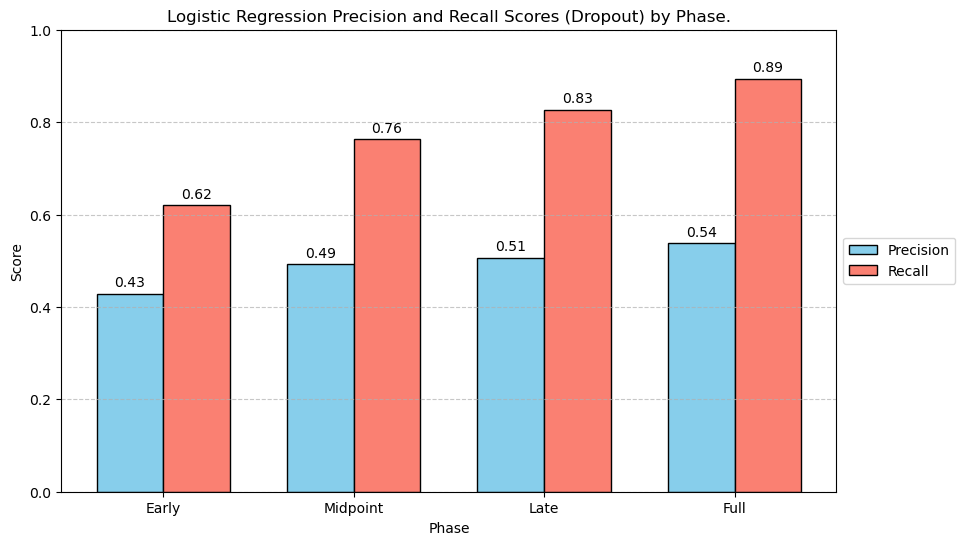

In [225]:
# Compute precision scores for dropouts (label 0).
lr_precision_scores = {
    phase: precision_score(yte, model.predict(Xte), pos_label=0)
    for phase, (_, _, Xte, yte) in phase_sets.items()
    for model in [lr_best_models[phase]]
}

# Compute recall scores for dropouts (label 0).
lr_recall_scores = {
    phase: recall_score(yte, model.predict(Xte), pos_label=0)
    for phase, (_, _, Xte, yte) in phase_sets.items()
    for model in [lr_best_models[phase]]
}

# Prepare the scores.
phases = list(lr_precision_scores.keys())
lr_precision_values = list(lr_precision_scores.values())
lr_recall_values = list(lr_recall_scores.values())

x = np.arange(len(phases))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, lr_precision_values, width, label='Precision', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, lr_recall_values, width, label='Recall', color='salmon', edgecolor='black')
ax.set_xlabel('Phase')
ax.set_ylabel('Score')
ax.set_title('Logistic Regression Precision and Recall Scores (Dropout) by Phase.')
ax.set_xticks(x)
ax.set_xticklabels(phases)
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Move legend outside to the right.
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10)
add_labels(bars1)
add_labels(bars2)
plt.show()

## Support Vector Machine (SVM)

In [244]:
# Initialise SVM pipeline.
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=seed))
])

# svm_param_grid = [
#     {   # RBF kernel.
#         'classifier__kernel': ['rbf'],
#         'classifier__C': [0.1, 0.5, 1, 2, 5],
#         'classifier__gamma': ['scale', 0.001, 0.01, 1, 10],
#         'classifier__class_weight': ['balanced']
#     },
#     # {   # Polynomial kernel.
#     #     'classifier__kernel': ['poly'],
#     #     'classifier__degree': [2, 3],
#     #     'classifier__C': [0.1, 0.5, 1, 2, 5],
#     #     'classifier__gamma': ['scale', 0.001, 0.01, 1, 10],
#     #     'classifier__coef0': [0, 1],
#     #     'classifier__class_weight': ['balanced']
#     # }
# ]

# Parameter grid for tuning SVM.
svm_param_grid = [
    {
        'classifier__kernel': ['rbf', 'poly'],
        'classifier__C': [0.1, 1, 5],
        'classifier__gamma': [1],
        'classifier__class_weight': ['balanced']
    }
]

svm_best_models = {}
svm_best_params = {}
svm_best_scores = {}

for phase, (Xtr, ytr, Xte, yte) in phase_sets.items():
    print(f"Running GridSearchCV for SVM - {phase} Phase...")
    
    svm_gs_model = GridSearchCV(
        estimator=clone(svm_pipeline),
        param_grid=svm_param_grid,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    
    svm_gs_model.fit(Xtr, ytr)
    svm_best_models[phase] = svm_gs_model.best_estimator_
    svm_best_params[phase] = svm_gs_model.best_params_
    svm_best_scores[phase] = svm_gs_model.best_score_

print("Best SVM Parameters and Macro F1 Scores per Phase:\n")
for phase in phase_sets.keys():
    print(f"{phase} Phase:")
    print(f"  Best Params: {svm_best_params[phase]}")
    print(f"  CV F1_macro: {svm_best_scores[phase]:.3f}\n")

Running GridSearchCV for SVM - Early Phase...


KeyboardInterrupt: 

#### SVM Classification Report

In [243]:
# Generate classification reports using the best SVM models.
svm_classification_reports = {
    phase: classification_report(yte, svm_best_models[phase].predict(Xte))
    for phase, (_, _, Xte, yte) in phase_sets.items()
}

for phase, report in svm_classification_reports.items():
    print(f"{phase} Phase\n")
    print(report)
    print("-" * 60)

Early Phase

              precision    recall  f1-score   support

           0       0.46      0.15      0.23      1145
           1       0.81      0.95      0.88      4452

    accuracy                           0.79      5597
   macro avg       0.64      0.55      0.55      5597
weighted avg       0.74      0.79      0.75      5597

------------------------------------------------------------
Midpoint Phase

              precision    recall  f1-score   support

           0       0.62      0.07      0.13      1145
           1       0.81      0.99      0.89      4452

    accuracy                           0.80      5597
   macro avg       0.71      0.53      0.51      5597
weighted avg       0.77      0.80      0.73      5597

------------------------------------------------------------
Late Phase

              precision    recall  f1-score   support

           0       0.61      0.06      0.12      1145
           1       0.80      0.99      0.89      4452

    accuracy       

#### SVM Accuracy

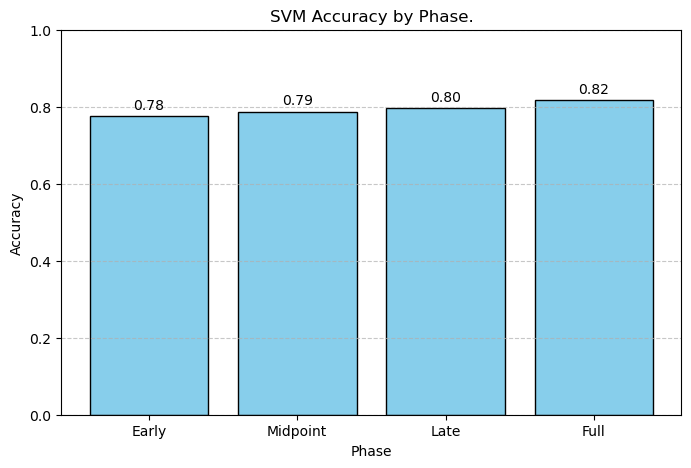

In [238]:
svm_accuracies = {
    phase: accuracy_score(yte, svm_best_models[phase].predict(Xte))
    for phase, (_, _, Xte, yte) in phase_sets.items()
}

plt.figure(figsize=(8, 5))
bars = plt.bar(svm_accuracies.keys(), svm_accuracies.values(), color="skyblue", edgecolor="black")
plt.title("SVM Accuracy by Phase.")
plt.xlabel("Phase")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add annotations.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)
plt.show()

#### SVM F1 Score (Dropout)

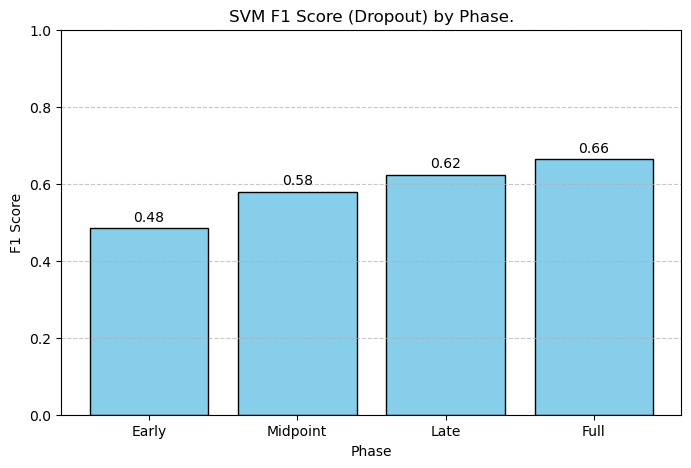

In [239]:
svm_f1_scores = {
    phase: f1_score(yte, svm_best_models[phase].predict(Xte), pos_label=0)
    for phase, (_, _, Xte, yte) in phase_sets.items()
}

plt.figure(figsize=(8, 5))
bars = plt.bar(svm_f1_scores.keys(), svm_f1_scores.values(), color="skyblue", edgecolor="black")
plt.title("SVM F1 Score (Dropout) by Phase.")
plt.xlabel("Phase")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add annotations.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)
plt.show()

#### SVM Precision and Recall (Dropout)

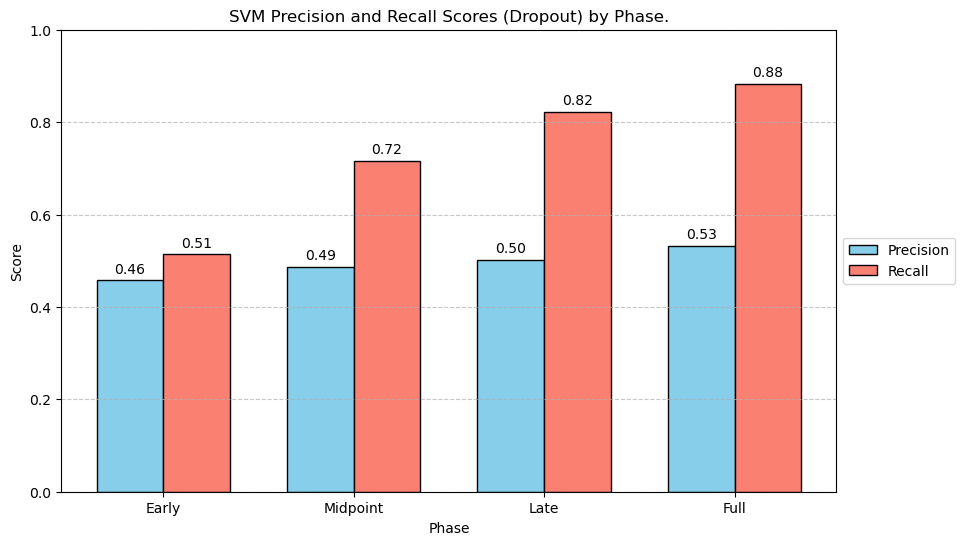

In [240]:
# Compute precision scores for dropouts (label 0).
svm_precision_scores = {
    phase: precision_score(yte, model.predict(Xte), pos_label=0)
    for phase, (_, _, Xte, yte) in phase_sets.items()
    for model in [svm_best_models[phase]]
}

# Compute recall scores for dropouts (label 0).
svm_recall_scores = {
    phase: recall_score(yte, model.predict(Xte), pos_label=0)
    for phase, (_, _, Xte, yte) in phase_sets.items()
    for model in [svm_best_models[phase]]
}

# Prepare the scores.
phases = list(svm_precision_scores.keys())
svm_precision_values = list(svm_precision_scores.values())
svm_recall_values = list(svm_recall_scores.values())

x = np.arange(len(phases))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, svm_precision_values, width, label='Precision', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, svm_recall_values, width, label='Recall', color='salmon', edgecolor='black')
ax.set_xlabel('Phase')
ax.set_ylabel('Score')
ax.set_title('SVM Precision and Recall Scores (Dropout) by Phase.')
ax.set_xticks(x)
ax.set_xticklabels(phases)
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Move legend outside to the right.
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10)
add_labels(bars1)
add_labels(bars2)
plt.show()

## MLP Classifier

In [254]:
# Untuned pipeline template.
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(random_state=seed))
])

# Parameter grid.
mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(100, 50), (100, 50, 25), (100, 100, 50)],
    'classifier__alpha': [1e-4, 1e-3, 1e-2],
    'classifier__learning_rate_init': [0.001, 0.01],
    'classifier__max_iter': [350]
}

mlp_best_models   = {}
mlp_best_params   = {}
mlp_best_scores   = {}

for phase, (Xtr, ytr, Xte, yte) in phase_sets.items():
    
    # Fresh grid‑search object each time.
    mlp_gs_model = GridSearchCV(
        estimator = clone(mlp_pipeline),
        param_grid = mlp_param_grid,
        scoring = 'f1_macro',
        cv = None,
        n_jobs = -1,
        verbose = 0
    )
    
    mlp_gs_model.fit(Xtr, ytr)
    mlp_best_models[phase] = mlp_gs_model.best_estimator_
    mlp_best_params[phase] = mlp_gs_model.best_params_
    mlp_best_scores[phase] = mlp_gs_model.best_score_

print("Best parameters and macro F1 for each phase\n")
for phase in phase_sets.keys():
    print(f"{phase}:")
    print(mlp_best_params[phase])
    print(f"cross validated F1_macro = {mlp_best_scores[phase]:.3f}\n")

Best parameters and macro F1 for each phase

Early:
{'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100, 100, 50), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 350}
cross validated F1_macro = 0.432

Midpoint:
{'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 350}
cross validated F1_macro = 0.446

Late:
{'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 350}
cross validated F1_macro = 0.491

Full:
{'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 350}
cross validated F1_macro = 0.566



In [ ]:
# Define the MLP pipeline
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100,),  # default single hidden layer with 100 neurons
        alpha=0.0001,                # L2 regularisation term
        learning_rate_init=0.001,
        max_iter=200,
        random_state=seed
    ))
])

# Fit and evaluate the MLP model for each phase
mlp_models = {}
mlp_reports = {}
mlp_accuracies = {}
mlp_f1_scores = {}

for phase, (Xtr, ytr, Xte, yte) in phase_sets.items():
    model = clone(mlp_pipeline)
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    
    mlp_models[phase] = model
    mlp_reports[phase] = classification_report(yte, y_pred)
    mlp_accuracies[phase] = accuracy_score(yte, y_pred)
    mlp_f1_scores[phase] = f1_score(yte, y_pred)

for phase in phase_sets:
    print(f"{phase} Phase\n{'-'*60}")
    print(mlp_reports[phase])

#### MLP Classification Report

In [255]:
# Generate classification reports using the best MLP classifier models.
mlp_classification_reports = {
    phase: classification_report(yte, mlp_best_models[phase].predict(Xte))
    for phase, (_, _, Xte, yte) in phase_sets.items()
}

for phase, report in mlp_classification_reports.items():
    print(f"{phase} Phase\n")
    print(report)
    print("-" * 60)

Early Phase

              precision    recall  f1-score   support

           0       0.43      0.34      0.38      1145
           1       0.84      0.89      0.86      4452

    accuracy                           0.77      5597
   macro avg       0.64      0.61      0.62      5597
weighted avg       0.76      0.77      0.76      5597

------------------------------------------------------------
Midpoint Phase

              precision    recall  f1-score   support

           0       0.51      0.43      0.47      1145
           1       0.86      0.89      0.88      4452

    accuracy                           0.80      5597
   macro avg       0.68      0.66      0.67      5597
weighted avg       0.79      0.80      0.79      5597

------------------------------------------------------------
Late Phase

              precision    recall  f1-score   support

           0       0.56      0.55      0.56      1145
           1       0.88      0.89      0.89      4452

    accuracy       

#### MLP Accuracy

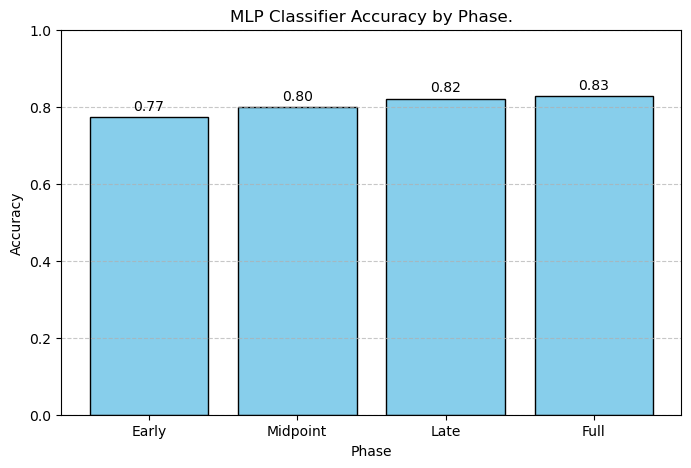

In [256]:
mlp_accuracies = {
    phase: accuracy_score(yte, mlp_best_models[phase].predict(Xte))
    for phase, (_, _, Xte, yte) in phase_sets.items()
}

plt.figure(figsize=(8, 5))
bars = plt.bar(mlp_accuracies.keys(), mlp_accuracies.values(), color="skyblue", edgecolor="black")
plt.title("MLP Classifier Accuracy by Phase.")
plt.xlabel("Phase")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add annotations.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)
plt.show()

#### MLP F1 Score (Dropout)

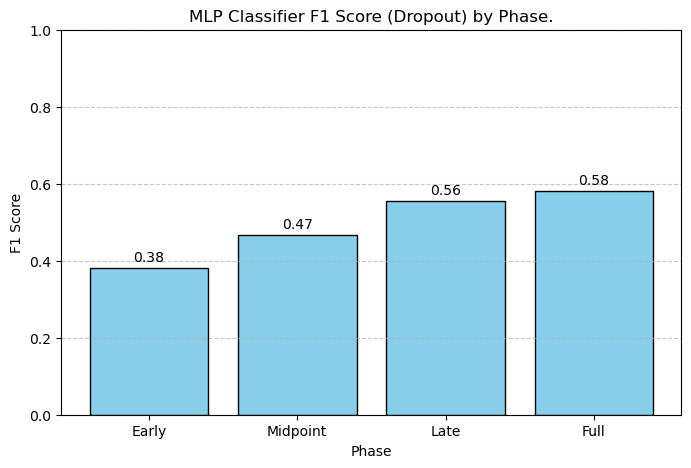

In [257]:
mlp_f1_scores = {
    phase: f1_score(yte, mlp_best_models[phase].predict(Xte), pos_label=0)
    for phase, (_, _, Xte, yte) in phase_sets.items()
}

plt.figure(figsize=(8, 5))
bars = plt.bar(mlp_f1_scores.keys(), mlp_f1_scores.values(), color="skyblue", edgecolor="black")
plt.title("MLP Classifier F1 Score (Dropout) by Phase.")
plt.xlabel("Phase")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add annotations.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)
plt.show()

#### MLP Precision and Recall (Dropout)

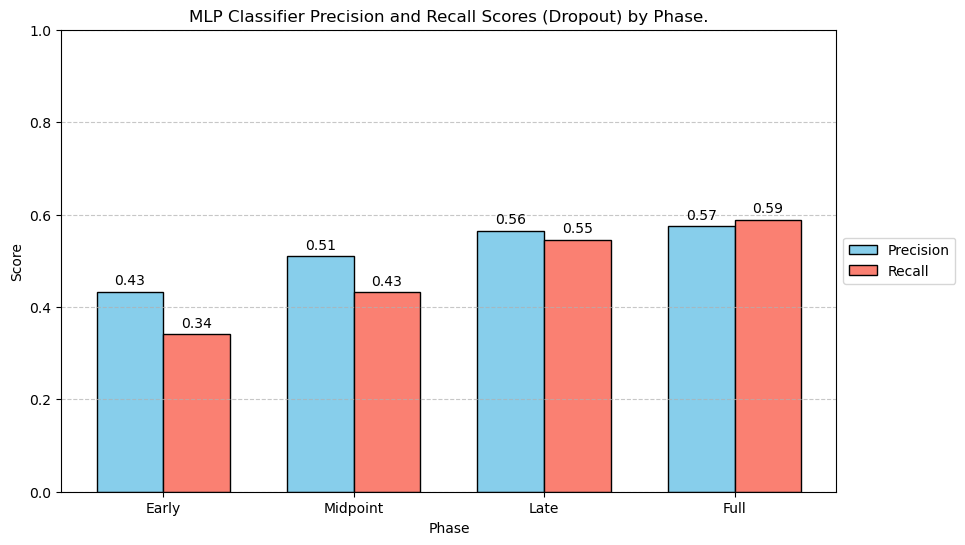

In [258]:
# Compute precision scores for dropouts (label 0).
mlp_precision_scores = {
    phase: precision_score(yte, model.predict(Xte), pos_label=0)
    for phase, (_, _, Xte, yte) in phase_sets.items()
    for model in [mlp_best_models[phase]]
}

# Compute recall scores for dropouts (label 0).
mlp_recall_scores = {
    phase: recall_score(yte, model.predict(Xte), pos_label=0)
    for phase, (_, _, Xte, yte) in phase_sets.items()
    for model in [mlp_best_models[phase]]
}

# Prepare the scores.
phases = list(mlp_precision_scores.keys())
mlp_precision_values = list(mlp_precision_scores.values())
mlp_recall_values = list(mlp_recall_scores.values())

x = np.arange(len(phases))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, mlp_precision_values, width, label='Precision', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, mlp_recall_values, width, label='Recall', color='salmon', edgecolor='black')
ax.set_xlabel('Phase')
ax.set_ylabel('Score')
ax.set_title('MLP Classifier Precision and Recall Scores (Dropout) by Phase.')
ax.set_xticks(x)
ax.set_xticklabels(phases)
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Move legend outside to the right.
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10)
add_labels(bars1)
add_labels(bars2)
plt.show()